<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# Machine learning autoencoder + Kmeans for STM image data analysis
## Steven R. Schofield (Universtiy College London Dec. 2024)

### Load required modules

In [1]:
# Define path where to find the module. This allows for a different path depending on where the code is running (my mac or the cluster)
import os

module_path_list = [
    '/Users/steven/academic-iCloud/Python/modules',
    '/hpc/srs/Python/modules'
] 

data_path_list = [
    '/Users/steven/Python-data',
    '/hpc/srs/Python-data'
]

module_path = next((p for p in module_path_list if os.path.exists(p)), None)
if not module_path:
    exit("No valid module paths.")
else:
    print('module_path = {}'.format(module_path))

data_path = next((p for p in data_path_list if os.path.exists(p)), None)
if not module_path:
    exit("No valid data paths.")
else:
    print('data_path = {}'.format(data_path))

# adjust tensorflow output level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 0 default all messages, 1 warnings and errors, 2, errors, 3 fatal errors only

module_path = /Users/steven/academic-iCloud/Python/modules
data_path = /Users/steven/Python-data


In [2]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

# Import standard modules
import os, sys
import numpy as np

import platform

from datetime import datetime

# Add custom module path to list
sys.path.append(module_path)

# Import custom module
import SRSML24.data_prep as dp
import SRSML24.model as m

import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

#import platform 

m.print_system_info()

start_time = dp.current_datetime()


Python version: 3.8.18 (default, Sep 11 2023, 08:17:16) 
[Clang 14.0.6 ]
TensorFlow version: 2.13.0
TensorFlow is built with CUDA: False
TensorFlow is built with ROCm: False

System: Darwin 24.1.0 (arm64)
Platform: macOS-15.1.1-arm64-arm-64bit
Processor: arm

Number of GPUs available to TensorFlow: 1
GPU Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

>>> Running with GPU available <<<  (macOS-15.1.1-arm64-arm-64bit)

Current time 2024-12-29 13:07:51


### Programme variable setup

In [3]:
# Parameters for windows creation
job_name = 'MSc2024_Data'
job_data_path = dp.create_new_data_path(data_path, job_name, include_date=False)
mtrx_train_path = os.path.join(data_path, 'mtrx/train')
mtrx_test_path = os.path.join(data_path, 'mtrx/test')
mtrx_predict_path = os.path.join(data_path, 'mtrx/predict')
flatten_method = 'poly_xy'
pixel_density = 15.0    # Convert all images to a constant pixel density
pixel_ratio = 0.7       # If an image has less than this % in the slow scan direction it is discarded
data_scaling = 1.e9     # Scale the z-height of the data
window_size = 16        # Window size for training/validation
window_pitch = 16       # Window pitch for training/validation
together = True        # Set this True to save image windows for a mtrx image as a single file rather than separate files.
collate = False         # Set this True to remove all subfolder directories and save all data in root data path

# Parameters for training
model_name = 'unet_' + job_name
batch_size = 128
buffer_size = 12800 # shuffling
learning_rate = 1e-4
epochs = 5

# Parameters for clustering
cluster_model_name = model_name + '_kmeans'
cluster_batch_size = 5120 # This is the number of latent features in a batch for clustering. 
                          # Does not have to be the same as for training and probably should 
                          # be larger. 
cluster_buffer_size = cluster_batch_size * 5    # shuffling buffer
num_clusters=20                                 # Desired number of clusters (centroids) to form in the data.
n_init=50                                       # Number of times the algorithm will run with different centroid seeds.
max_iter=1000                                   # Maximum iterations allowed for each mini-batch to refine centroids.
reassignment_ratio=0.05                         # Fraction of clusters reassigned per step; lower values stabilize updates.

# Parameters for PREDICTIONS
predict_window_pitch = 4                        # Window pitch for prediction

# DATA LIMITS FOR TESTING THE CODE
mtrx_train_data_limit = 100 #None                    # Number of MTRX files to process (training)
mtrx_test_data_limit = 50 #None                     # Number of MTRX files to process (validation)

train_data_limit = None                         # Limit the data used in the autoencoder training
test_data_limit = None                          # Limit the data used in the autoencoder training (validation)

### Process Matrix format data to windows for autoencoder training and validation

In [4]:
# REMOVE ALL DATA FOLDERS EXCEPT MTRX 
dp.delete_data_folders(job_data_path, subdirectories=["jpg", "windows", "windows-jpg"], override=True)

Deleted: /Users/steven/Python-data/MSc2024_Data/jpg
All specified folders have been successfully deleted.


Found 1973 files with extension 'Z_mtrx' in directory:
/Users/steven/Python-data/mtrx/train
There are 100 files to process
....j

*************
 window number 1: 16 16




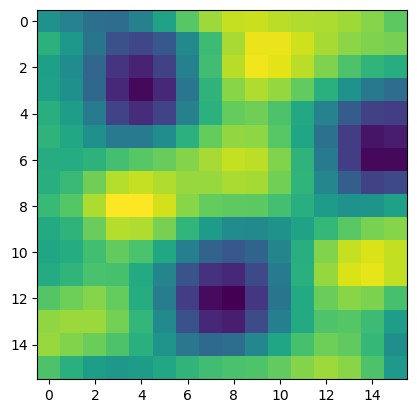



*************
 window number 2: 16 16




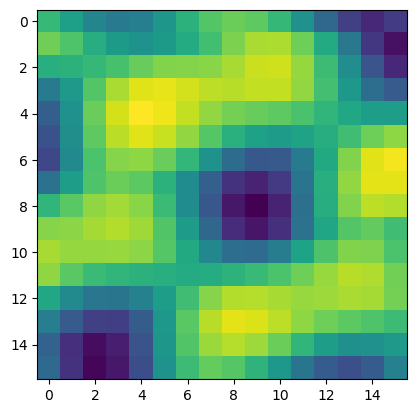



*************
 window number 3: 16 16




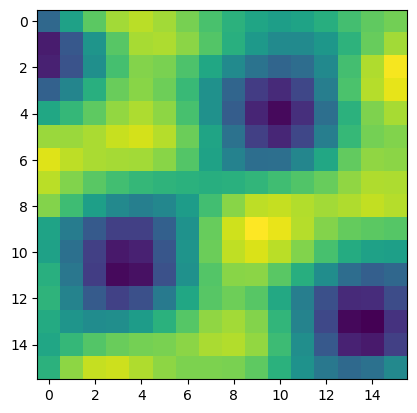



*************
 window number 4: 16 16




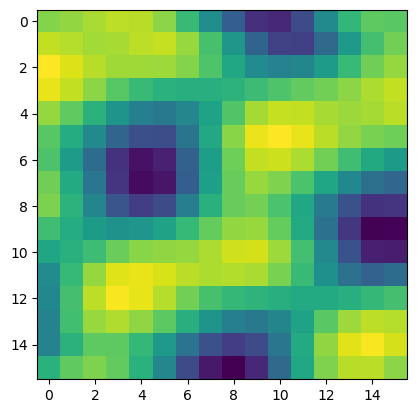



*************
 window number 5: 16 16




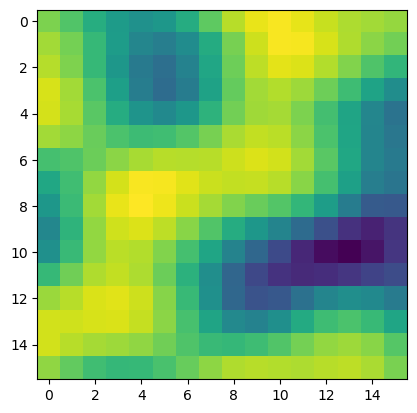



*************
 window number 6: 16 16




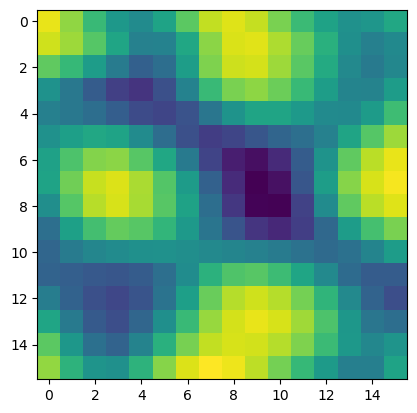



*************
 window number 7: 16 16




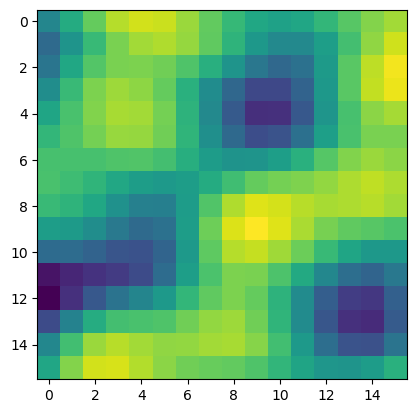



*************
 window number 8: 16 16




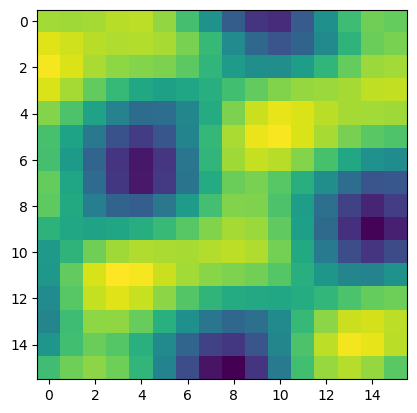



*************
 window number 9: 16 16




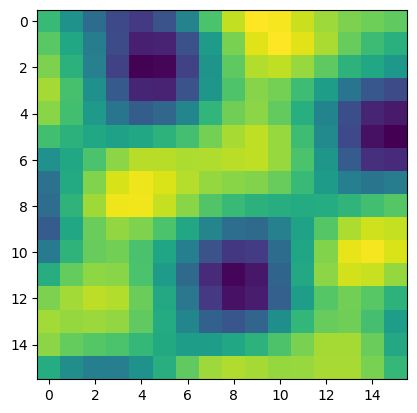



*************
 window number 10: 16 16




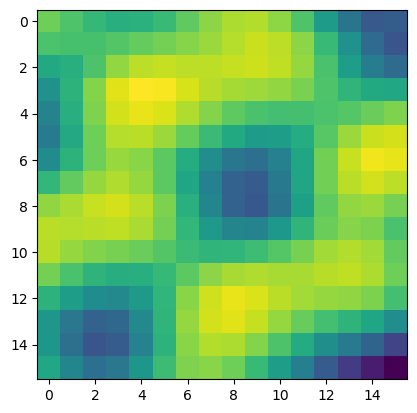



*************
 window number 11: 16 16




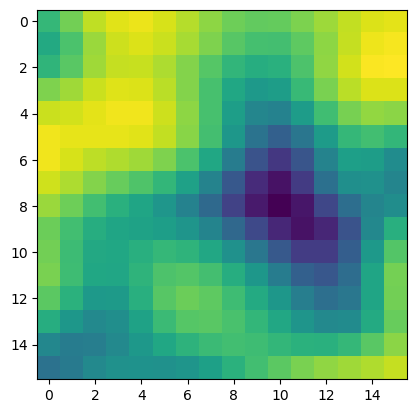



*************
 window number 12: 16 16




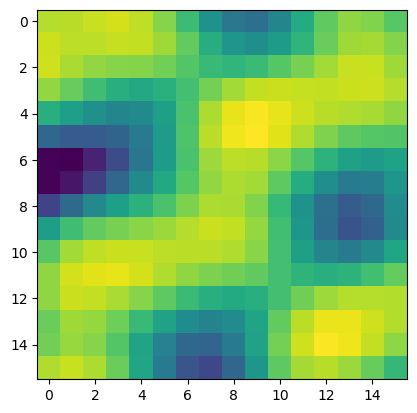



*************
 window number 13: 16 16




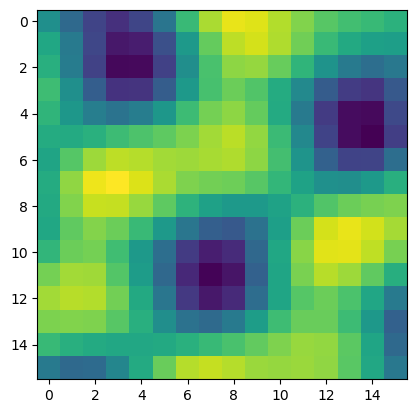



*************
 window number 14: 16 16




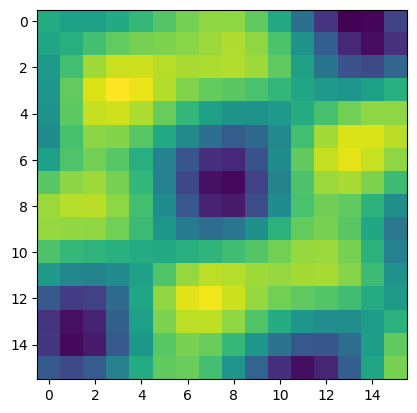



*************
 window number 15: 16 16




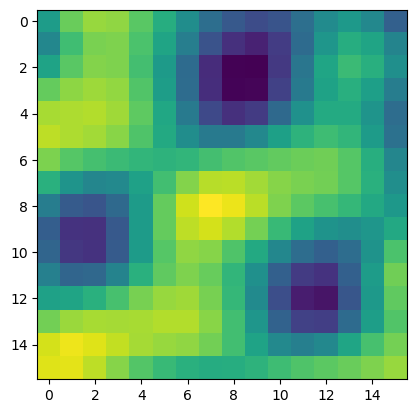



*************
 window number 16: 16 16




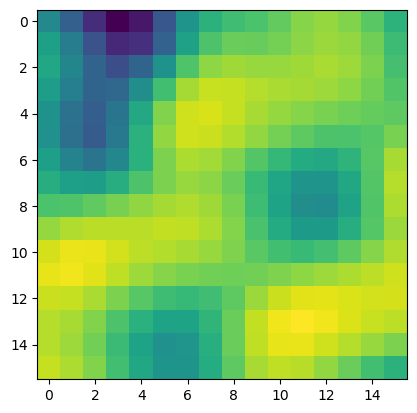



*************
 window number 17: 16 16




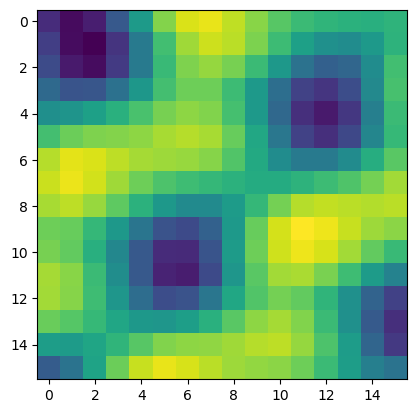



*************
 window number 18: 16 16




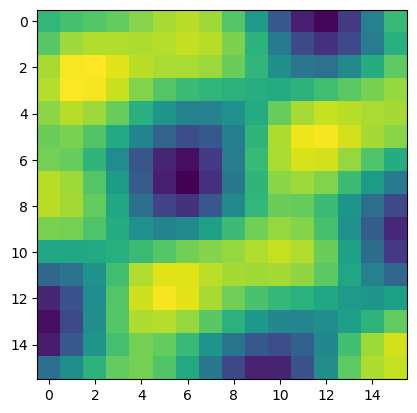



*************
 window number 19: 16 16




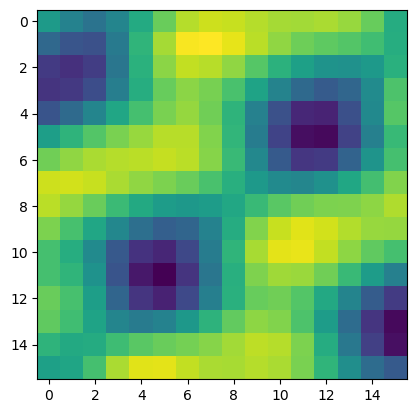



*************
 window number 20: 16 16




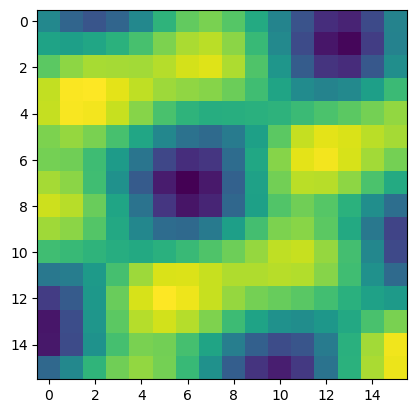



*************
 window number 21: 16 16




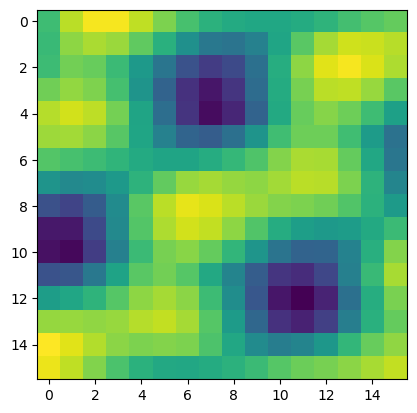



*************
 window number 22: 16 16




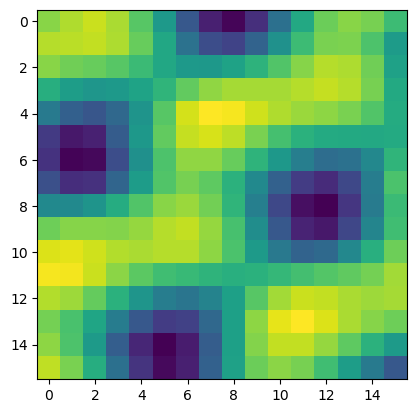



*************
 window number 23: 16 16




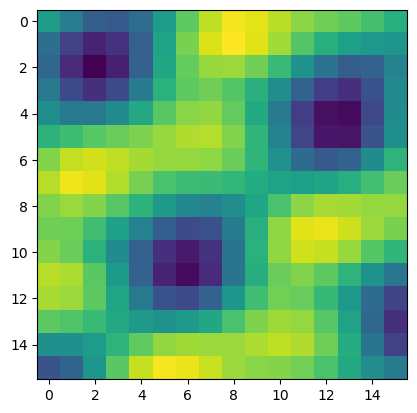



*************
 window number 24: 16 16




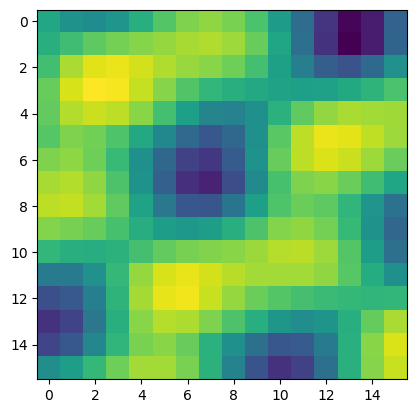



*************
 window number 25: 16 16




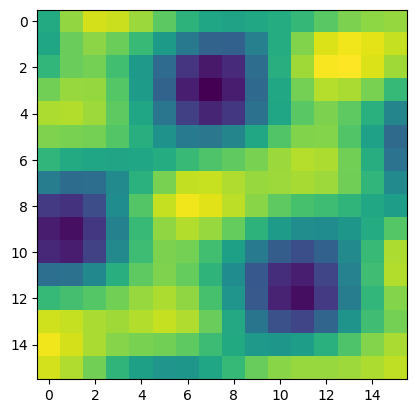



*************
 window number 26: 16 16




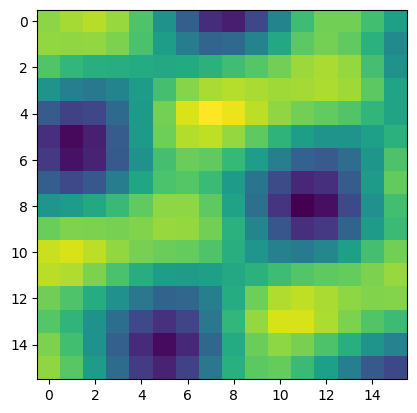



*************
 window number 27: 16 16




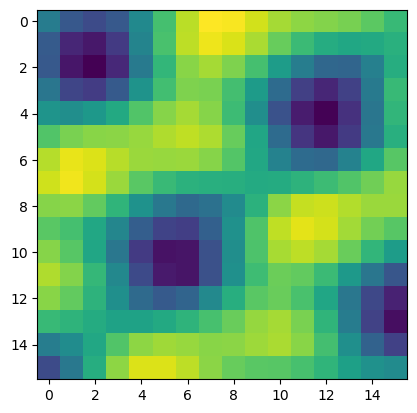



*************
 window number 28: 16 16




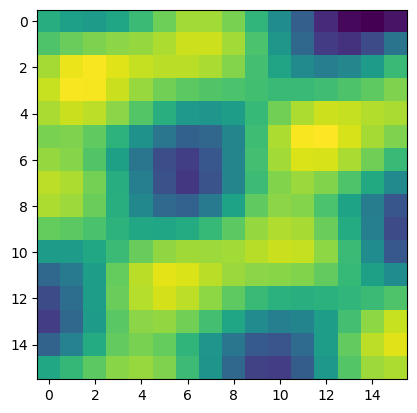



*************
 window number 29: 16 16




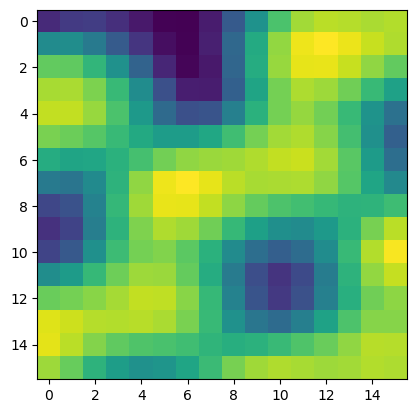



*************
 window number 30: 16 16




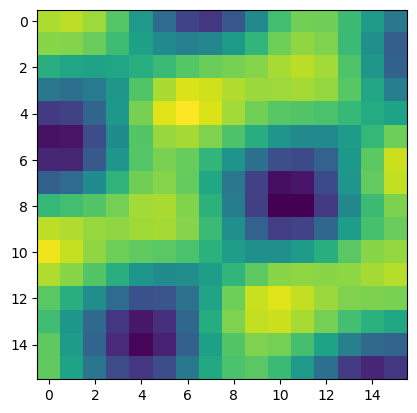



*************
 window number 31: 16 16




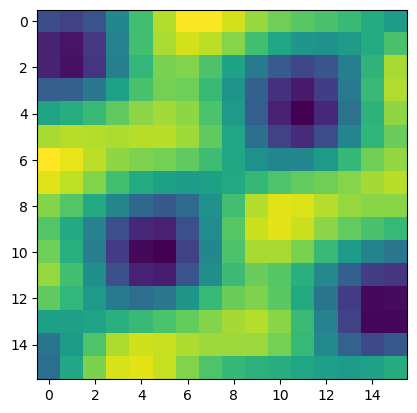



*************
 window number 32: 16 16




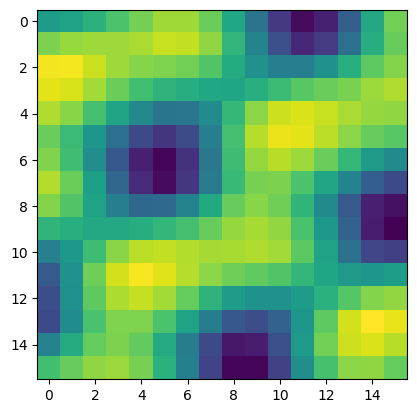



*************
 window number 33: 16 16




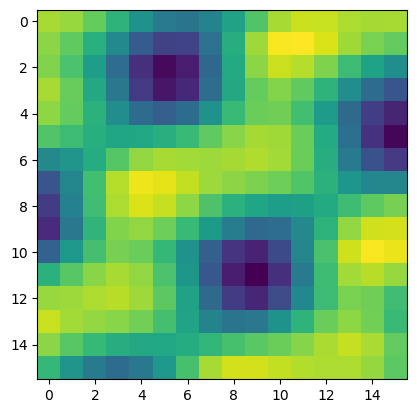



*************
 window number 34: 16 16




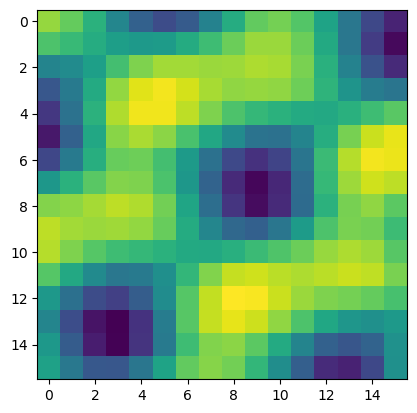



*************
 window number 35: 16 16




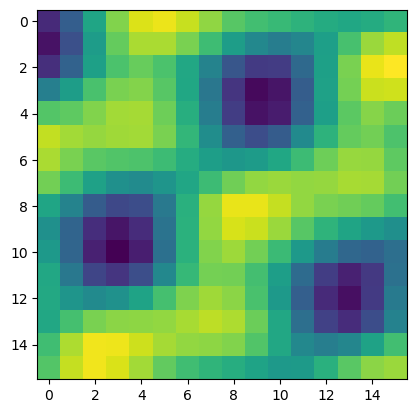



*************
 window number 36: 16 16




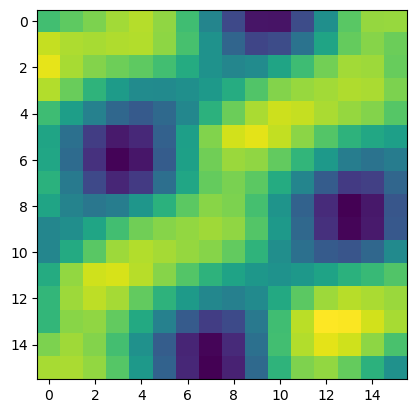



*************
 window number 37: 16 16




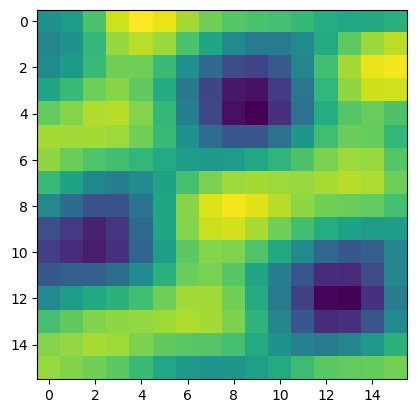



*************
 window number 38: 16 16




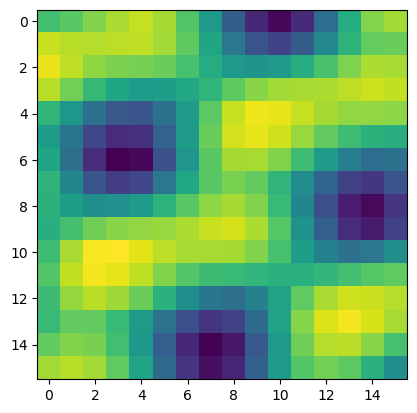



*************
 window number 39: 16 16




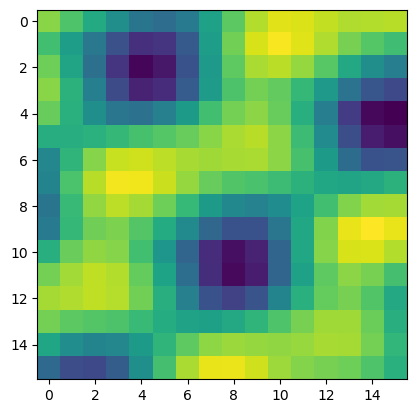



*************
 window number 40: 16 16




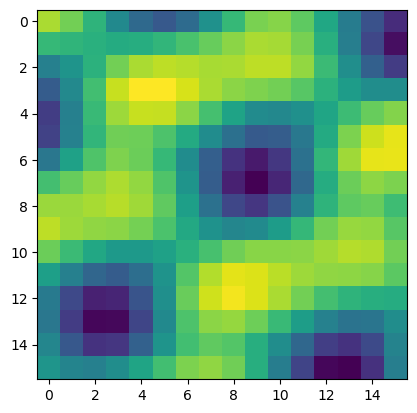



*************
 window number 41: 16 16




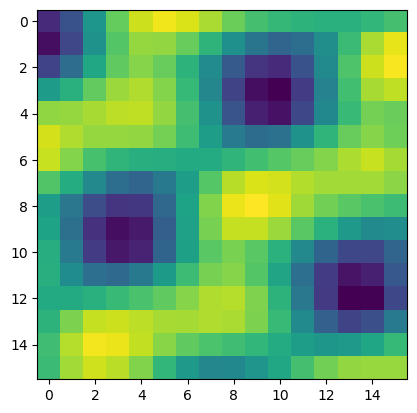



*************
 window number 42: 16 16




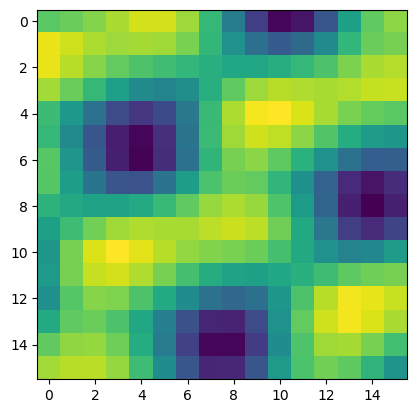



*************
 window number 43: 16 16




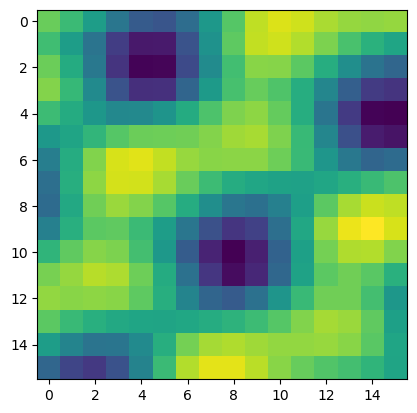



*************
 window number 44: 16 16




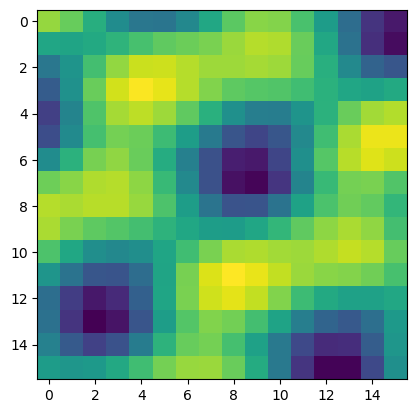



*************
 window number 45: 16 16




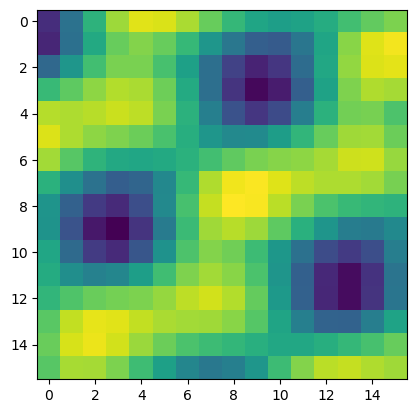



*************
 window number 46: 16 16




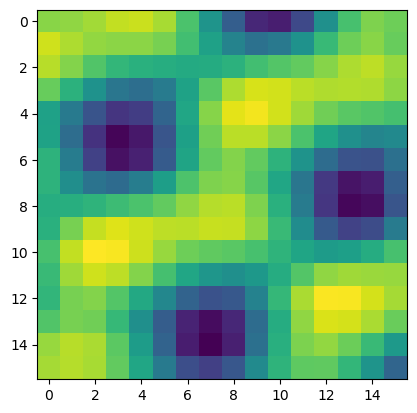



*************
 window number 47: 16 16




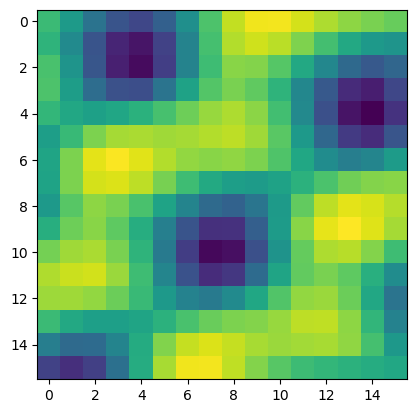



*************
 window number 48: 16 16




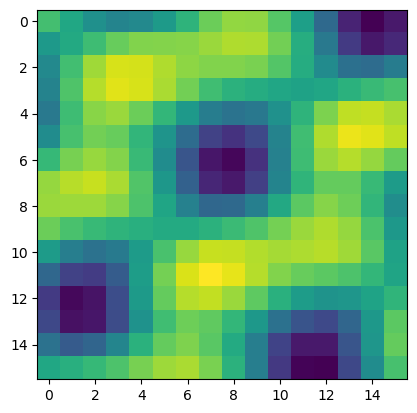



*************
 window number 49: 16 16




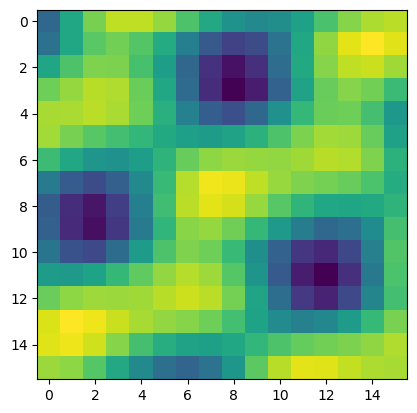



*************
 window number 50: 16 16




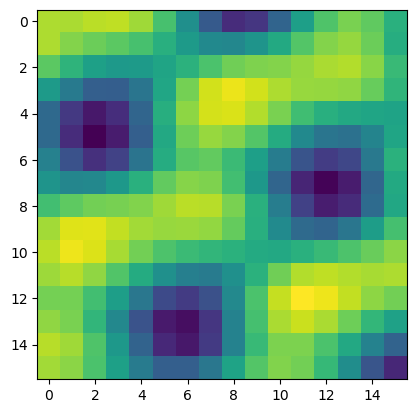



*************
 window number 51: 16 16




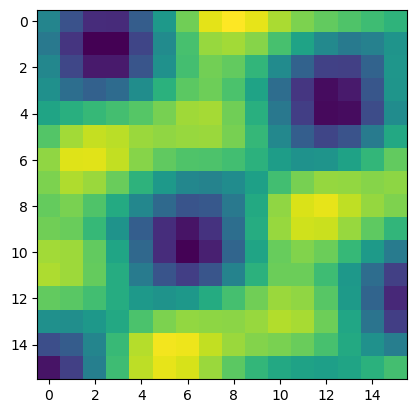



*************
 window number 52: 16 16




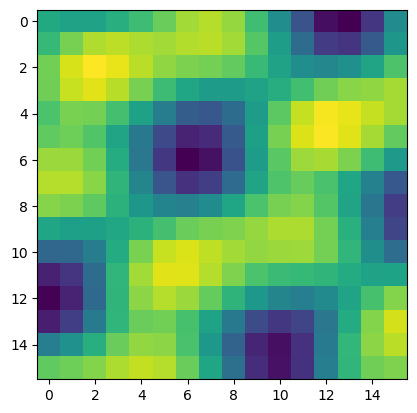



*************
 window number 53: 16 16




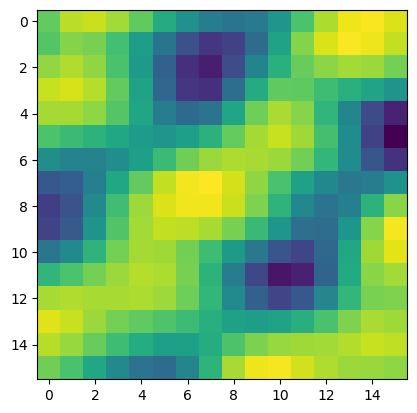



*************
 window number 54: 16 16




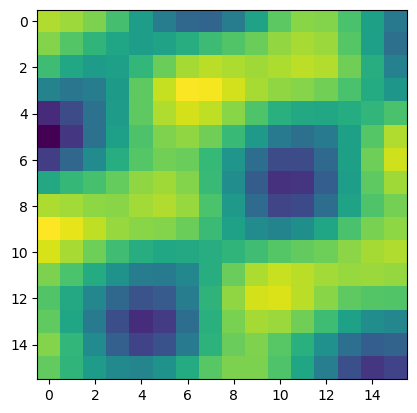



*************
 window number 55: 16 16




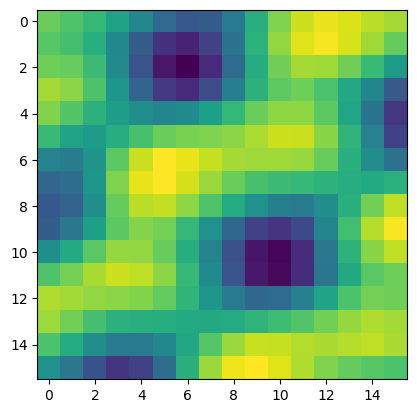



*************
 window number 56: 16 16




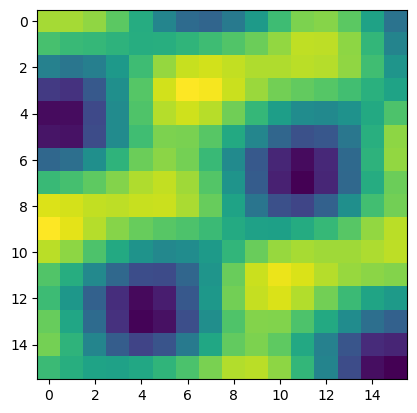



*************
 window number 57: 16 16




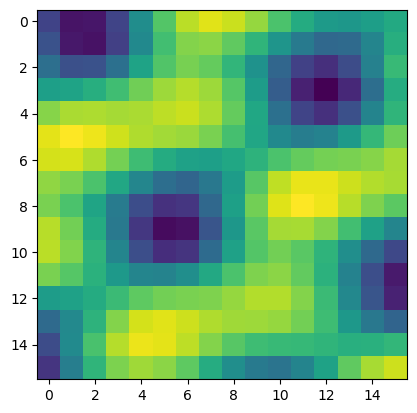



*************
 window number 58: 16 16




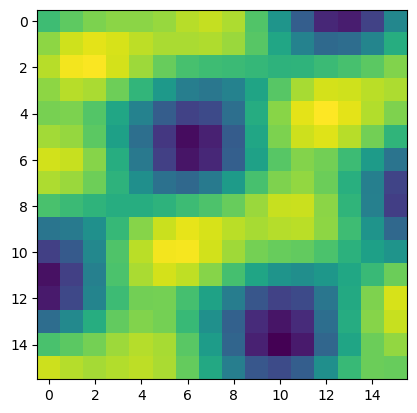



*************
 window number 59: 16 16




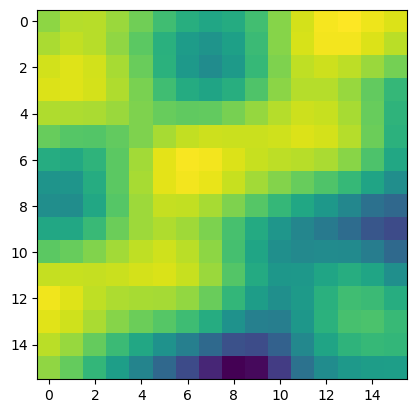



*************
 window number 60: 16 16




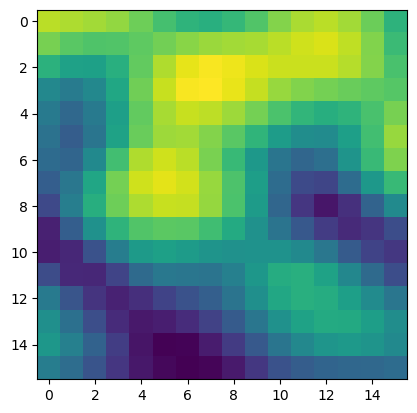



*************
 window number 61: 16 16




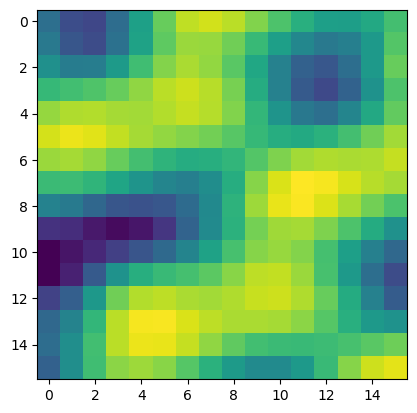



*************
 window number 62: 16 16




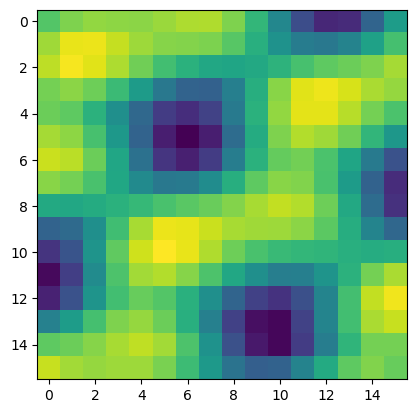



*************
 window number 63: 16 16




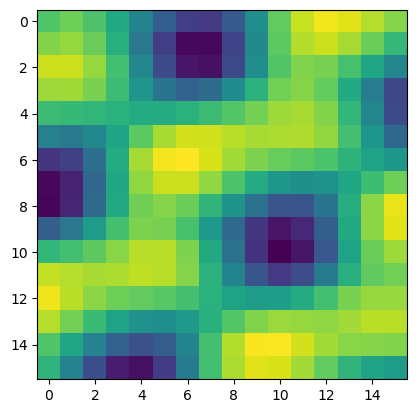



*************
 window number 64: 16 16




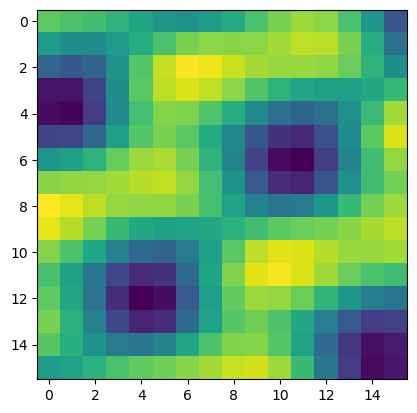



*************
 window number 65: 16 16




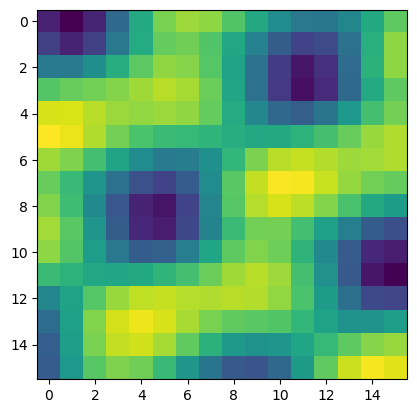



*************
 window number 66: 16 16




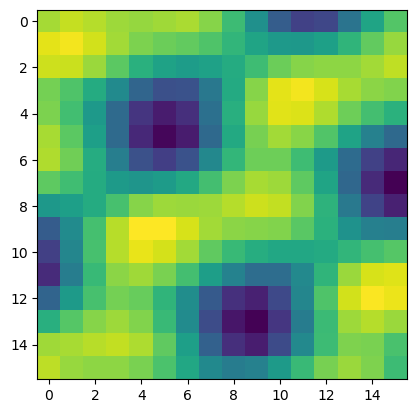



*************
 window number 67: 16 16




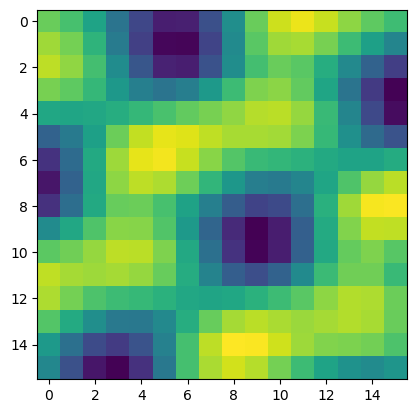



*************
 window number 68: 16 16




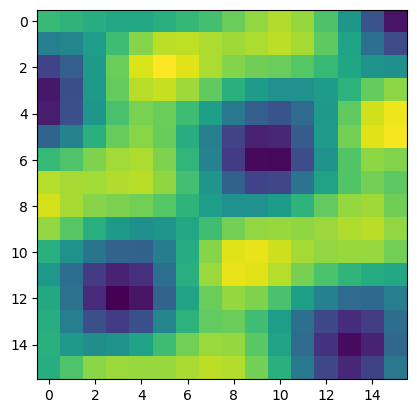



*************
 window number 69: 16 16




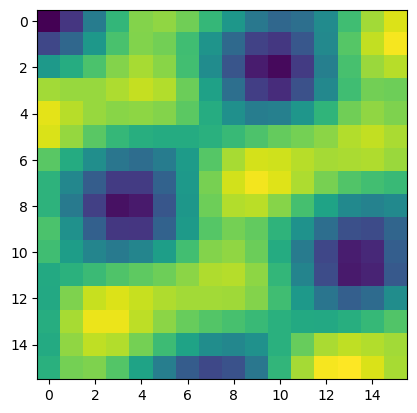



*************
 window number 70: 16 16




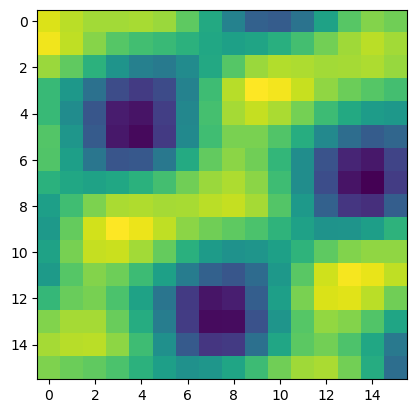



*************
 window number 71: 16 16




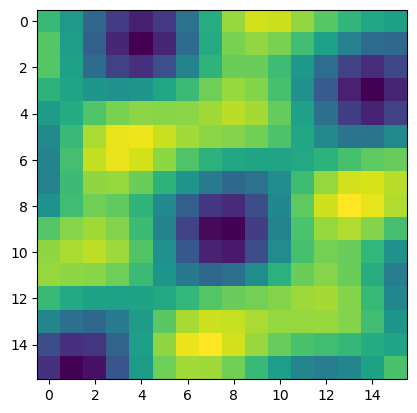



*************
 window number 72: 16 16




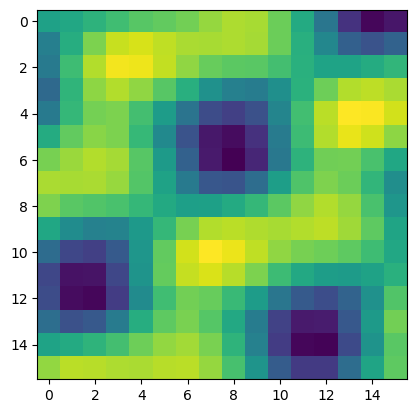



*************
 window number 73: 16 16




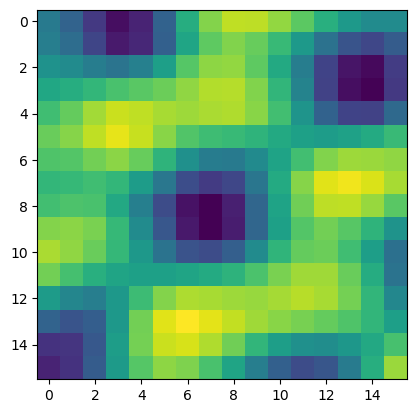



*************
 window number 74: 16 16




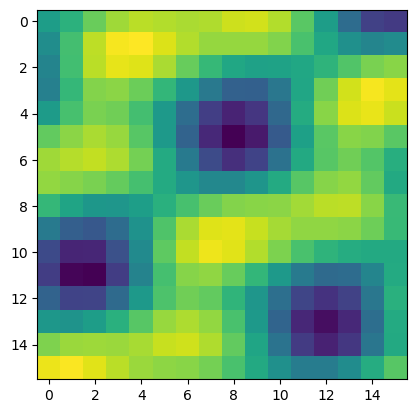



*************
 window number 75: 16 16




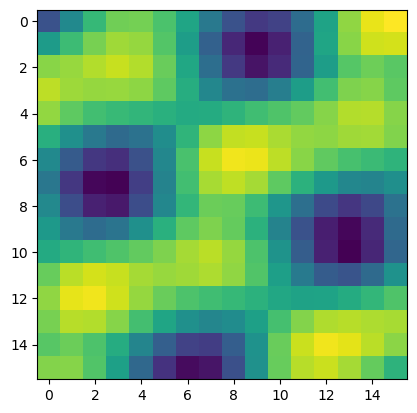



*************
 window number 76: 16 16




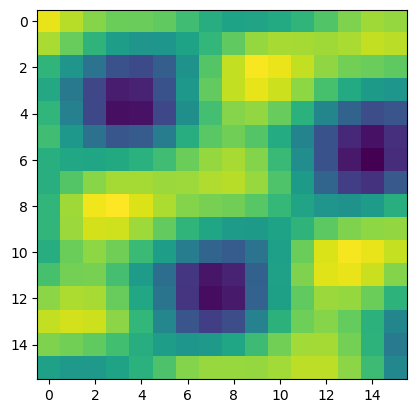



*************
 window number 77: 16 16




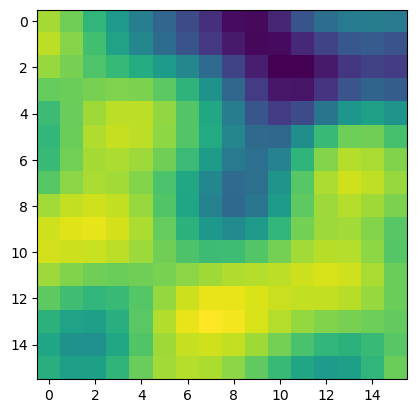



*************
 window number 78: 16 16




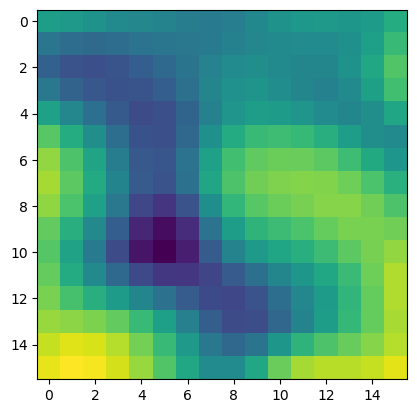



*************
 window number 79: 16 16




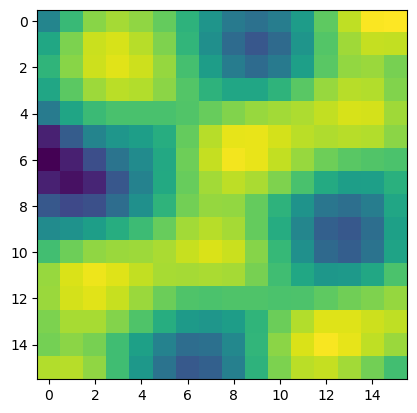



*************
 window number 80: 16 16




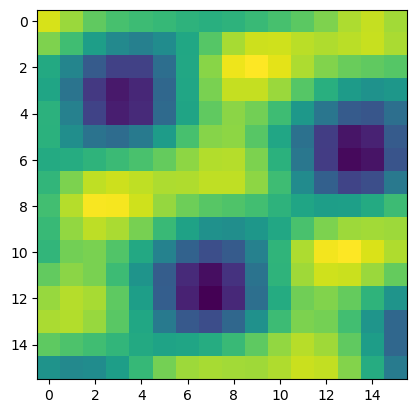



*************
 window number 81: 16 16




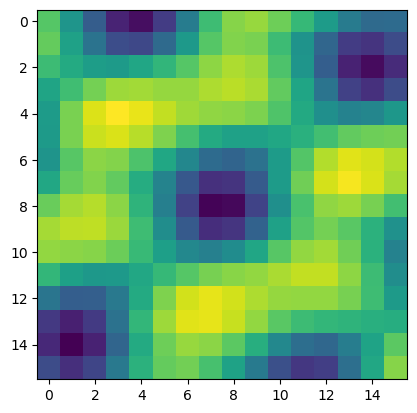



*************
 window number 82: 16 16




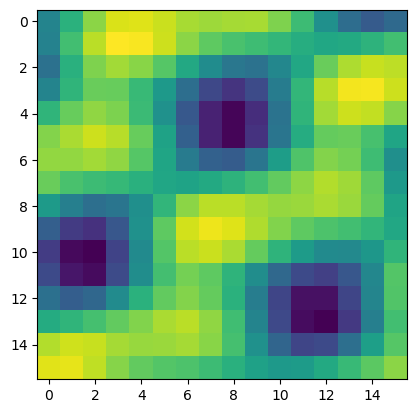



*************
 window number 83: 16 16




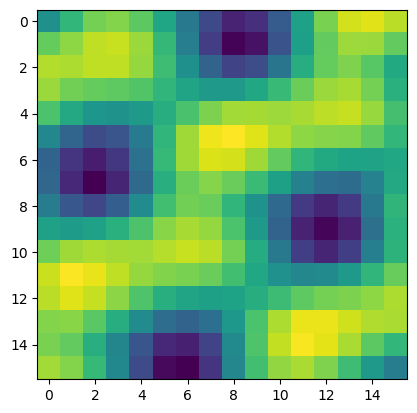



*************
 window number 84: 16 16




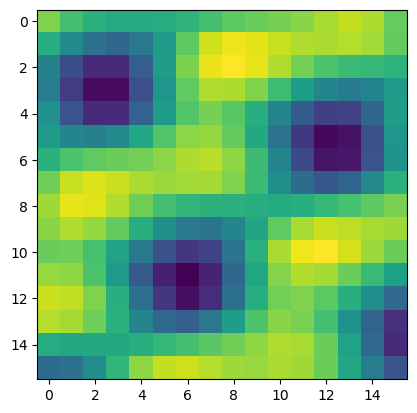



*************
 window number 85: 16 16




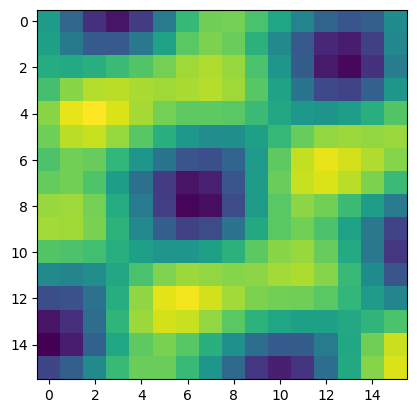



*************
 window number 86: 16 16




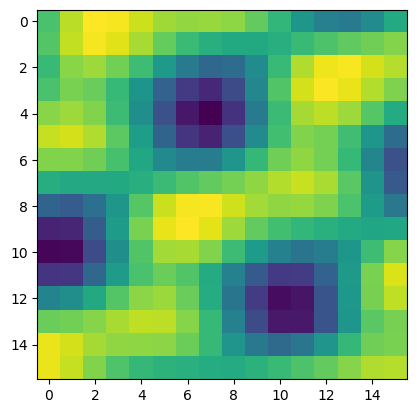



*************
 window number 87: 16 16




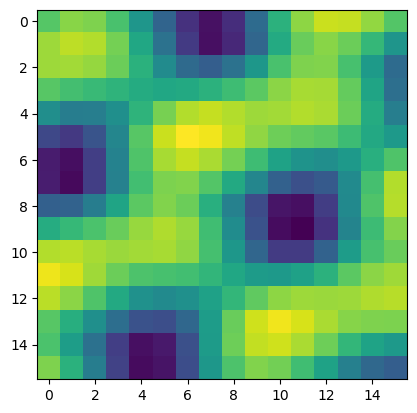



*************
 window number 88: 16 16




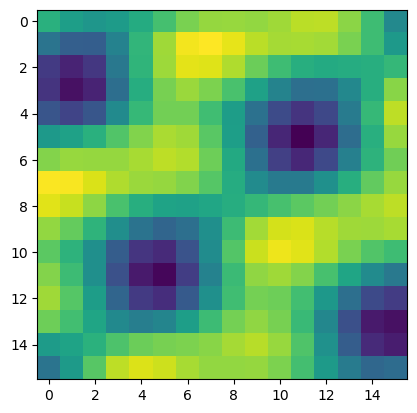



*************
 window number 89: 16 16




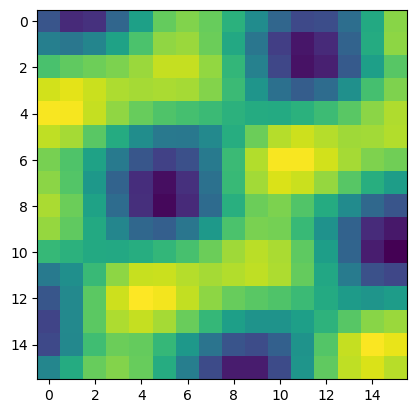



*************
 window number 90: 16 16




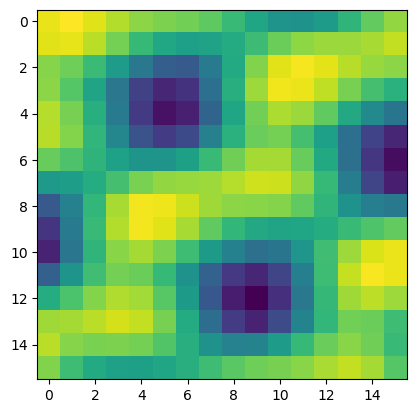



*************
 window number 91: 16 16




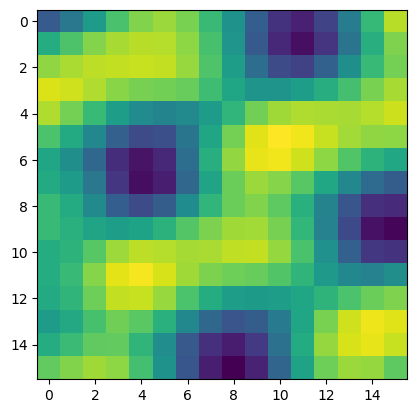



*************
 window number 92: 16 16




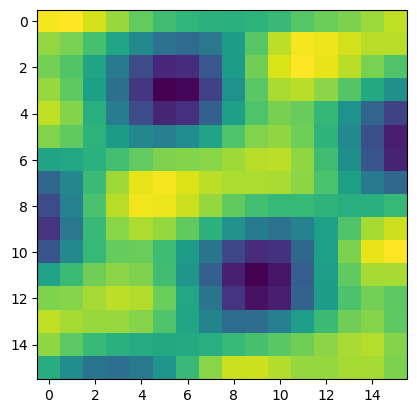



*************
 window number 93: 16 16




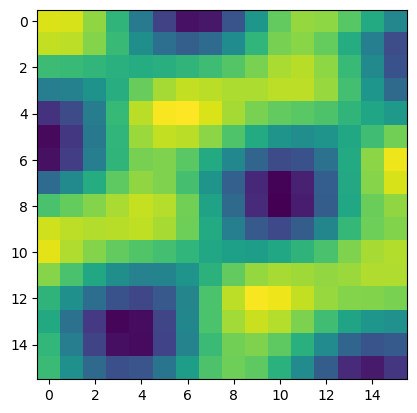



*************
 window number 94: 16 16




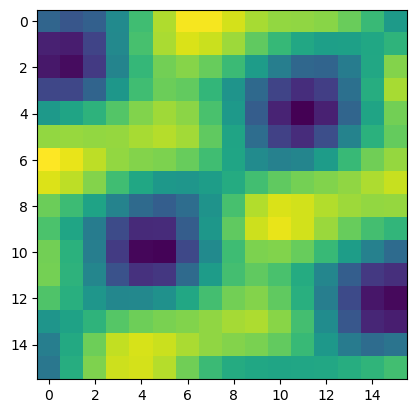



*************
 window number 95: 16 16




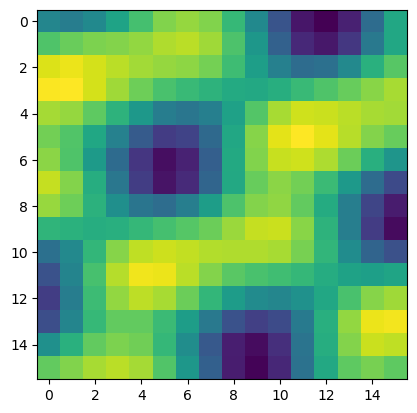



*************
 window number 96: 16 16




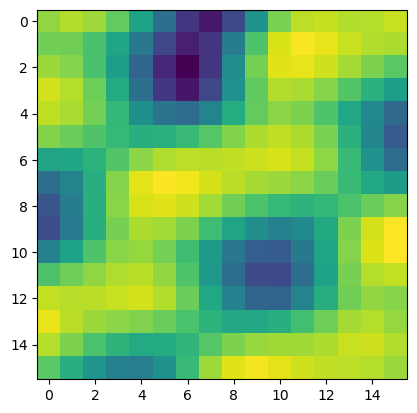



*************
 window number 97: 16 16




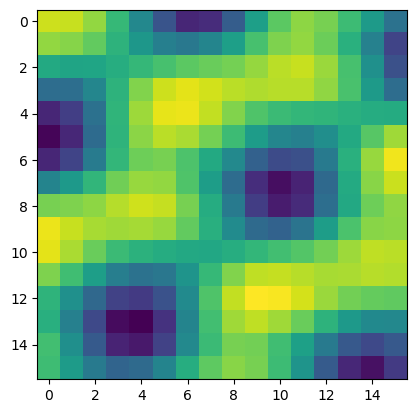



*************
 window number 98: 16 16




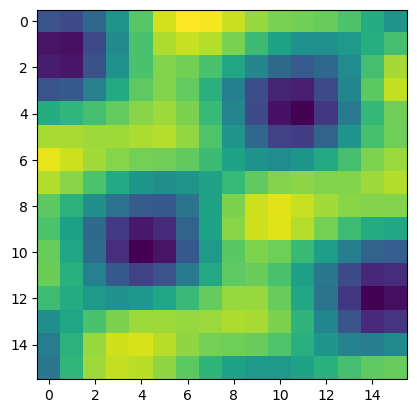



*************
 window number 99: 16 16




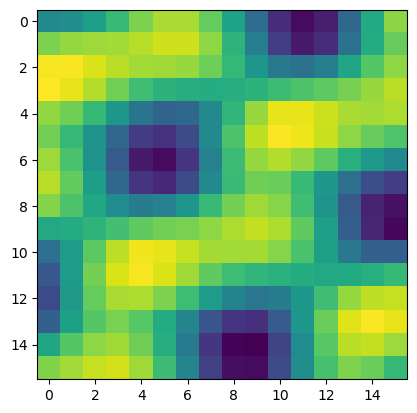



*************
 window number 100: 16 16




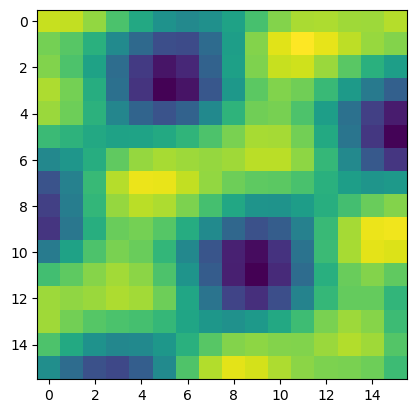



*************
 window number 101: 16 16




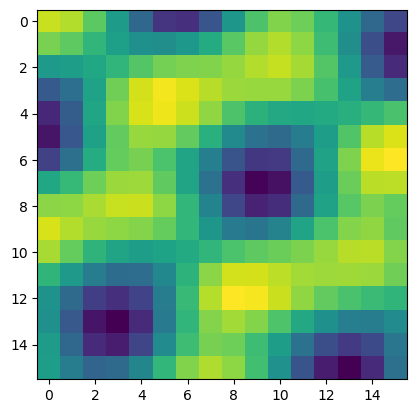



*************
 window number 102: 16 16




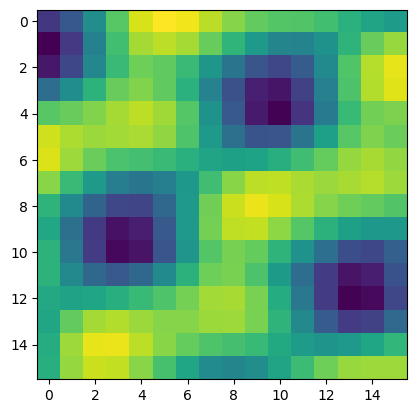



*************
 window number 103: 16 16




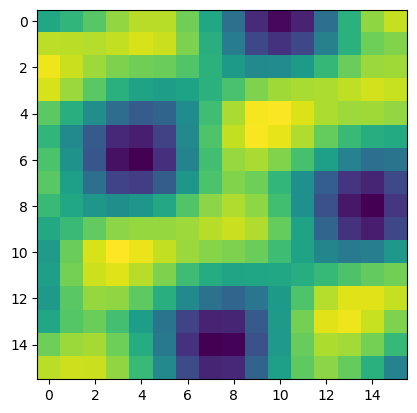



*************
 window number 104: 16 16




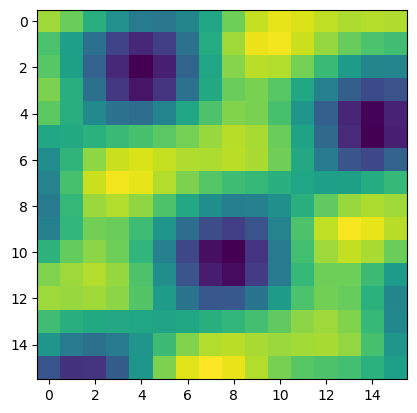



*************
 window number 105: 16 16




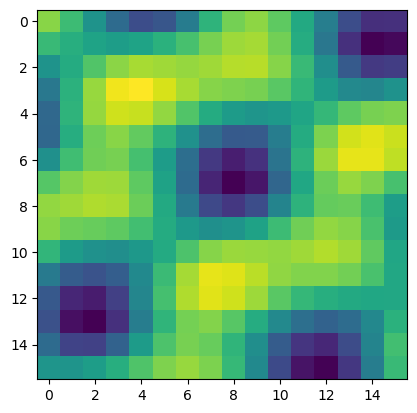



*************
 window number 106: 16 16




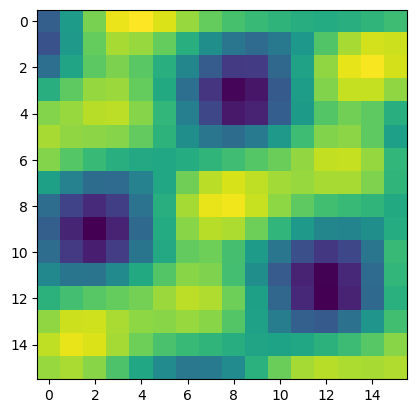



*************
 window number 107: 16 16




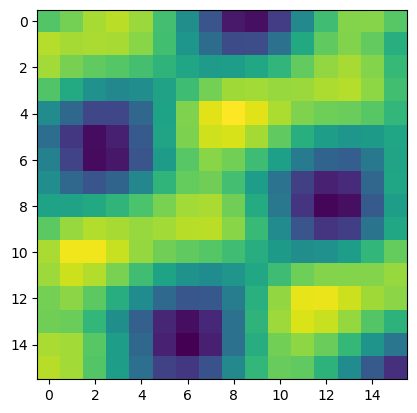



*************
 window number 108: 16 16




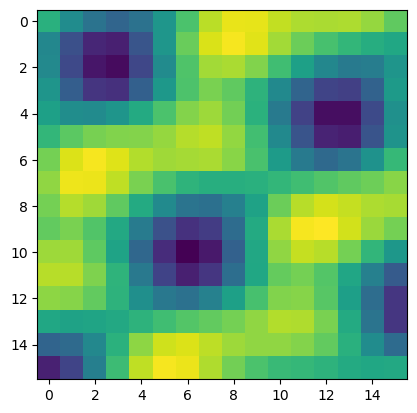



*************
 window number 109: 16 16




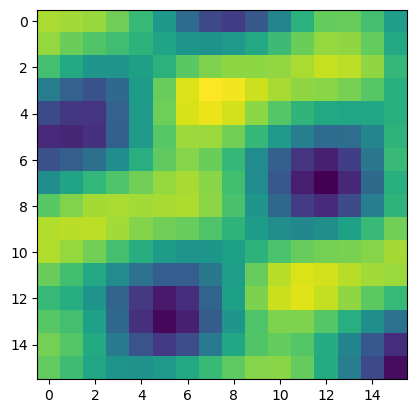



*************
 window number 110: 16 16




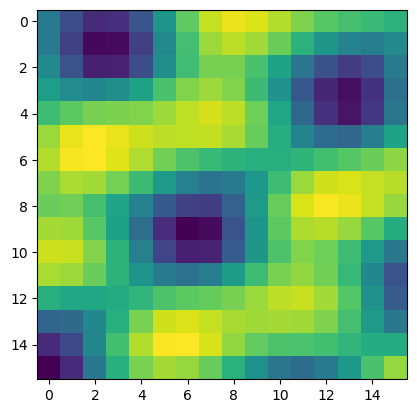



*************
 window number 111: 16 16




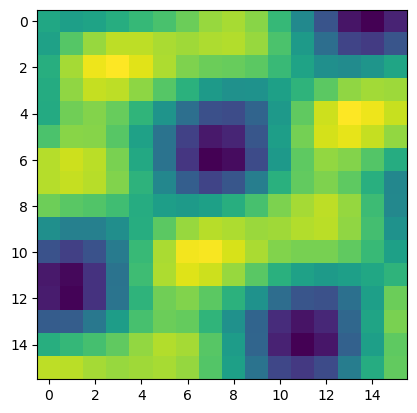



*************
 window number 112: 16 16




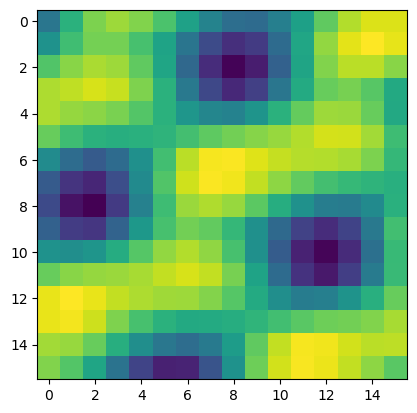



*************
 window number 113: 16 16




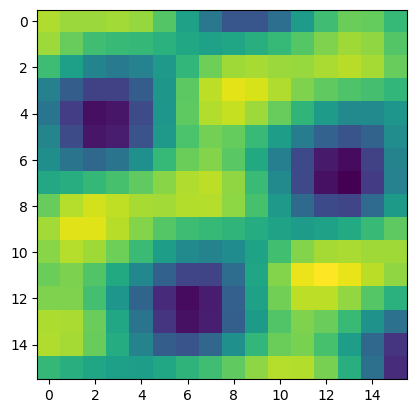



*************
 window number 114: 16 16




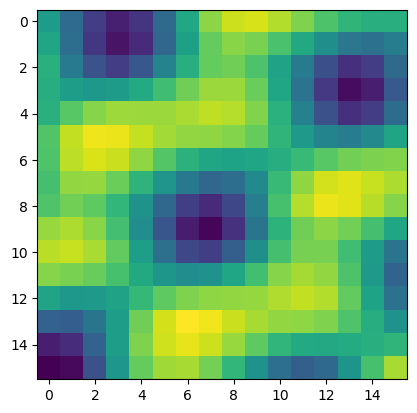



*************
 window number 115: 16 16




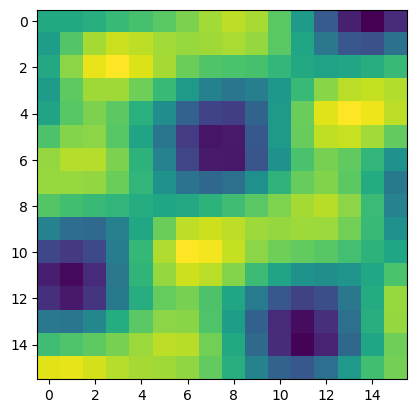



*************
 window number 116: 16 16




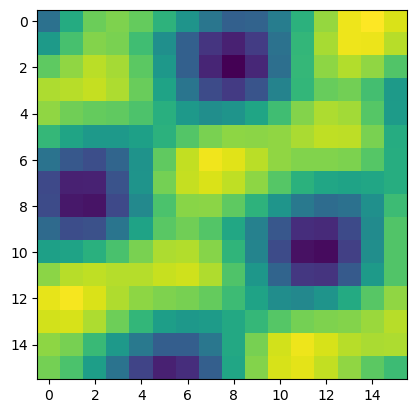



*************
 window number 117: 16 16




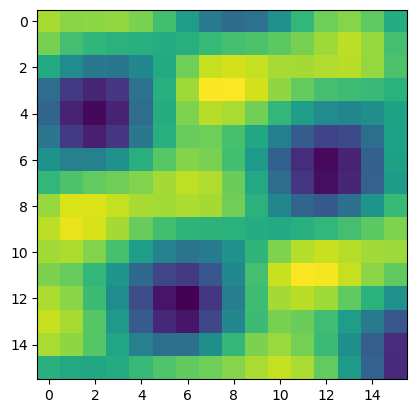



*************
 window number 118: 16 16




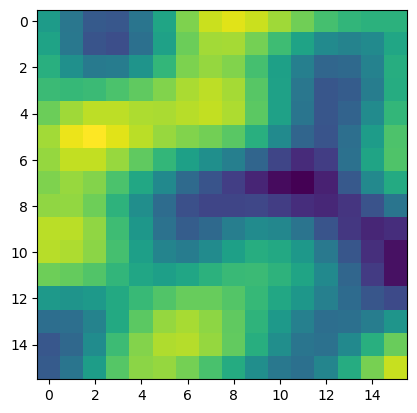



*************
 window number 119: 16 16




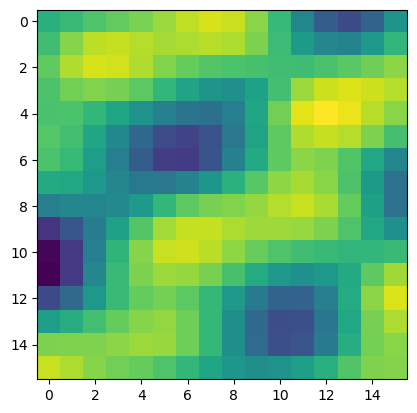



*************
 window number 120: 16 16




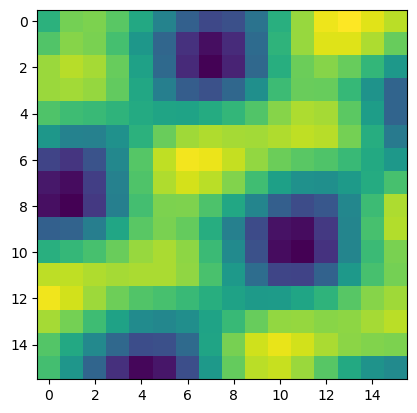



*************
 window number 121: 16 16




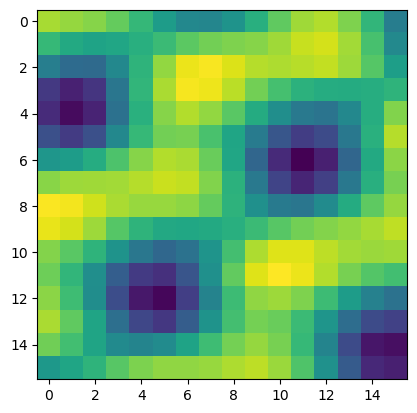



*************
 window number 122: 16 16




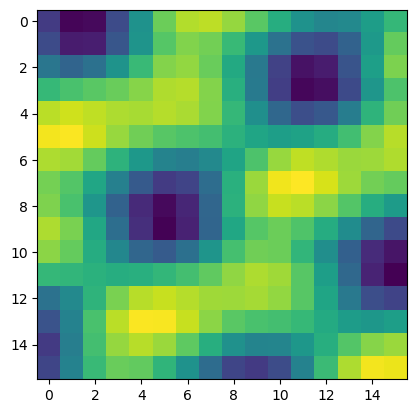



*************
 window number 123: 16 16




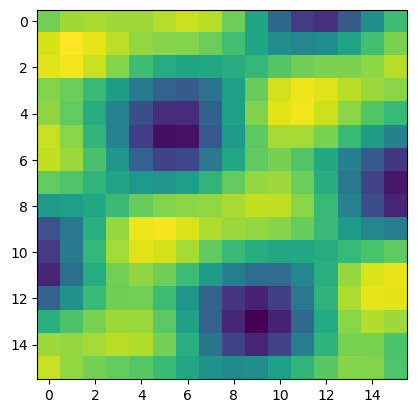



*************
 window number 124: 16 16




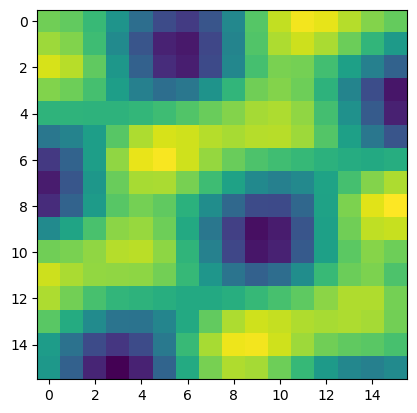



*************
 window number 125: 16 16




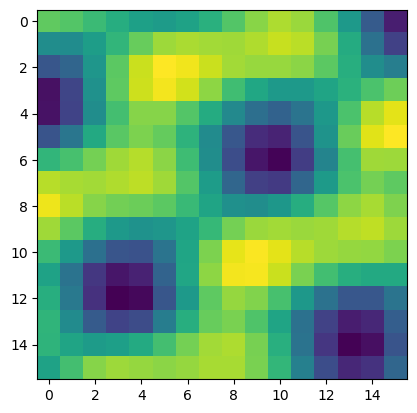



*************
 window number 126: 16 16




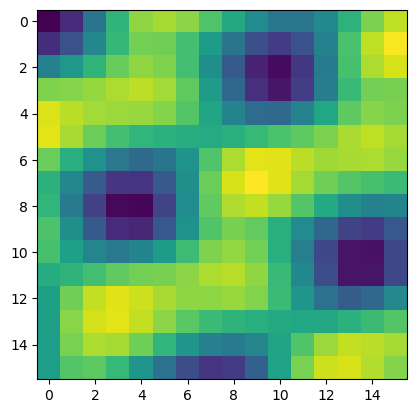



*************
 window number 127: 16 16




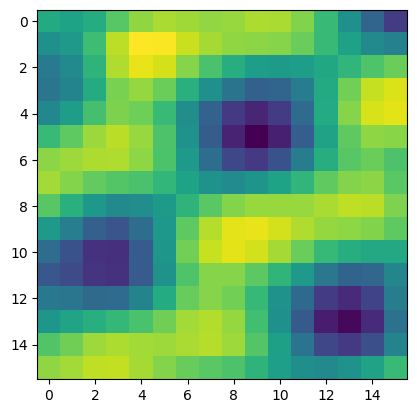



*************
 window number 128: 16 16




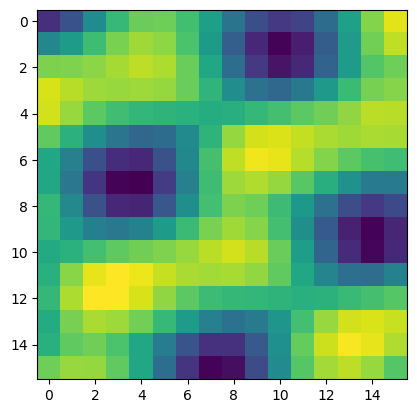



*************
 window number 129: 16 16




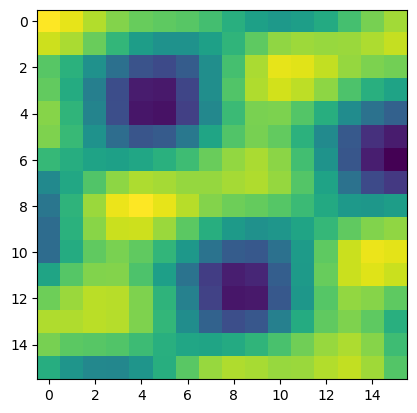



*************
 window number 130: 16 16




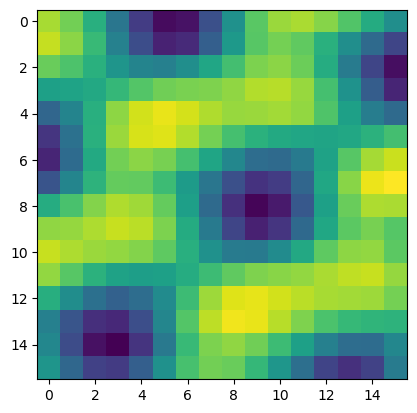



*************
 window number 131: 16 16




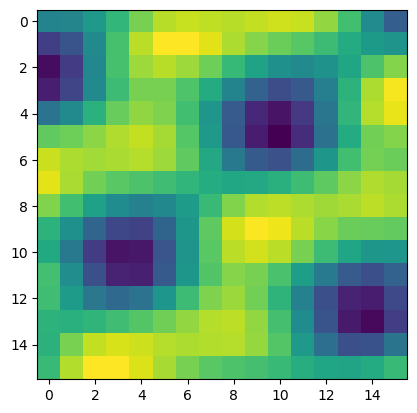



*************
 window number 132: 16 16




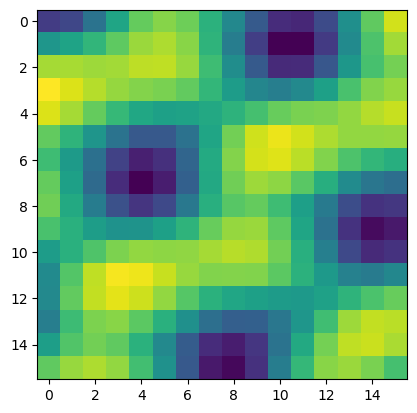



*************
 window number 133: 16 16




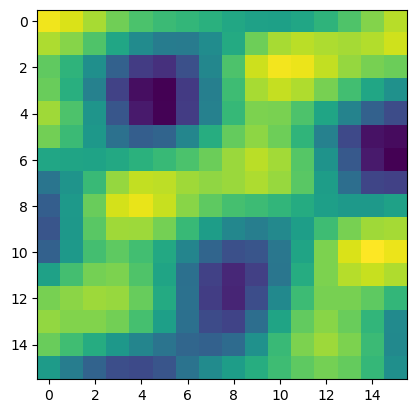



*************
 window number 134: 16 16




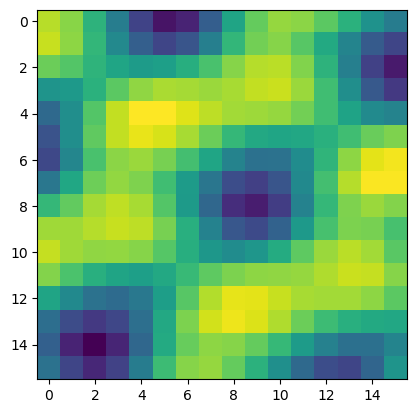



*************
 window number 135: 16 16




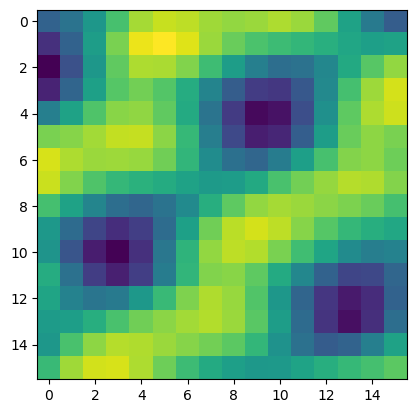



*************
 window number 136: 16 16




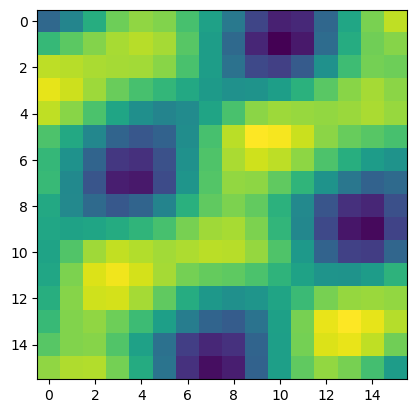



*************
 window number 137: 16 16




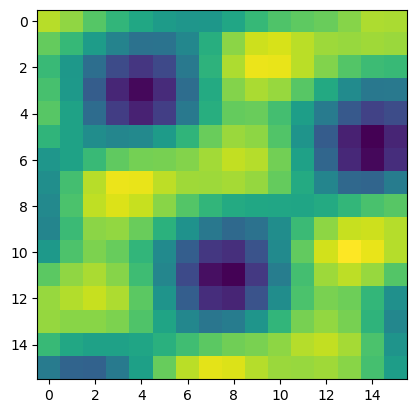



*************
 window number 138: 16 16




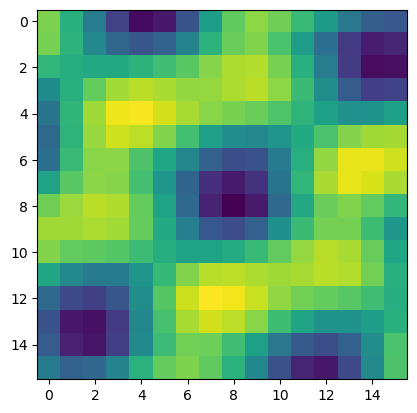



*************
 window number 139: 16 16




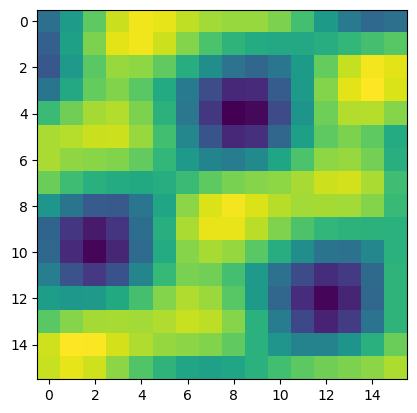



*************
 window number 140: 16 16




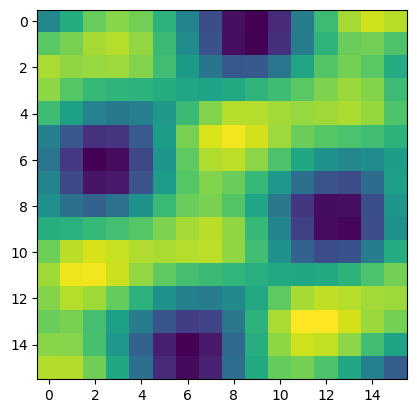



*************
 window number 141: 16 16




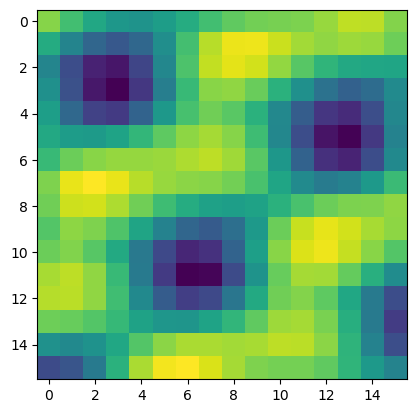



*************
 window number 142: 16 16




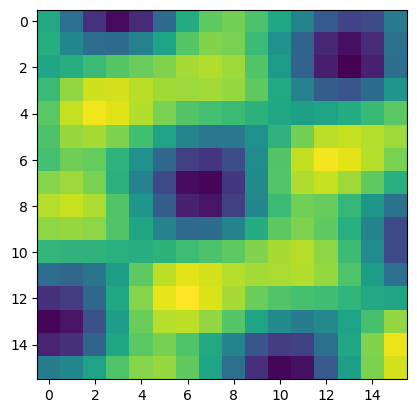



*************
 window number 143: 16 16




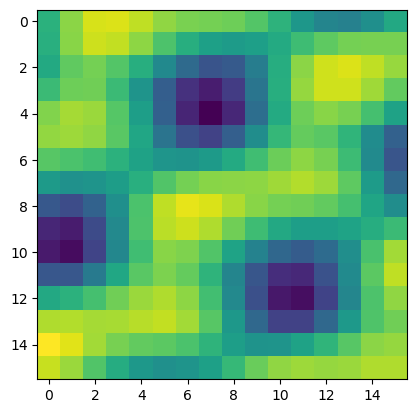



*************
 window number 144: 16 16




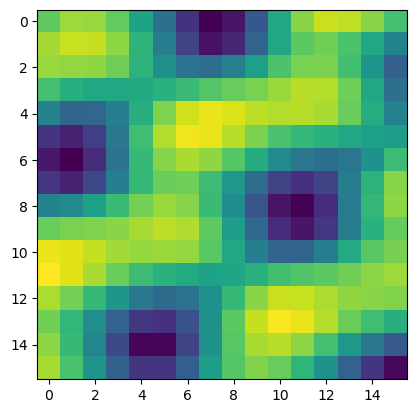



*************
 window number 145: 16 16




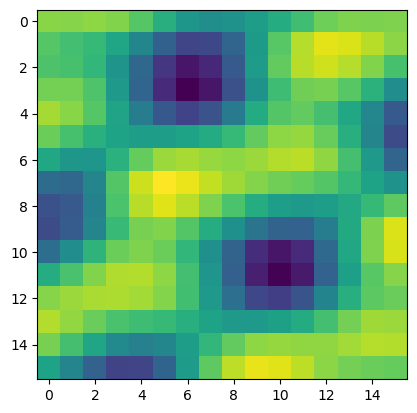



*************
 window number 146: 16 16




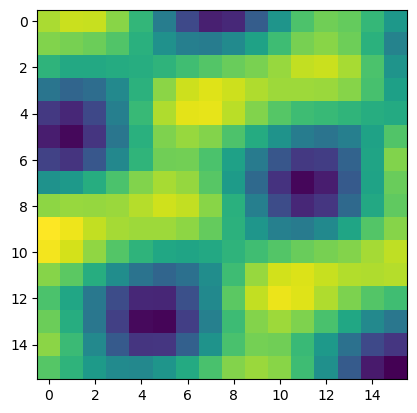



*************
 window number 147: 16 16




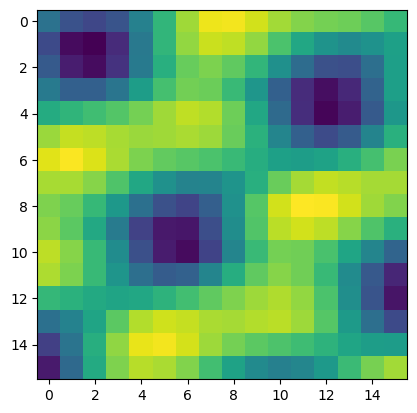



*************
 window number 148: 16 16




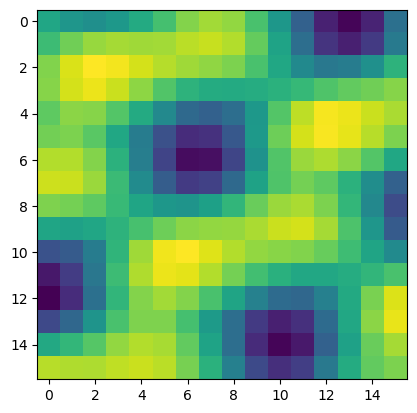



*************
 window number 149: 16 16




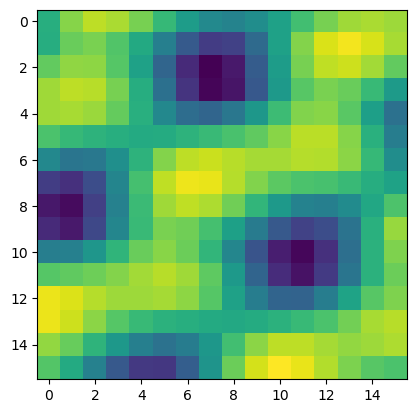



*************
 window number 150: 16 16




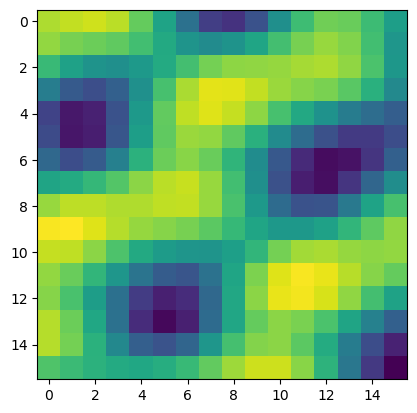



*************
 window number 151: 16 16




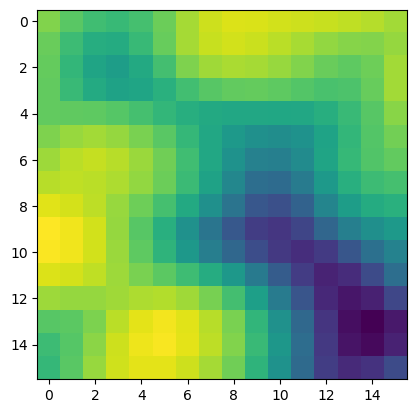



*************
 window number 152: 16 16




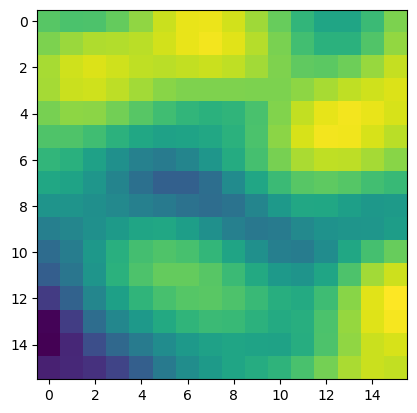



*************
 window number 153: 16 16




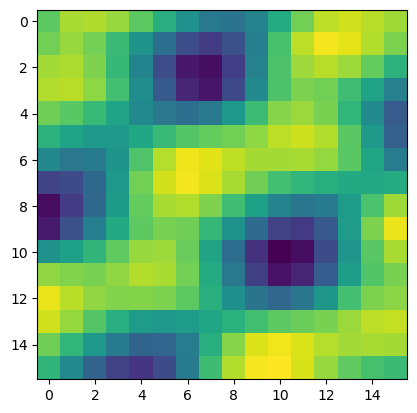



*************
 window number 154: 16 16




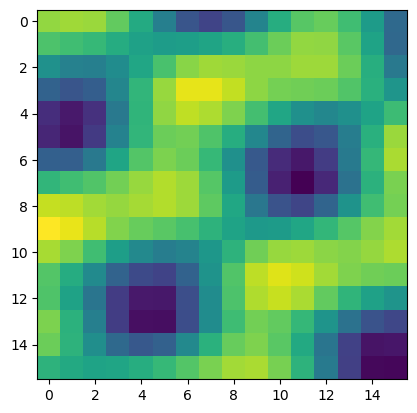



*************
 window number 155: 16 16




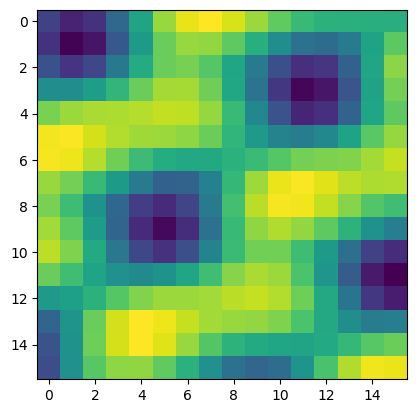



*************
 window number 156: 16 16




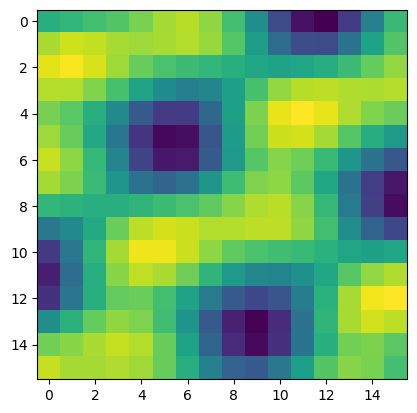



*************
 window number 157: 16 16




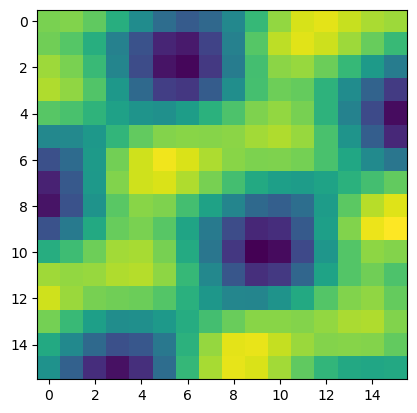



*************
 window number 158: 16 16




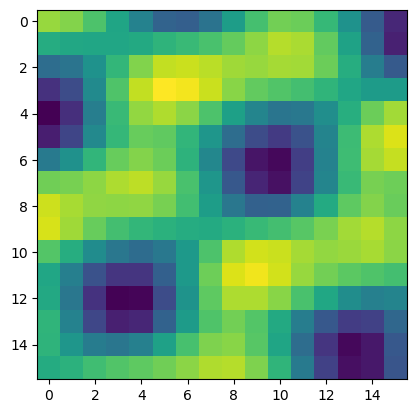



*************
 window number 159: 16 16




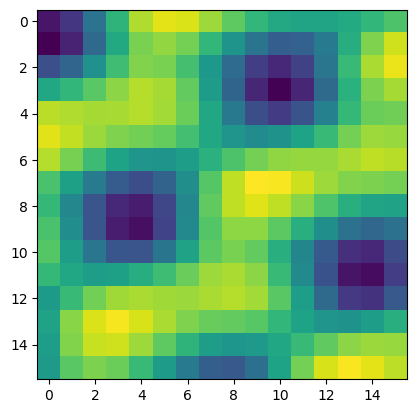



*************
 window number 160: 16 16




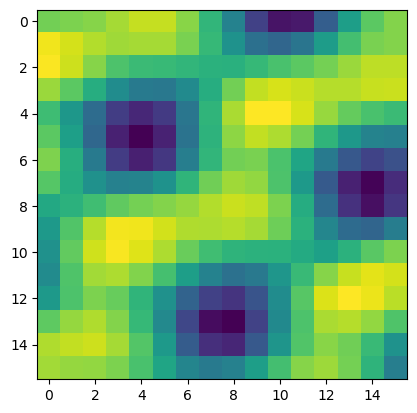



*************
 window number 161: 16 16




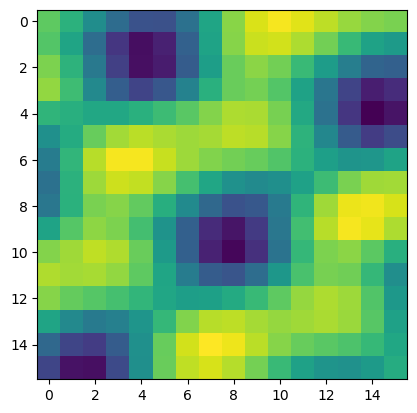



*************
 window number 162: 16 16




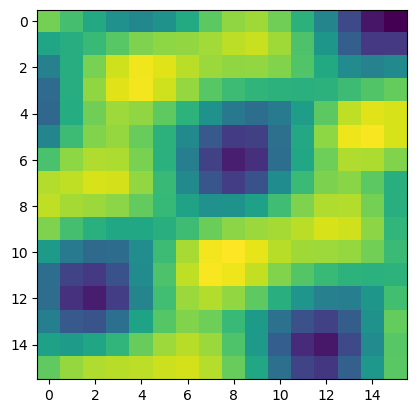



*************
 window number 163: 16 16




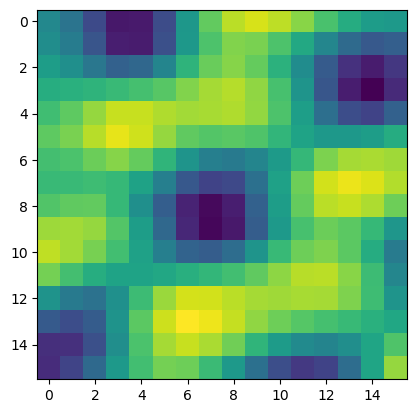



*************
 window number 164: 16 16




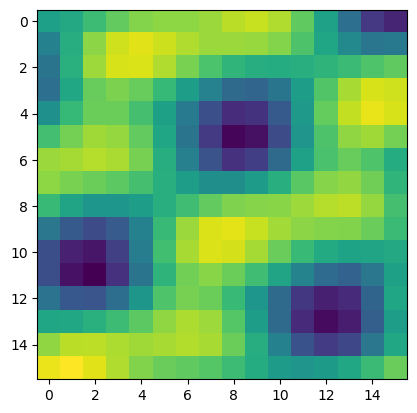



*************
 window number 165: 16 16




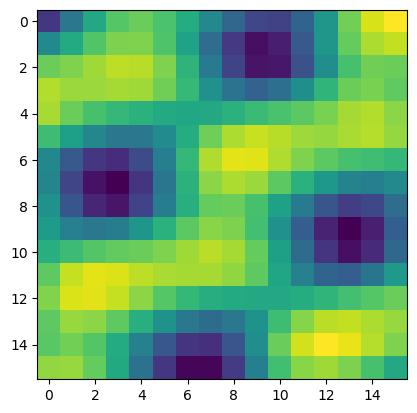



*************
 window number 166: 16 16




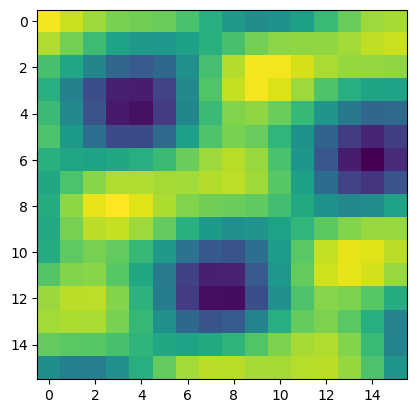



*************
 window number 167: 16 16




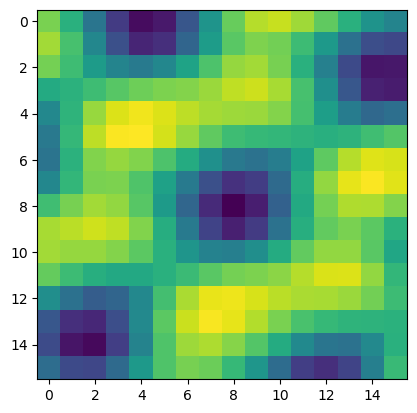



*************
 window number 168: 16 16




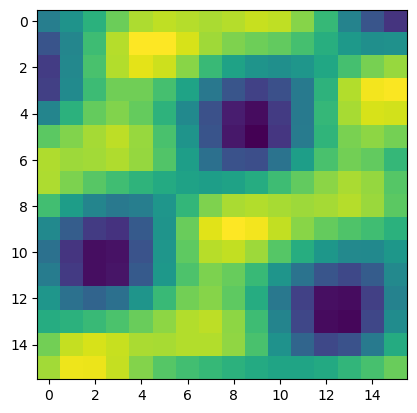



*************
 window number 169: 16 16




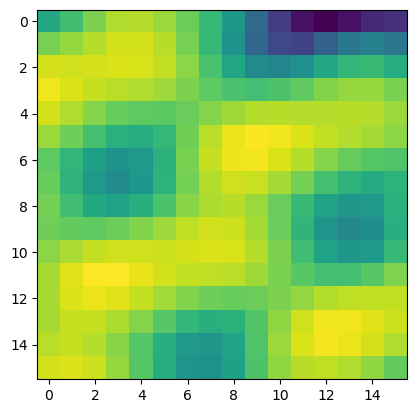



*************
 window number 170: 16 16




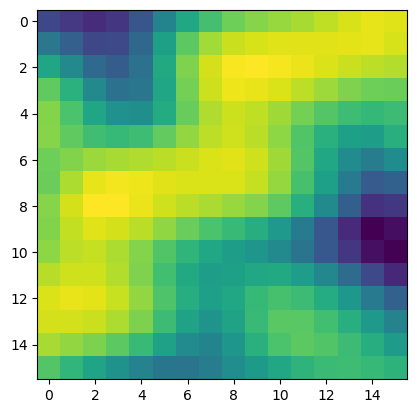



*************
 window number 171: 16 16




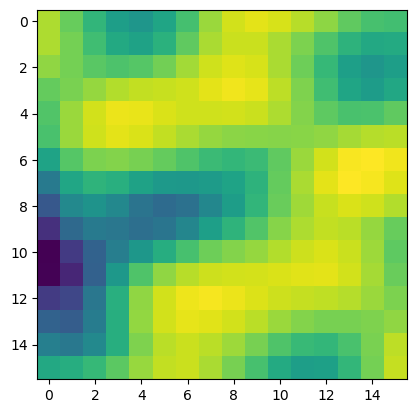



*************
 window number 172: 16 16




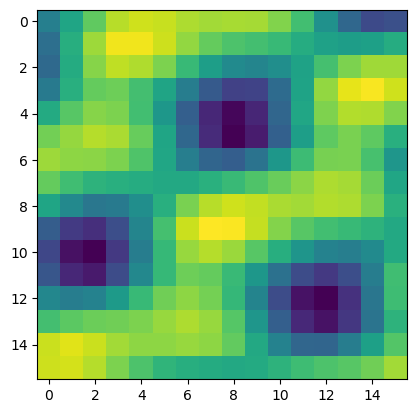



*************
 window number 173: 16 16




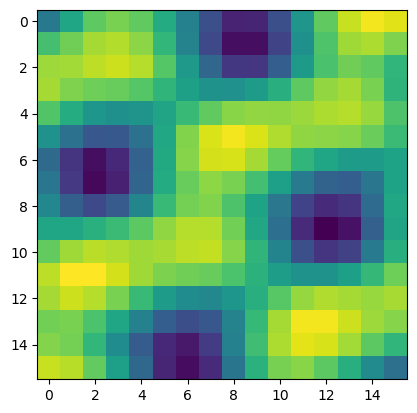



*************
 window number 174: 16 16




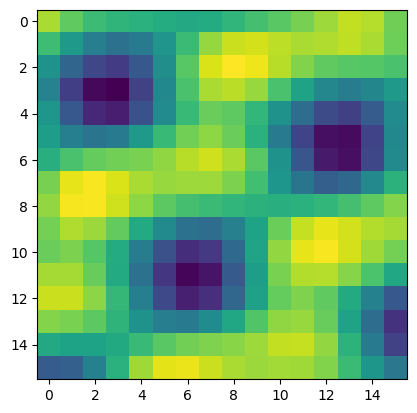



*************
 window number 175: 16 16




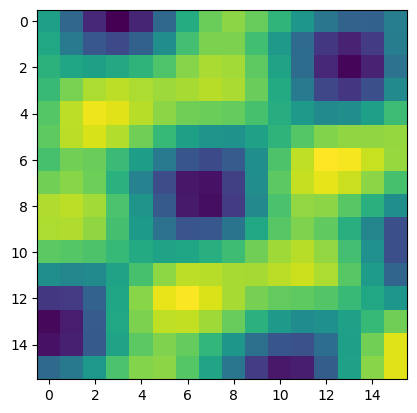



*************
 window number 176: 16 16




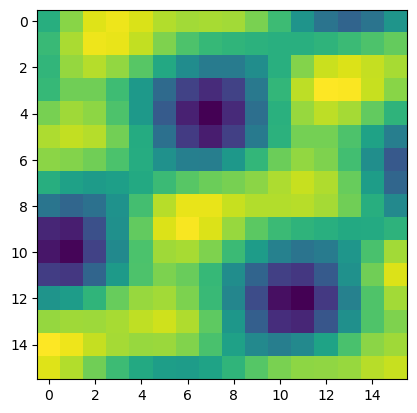



*************
 window number 177: 16 16




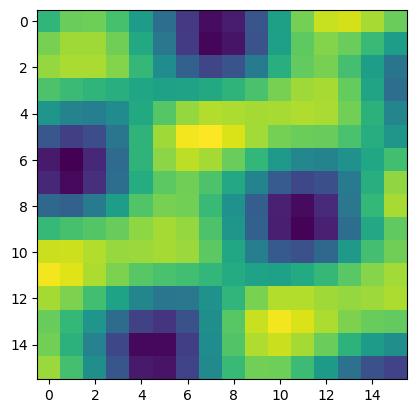



*************
 window number 178: 16 16




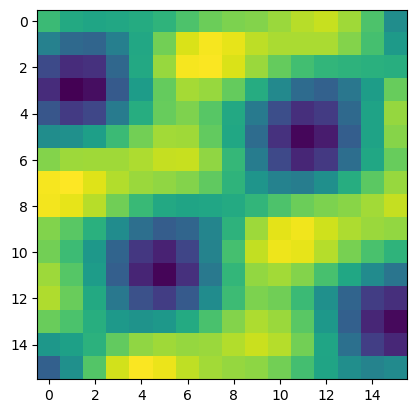



*************
 window number 179: 16 16




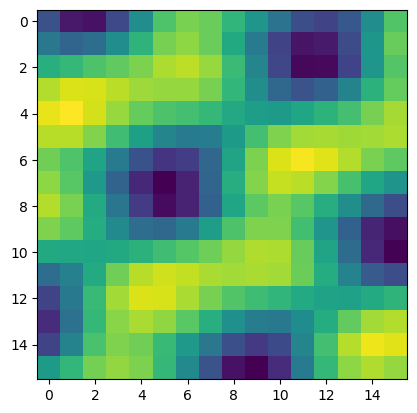



*************
 window number 180: 16 16




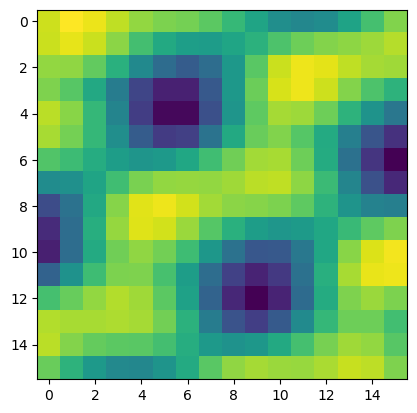



*************
 window number 181: 16 16




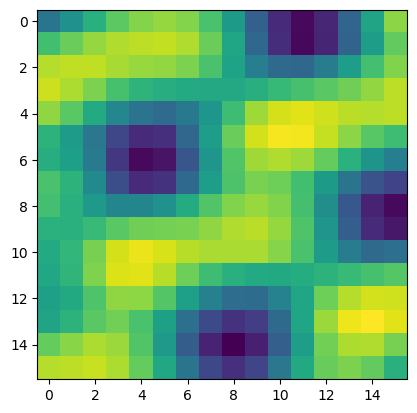



*************
 window number 182: 16 16




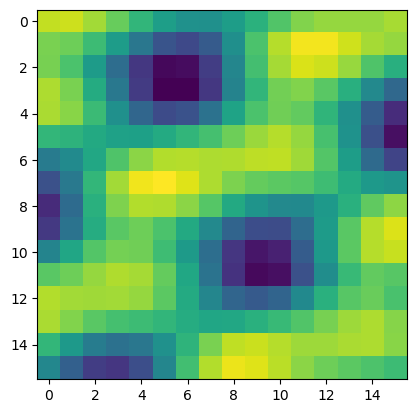



*************
 window number 183: 16 16




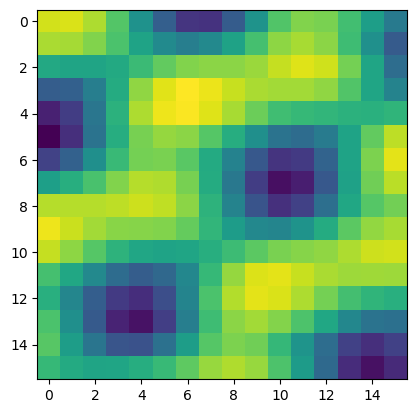



*************
 window number 184: 16 16




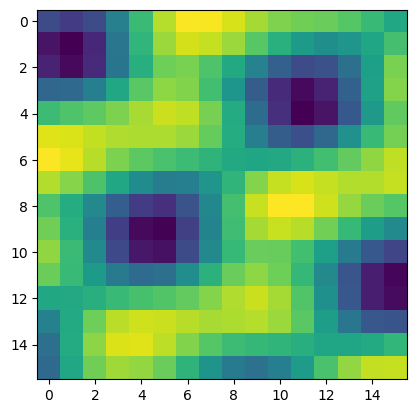



*************
 window number 185: 16 16




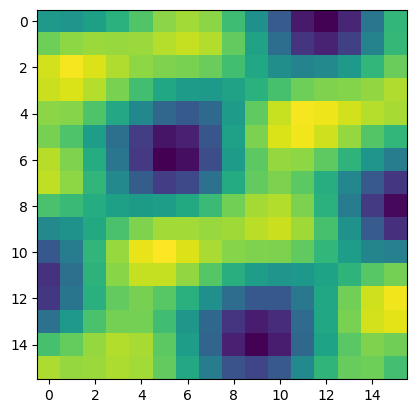



*************
 window number 186: 16 16




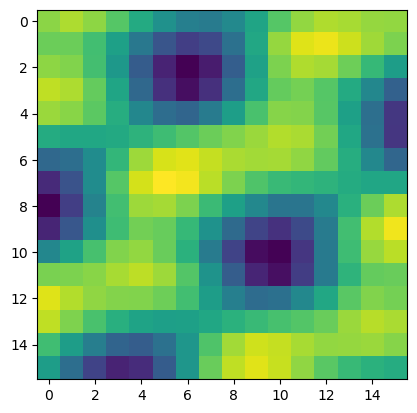



*************
 window number 187: 16 16




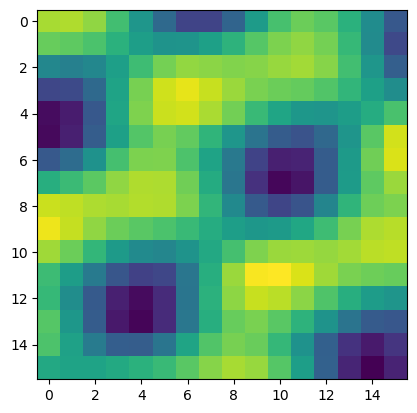



*************
 window number 188: 16 16




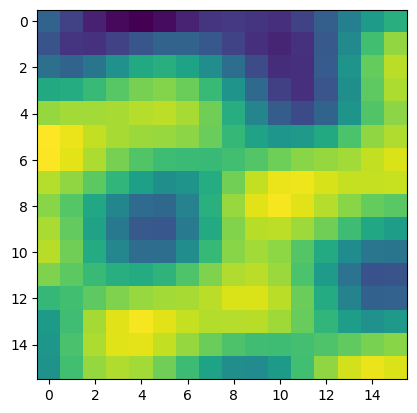



*************
 window number 189: 16 16




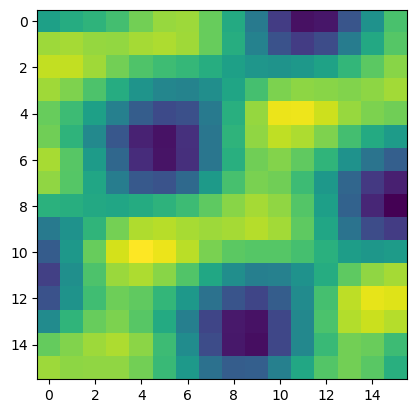



*************
 window number 190: 16 16




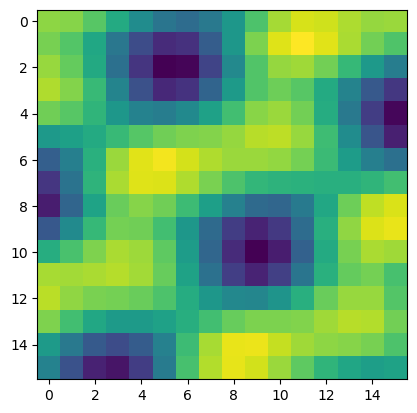



*************
 window number 191: 16 16




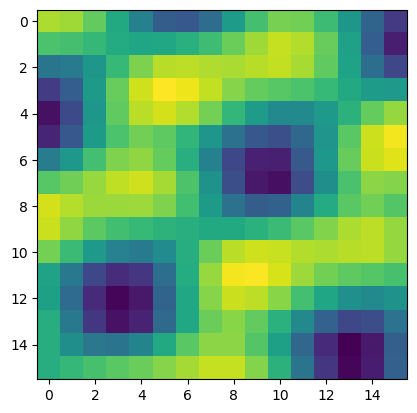



*************
 window number 192: 16 16




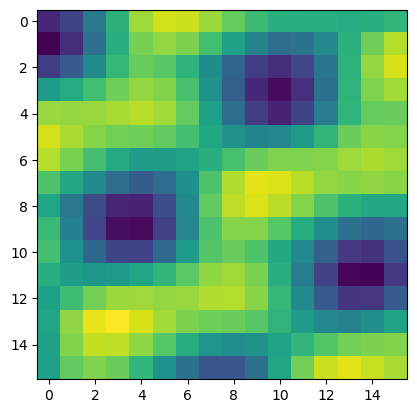



*************
 window number 193: 16 16




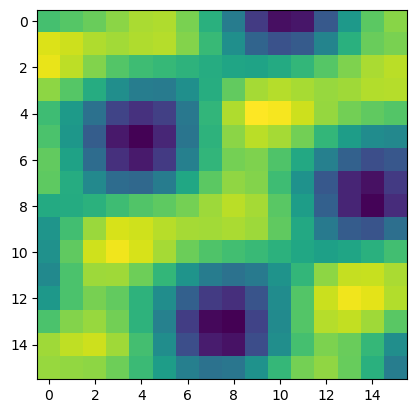



*************
 window number 194: 16 16




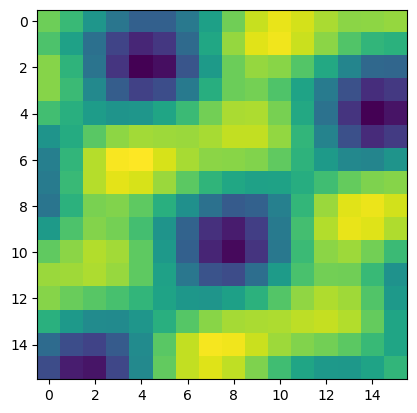



*************
 window number 195: 16 16




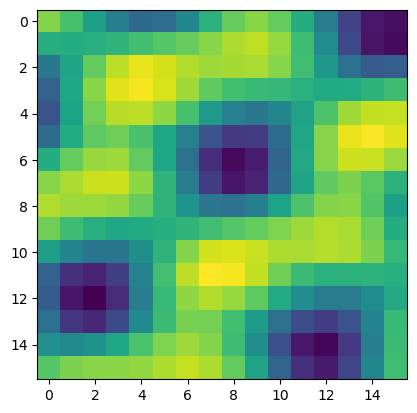



*************
 window number 196: 16 16




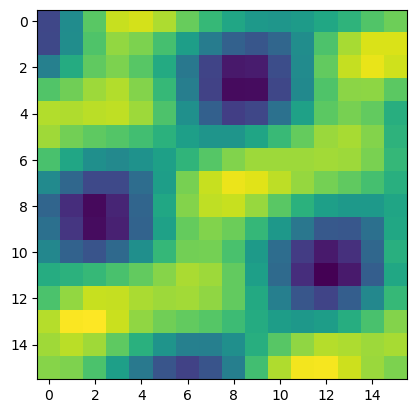



*************
 window number 197: 16 16




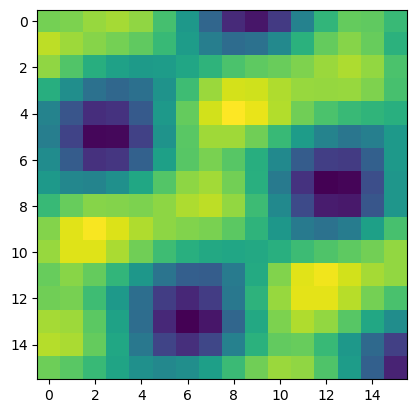



*************
 window number 198: 16 16




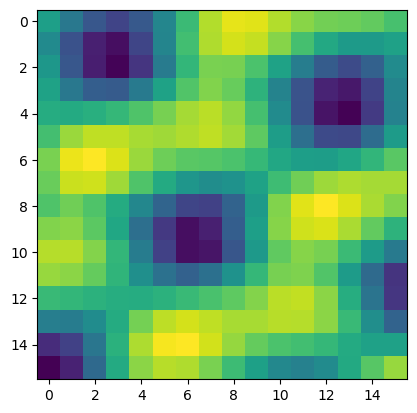



*************
 window number 199: 16 16




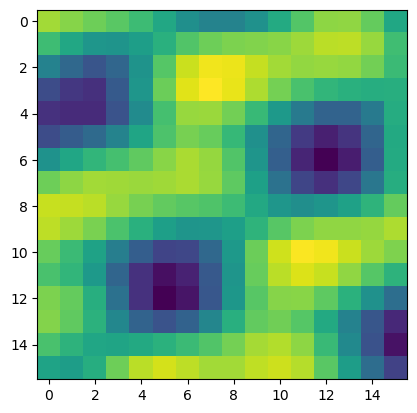



*************
 window number 200: 16 16




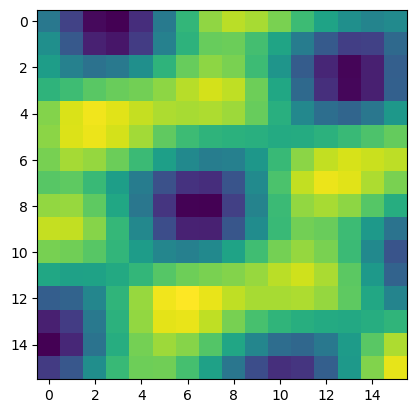



*************
 window number 201: 16 16




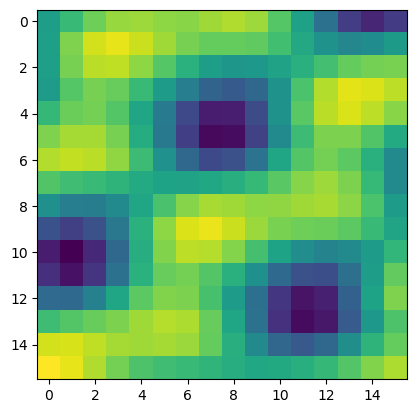



*************
 window number 202: 16 16




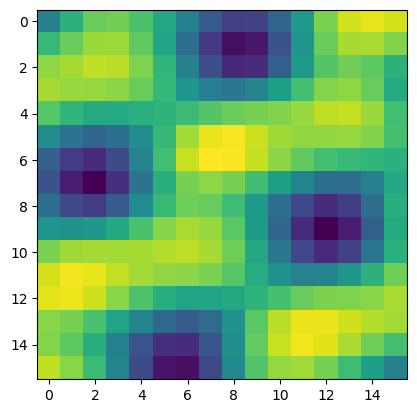



*************
 window number 203: 16 16




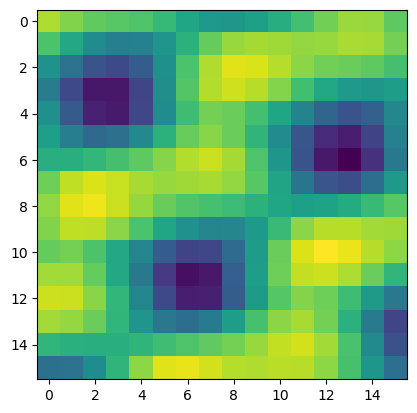



*************
 window number 204: 16 16




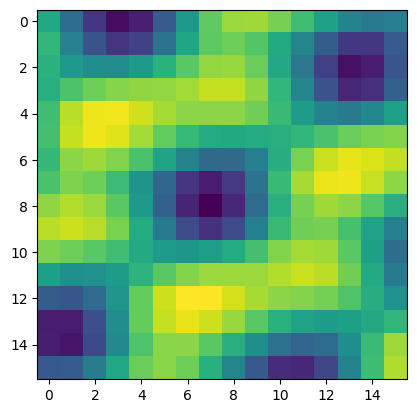



*************
 window number 205: 16 16




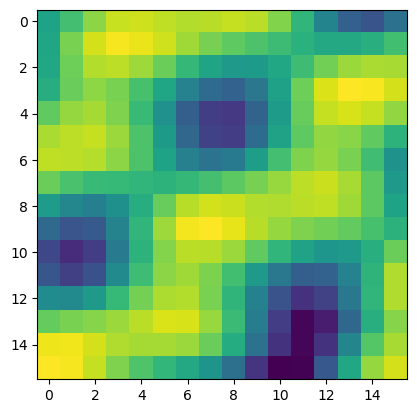



*************
 window number 206: 16 16




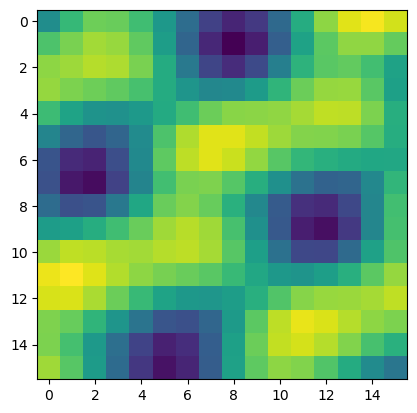



*************
 window number 207: 16 16




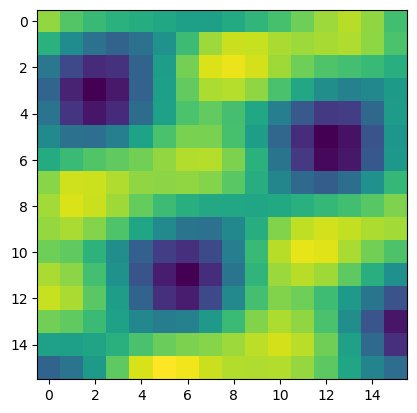



*************
 window number 208: 16 16




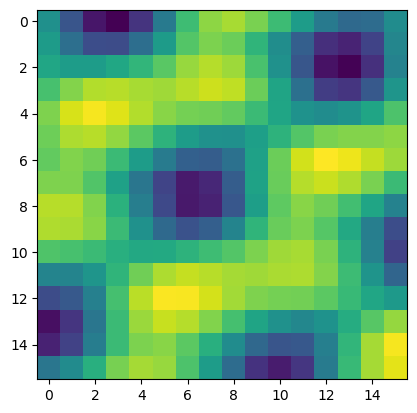



*************
 window number 209: 16 16




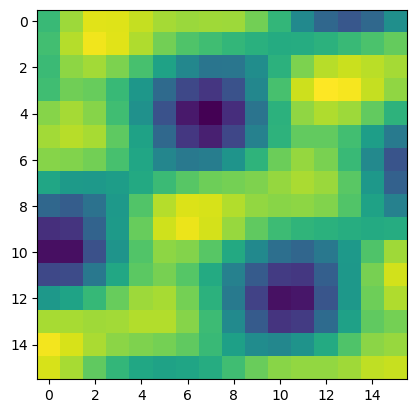



*************
 window number 210: 16 16




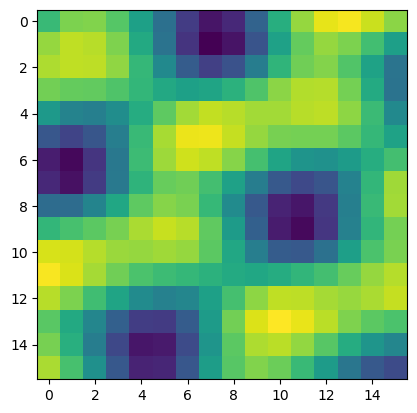



*************
 window number 211: 16 16




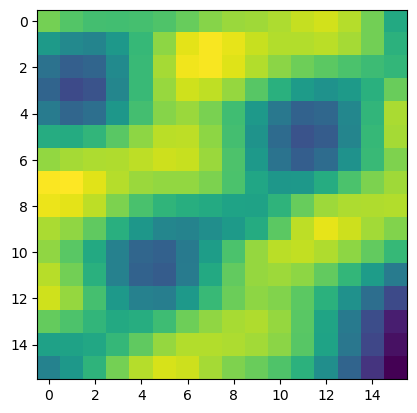



*************
 window number 212: 16 16




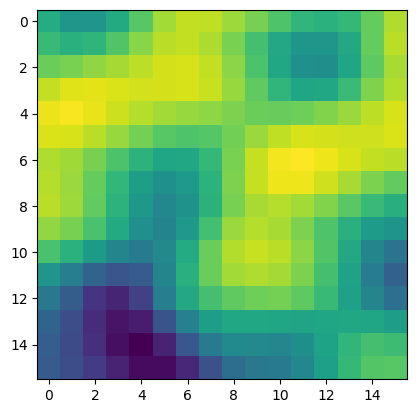



*************
 window number 213: 16 16




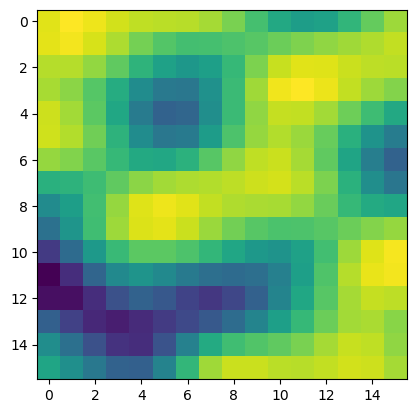



*************
 window number 214: 16 16




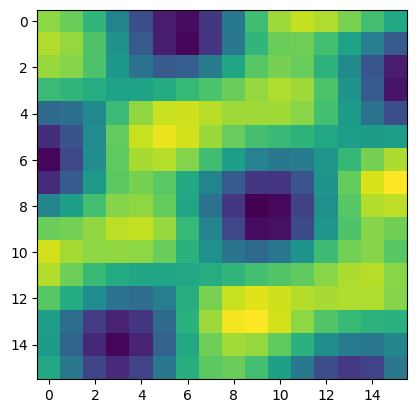



*************
 window number 215: 16 16




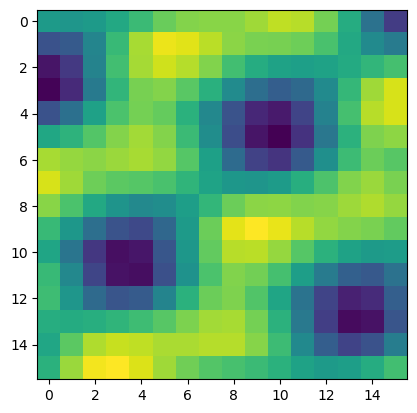



*************
 window number 216: 16 16




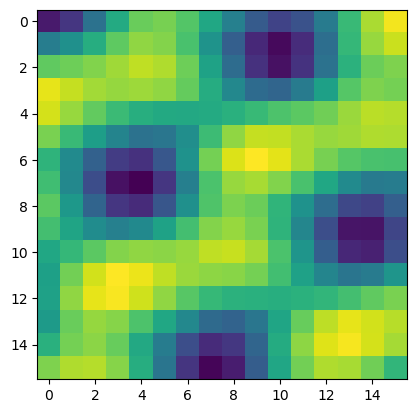



*************
 window number 217: 16 16




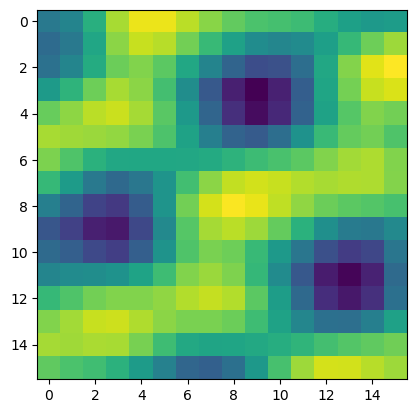



*************
 window number 218: 16 16




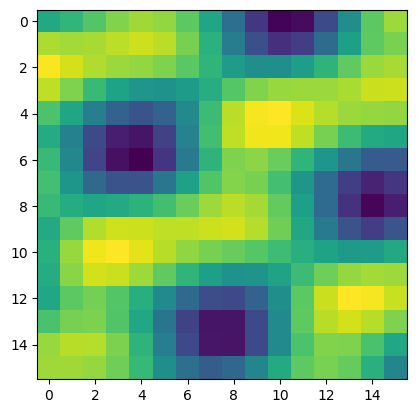



*************
 window number 219: 16 16




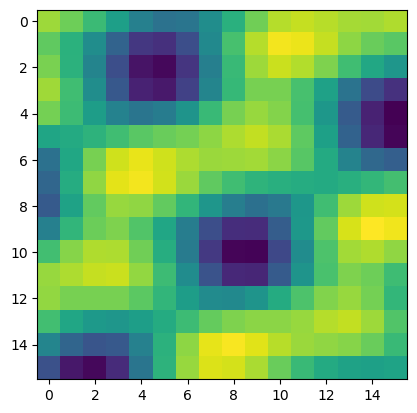



*************
 window number 220: 16 16




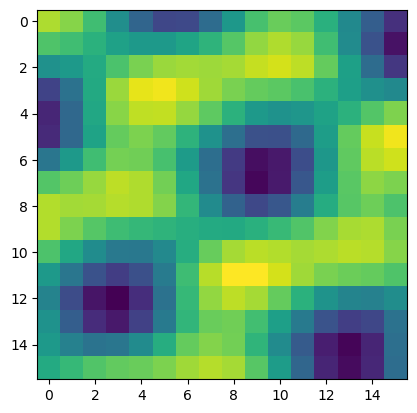



*************
 window number 221: 16 16




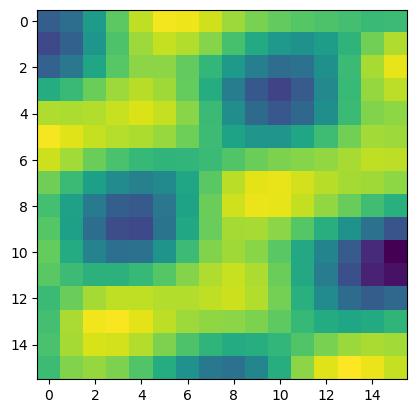



*************
 window number 222: 16 16




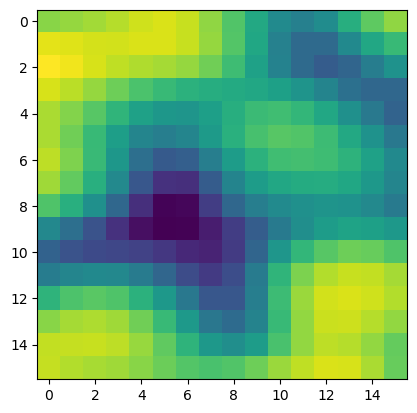



*************
 window number 223: 16 16




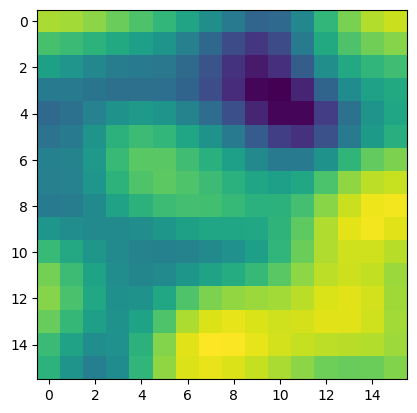



*************
 window number 224: 16 16




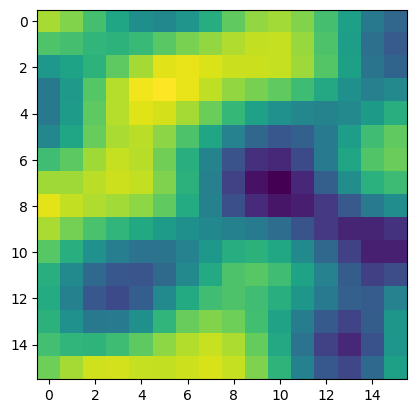



*************
 window number 225: 16 16




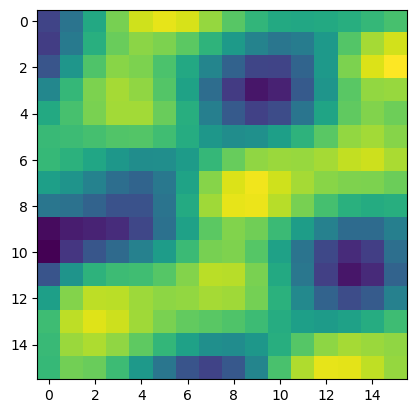



*************
 window number 226: 16 16




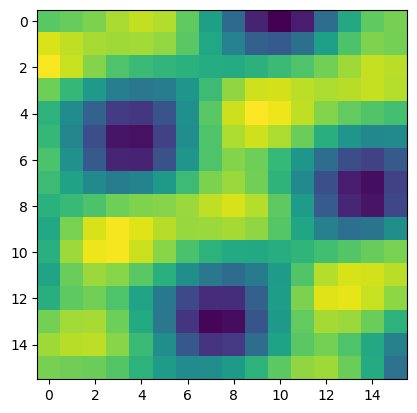



*************
 window number 227: 16 16




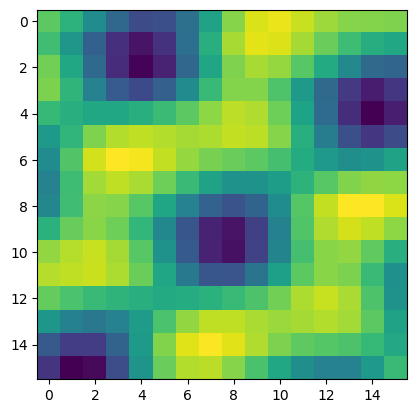



*************
 window number 228: 16 16




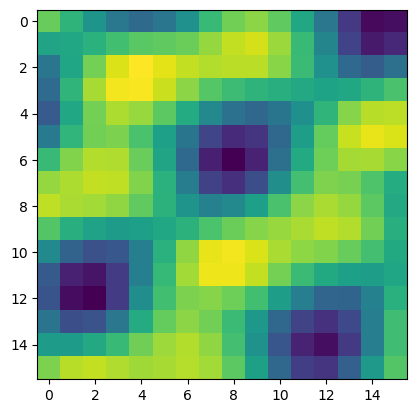



*************
 window number 229: 16 16




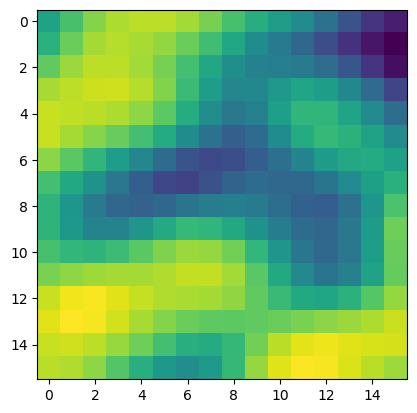



*************
 window number 230: 16 16




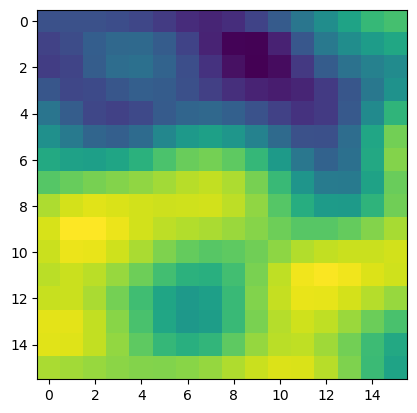



*************
 window number 231: 16 16




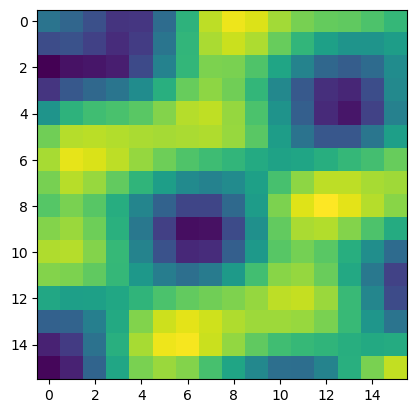



*************
 window number 232: 16 16




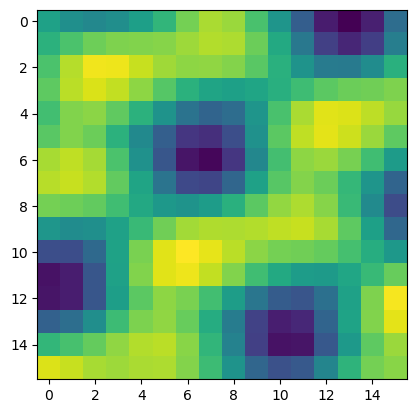



*************
 window number 233: 16 16




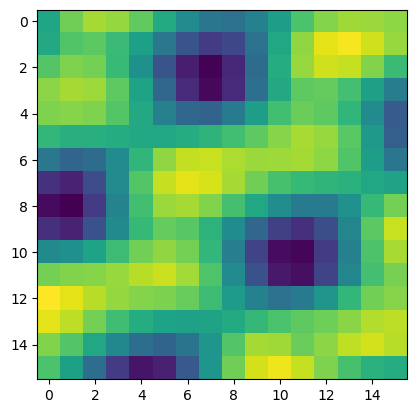



*************
 window number 234: 16 16




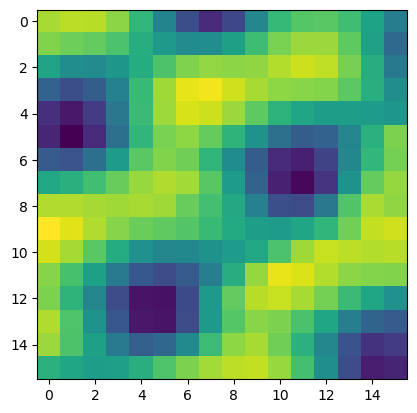



*************
 window number 235: 16 16




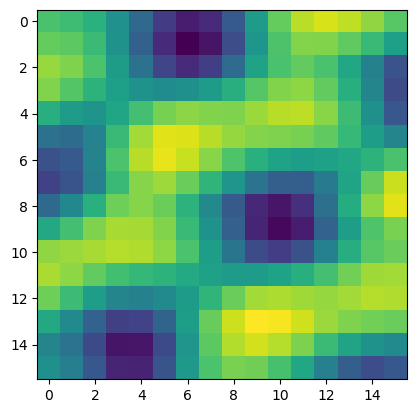



*************
 window number 236: 16 16




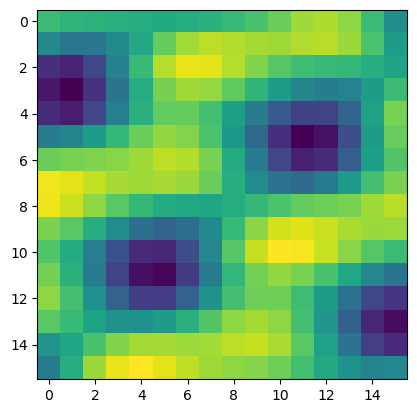



*************
 window number 237: 16 16




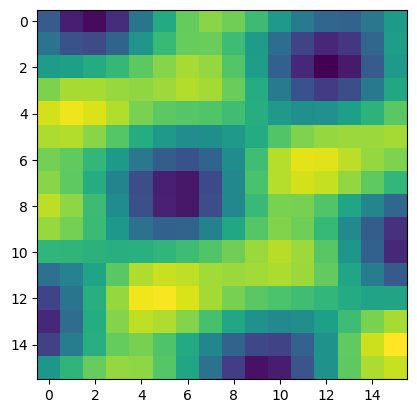



*************
 window number 238: 16 16




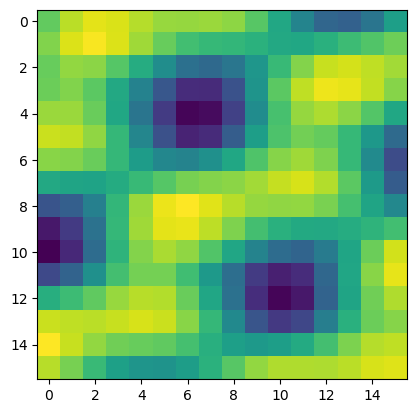



*************
 window number 239: 16 16




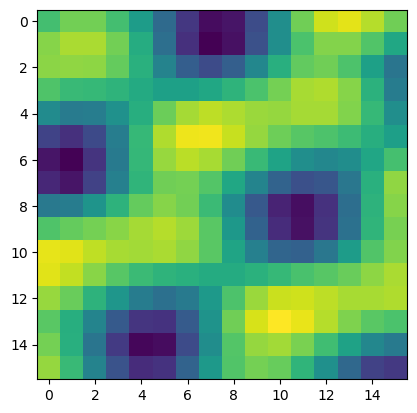



*************
 window number 240: 16 16




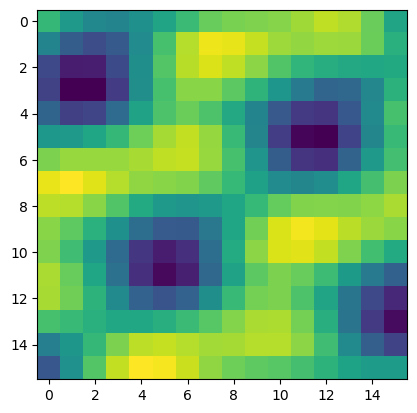



*************
 window number 241: 16 16




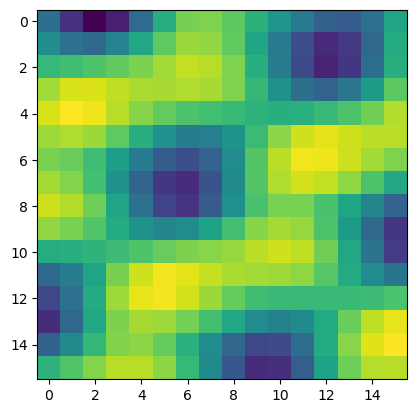



*************
 window number 242: 16 16




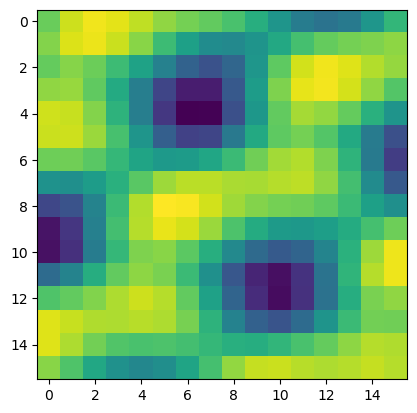



*************
 window number 243: 16 16




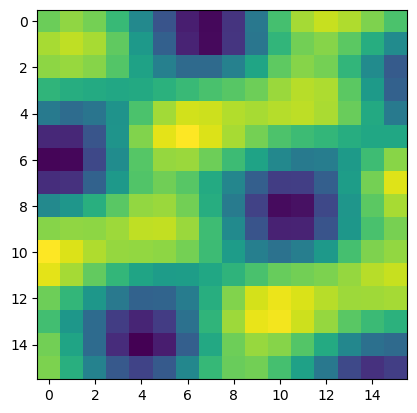



*************
 window number 244: 16 16




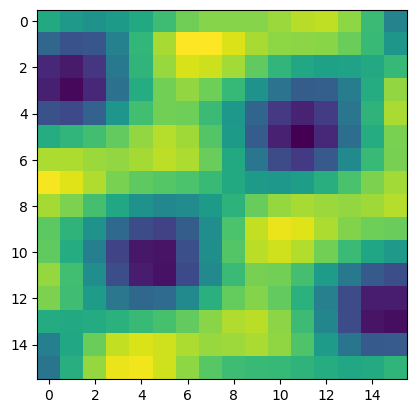



*************
 window number 245: 16 16




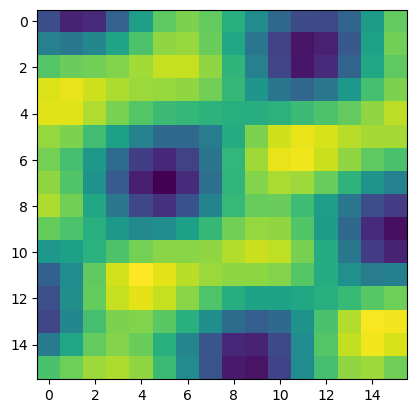



*************
 window number 246: 16 16




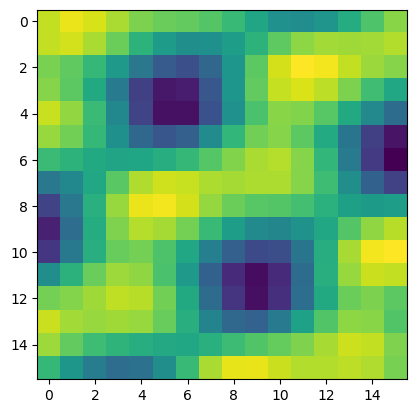



*************
 window number 247: 16 16




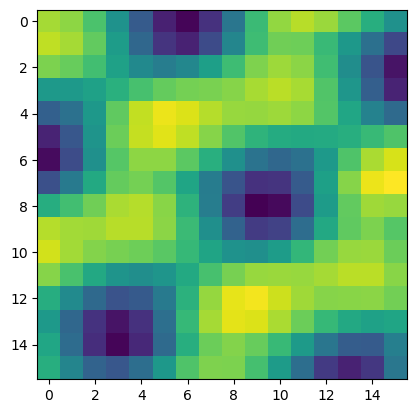



*************
 window number 248: 16 16




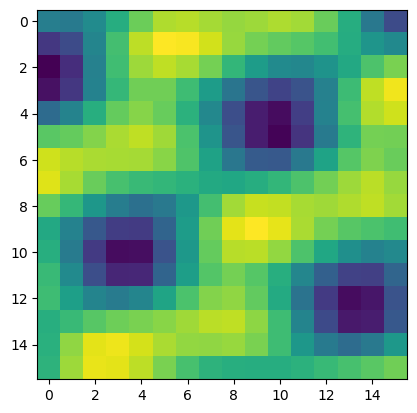



*************
 window number 249: 16 16




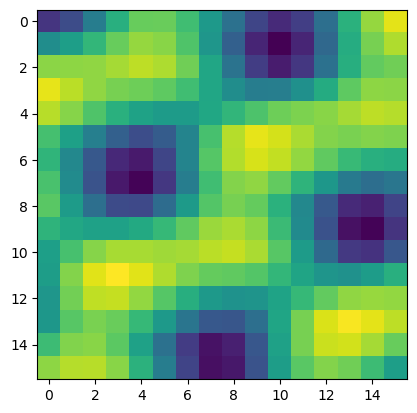



*************
 window number 250: 16 16




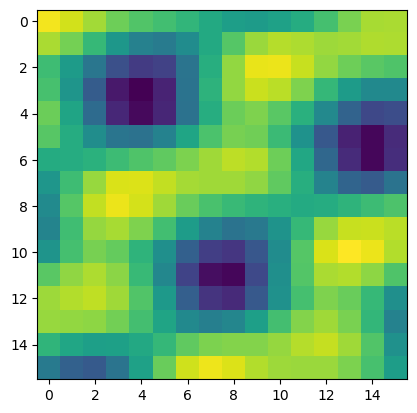



*************
 window number 251: 16 16




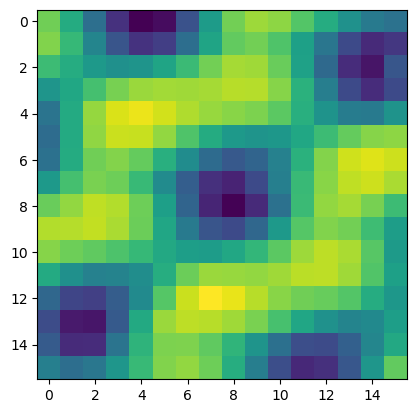



*************
 window number 252: 16 16




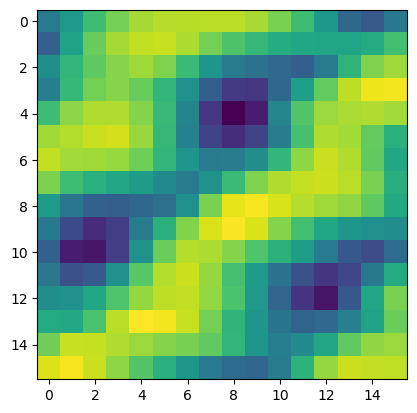



*************
 window number 253: 16 16




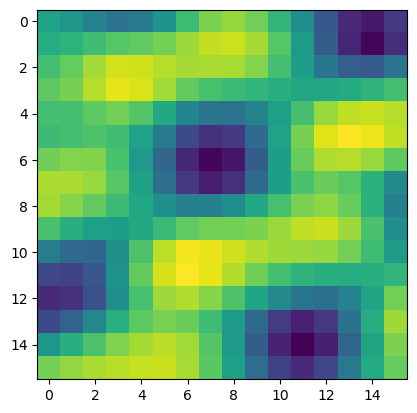



*************
 window number 254: 16 16




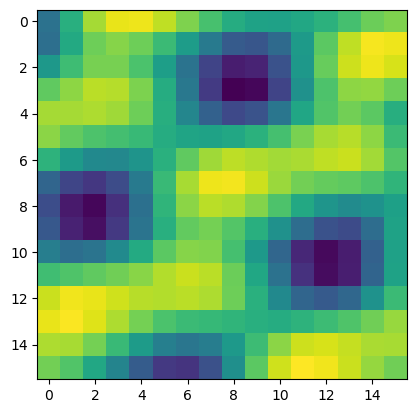



*************
 window number 255: 16 16




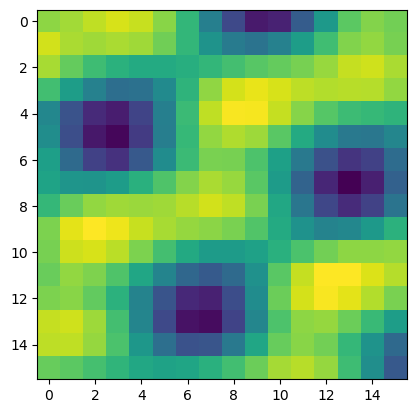



*************
 window number 256: 16 16




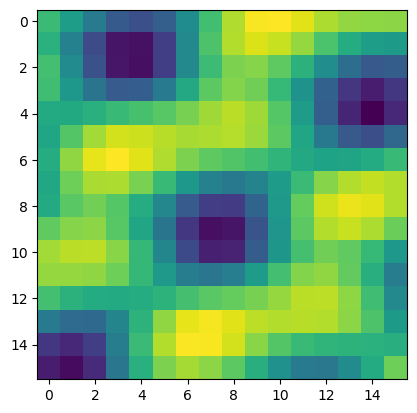



*************
 window number 257: 16 16




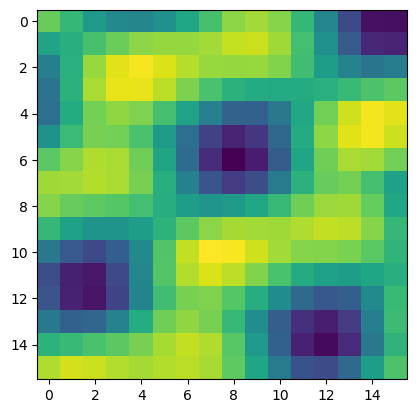



*************
 window number 258: 16 16




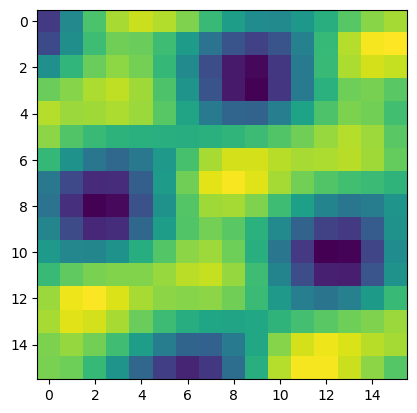



*************
 window number 259: 16 16




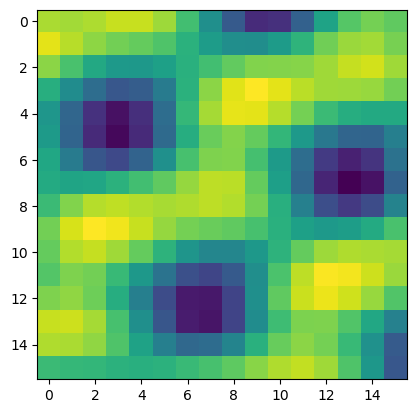



*************
 window number 260: 16 16




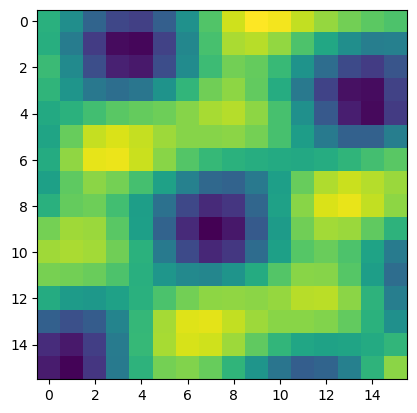



*************
 window number 261: 16 16




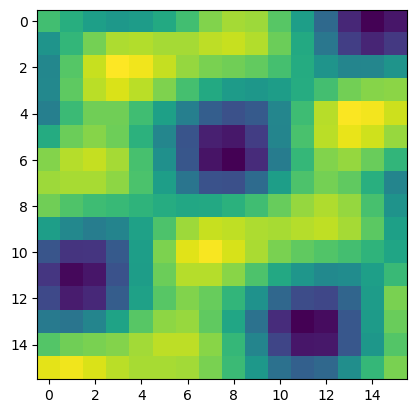



*************
 window number 262: 16 16




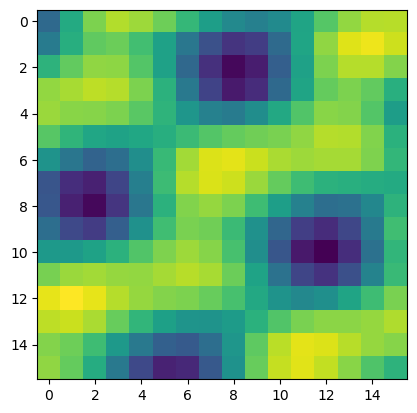



*************
 window number 263: 16 16




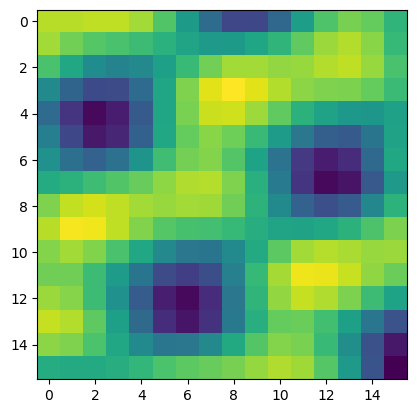



*************
 window number 264: 16 16




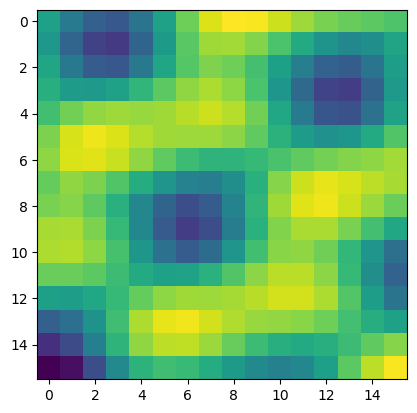



*************
 window number 265: 16 16




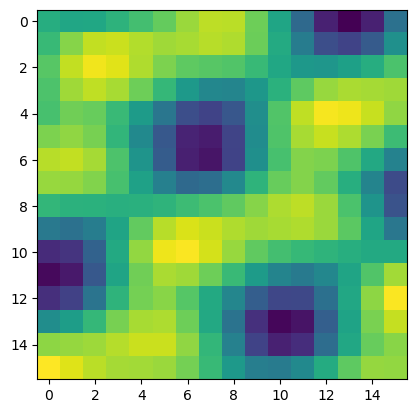



*************
 window number 266: 16 16




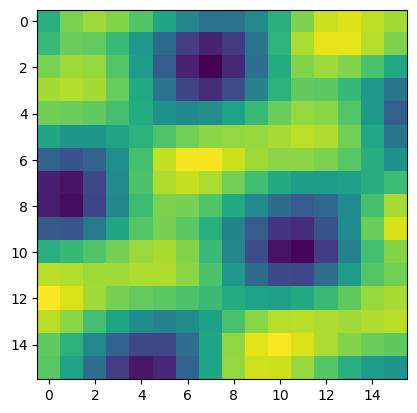



*************
 window number 267: 16 16




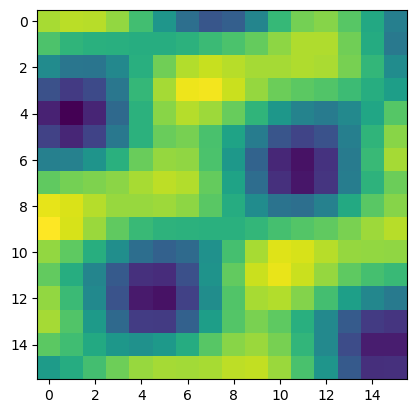



*************
 window number 268: 16 16




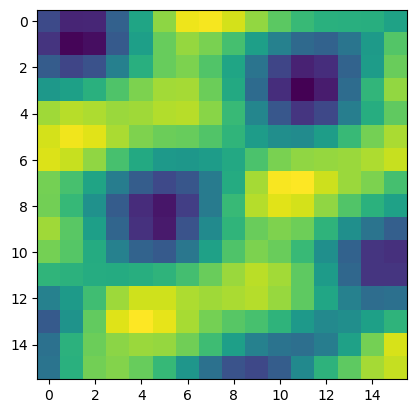



*************
 window number 269: 16 16




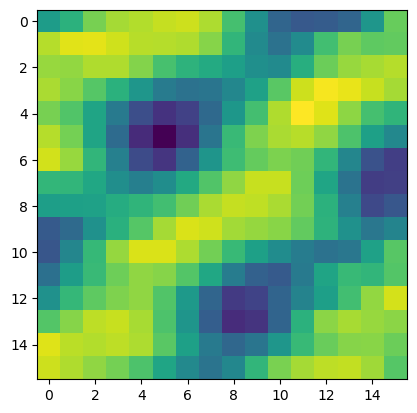



*************
 window number 270: 16 16




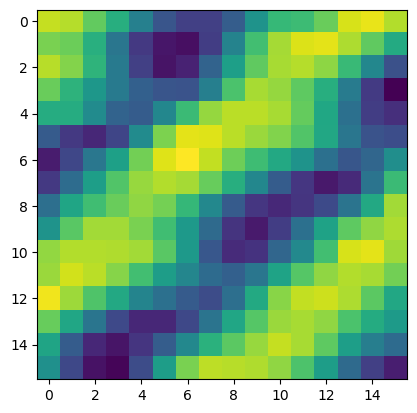



*************
 window number 271: 16 16




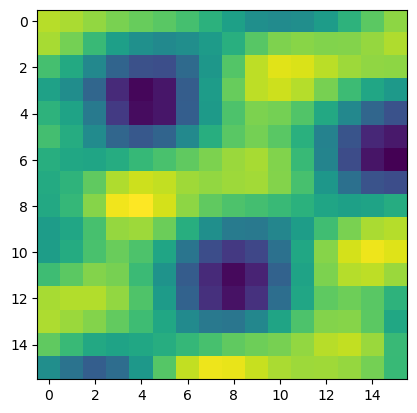



*************
 window number 272: 16 16




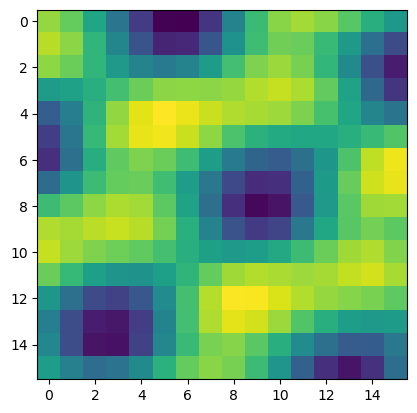



*************
 window number 273: 16 16




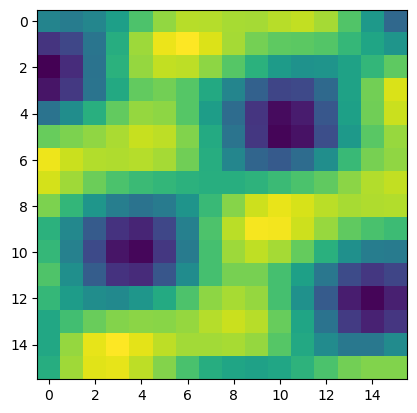



*************
 window number 274: 16 16




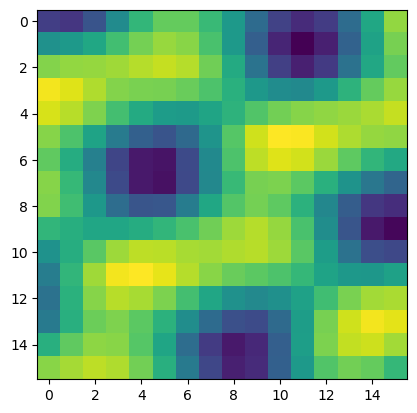



*************
 window number 275: 16 16




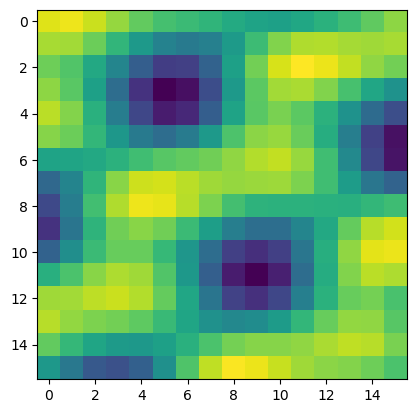



*************
 window number 276: 16 16




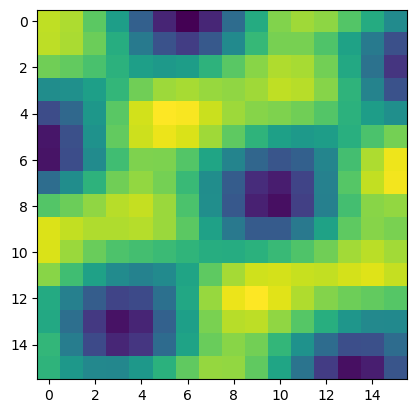



*************
 window number 277: 16 16




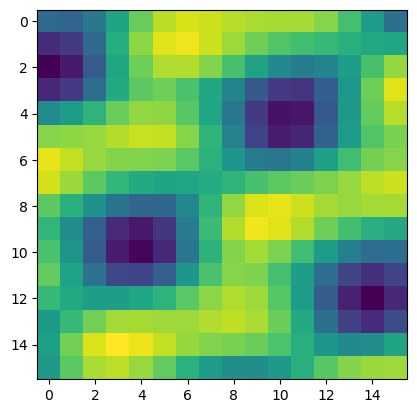



*************
 window number 278: 16 16




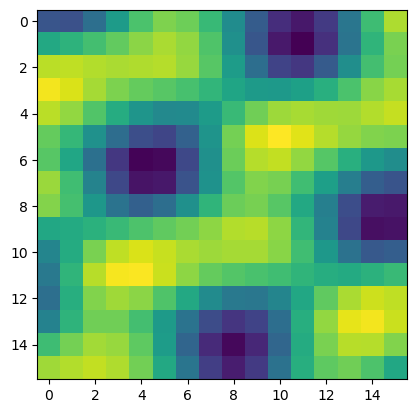



*************
 window number 279: 16 16




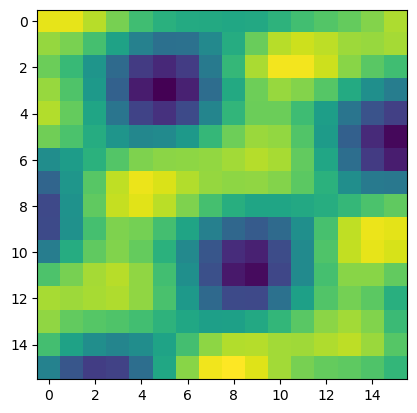



*************
 window number 280: 16 16




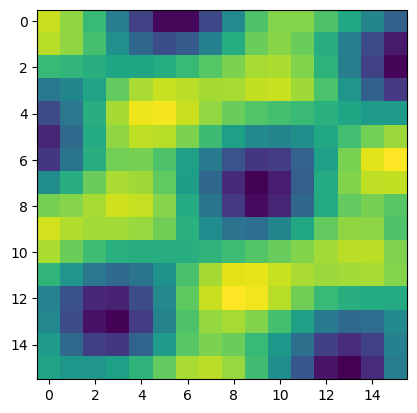



*************
 window number 281: 16 16




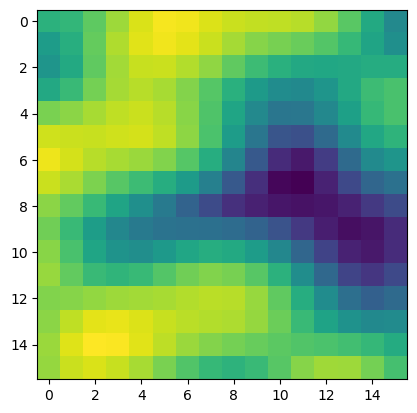



*************
 window number 282: 16 16




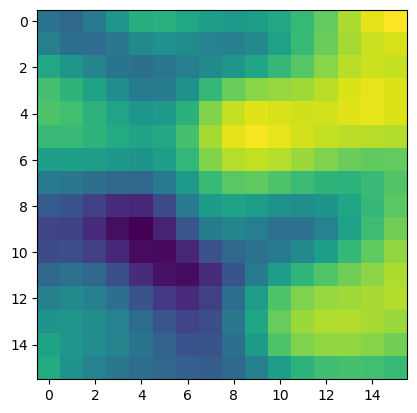



*************
 window number 283: 16 16




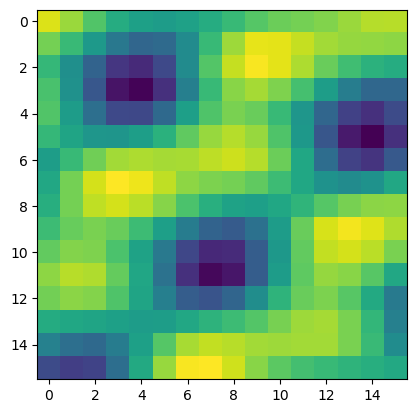



*************
 window number 284: 16 16




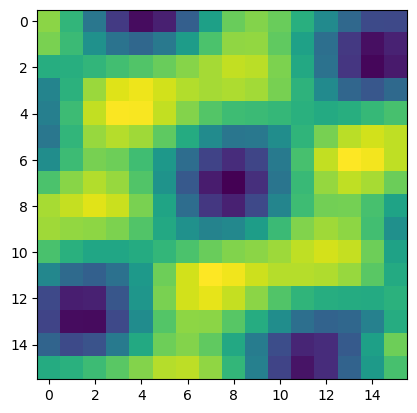



*************
 window number 285: 16 16




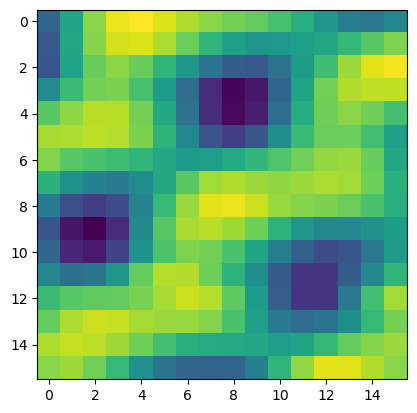



*************
 window number 286: 16 16




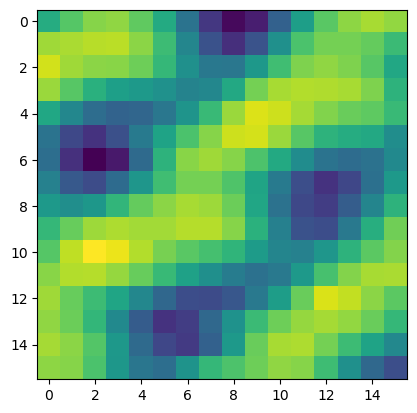



*************
 window number 287: 16 16




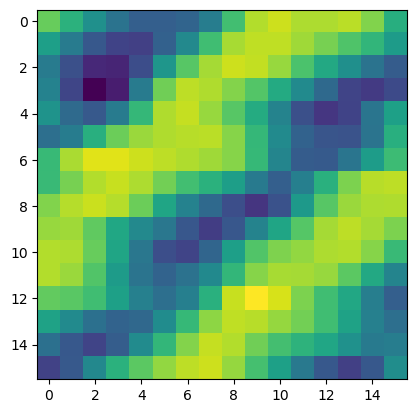



*************
 window number 288: 16 16




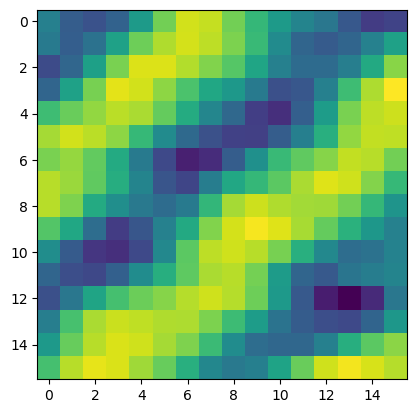



*************
 window number 289: 16 16




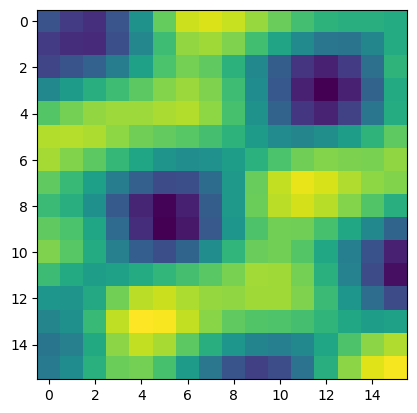



*************
 window number 290: 16 16




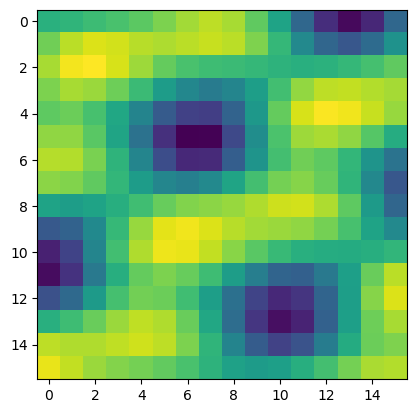



*************
 window number 291: 16 16




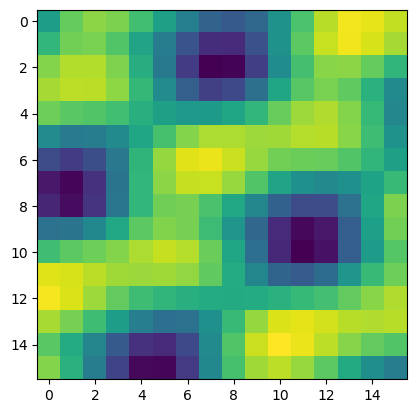



*************
 window number 292: 16 16




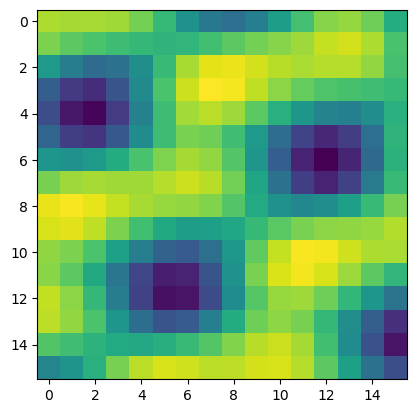



*************
 window number 293: 16 16




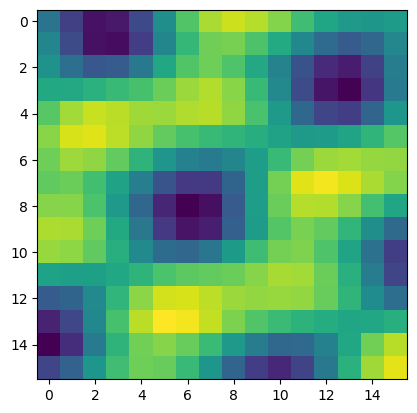



*************
 window number 294: 16 16




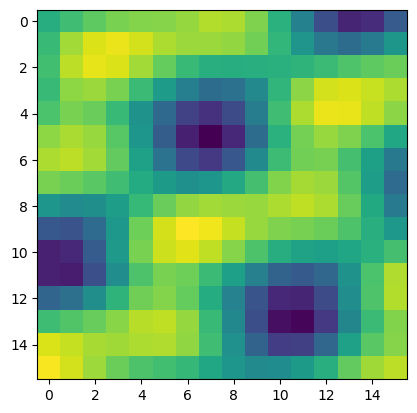



*************
 window number 295: 16 16




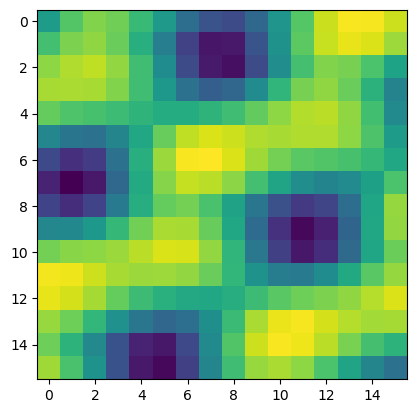



*************
 window number 296: 16 16




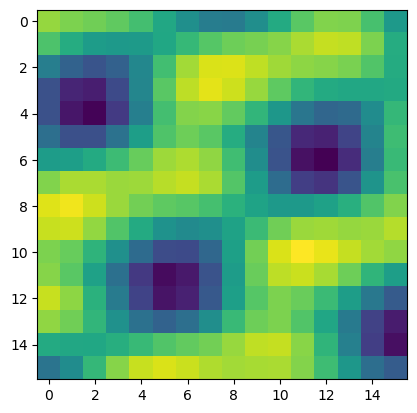



*************
 window number 297: 16 16




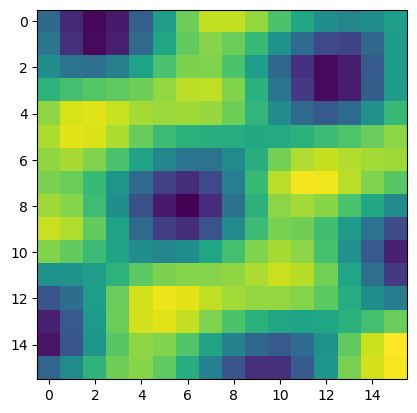



*************
 window number 298: 16 16




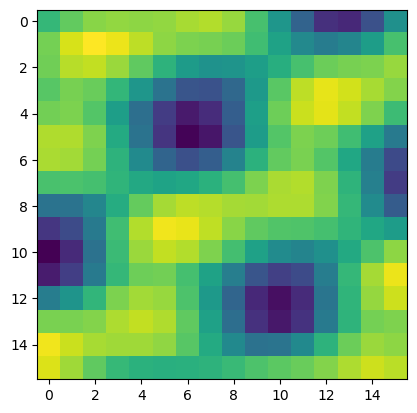



*************
 window number 299: 16 16




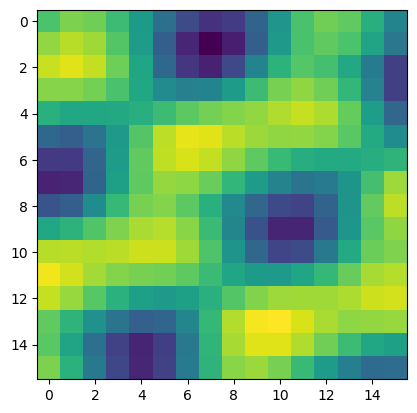



*************
 window number 300: 16 16




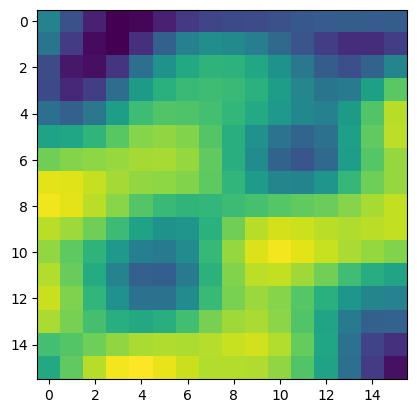



*************
 window number 301: 16 16




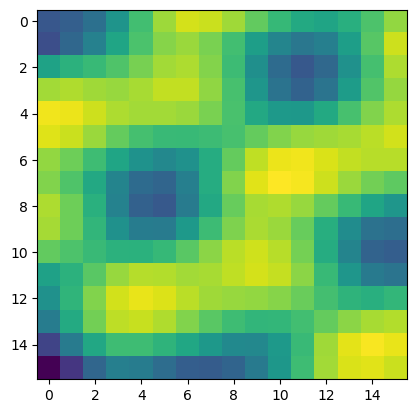



*************
 window number 302: 16 16




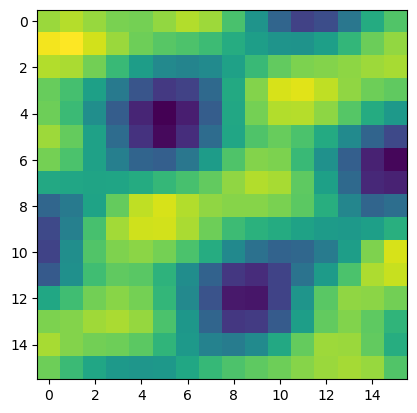



*************
 window number 303: 16 16




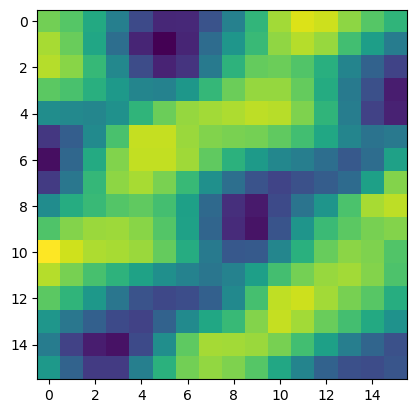



*************
 window number 304: 16 16




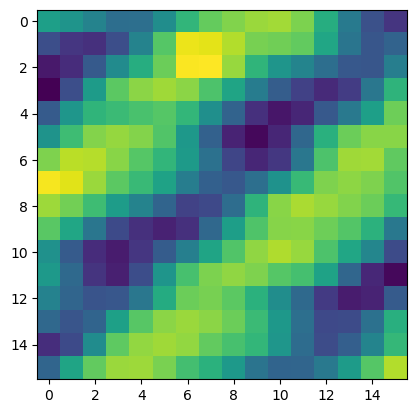



*************
 window number 305: 16 16




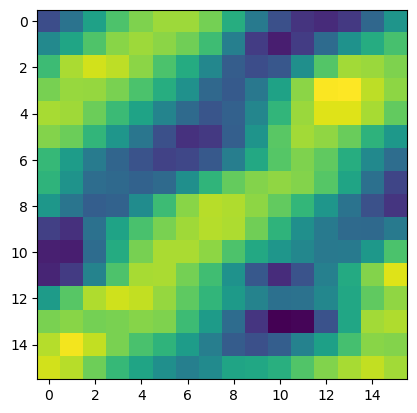



*************
 window number 306: 16 16




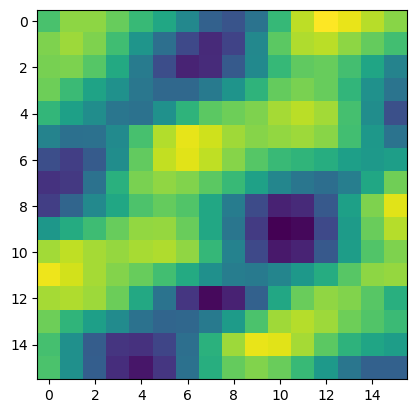



*************
 window number 307: 16 16




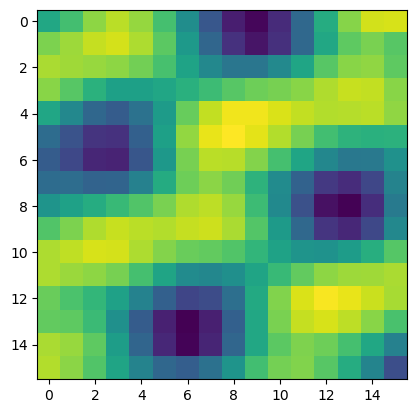



*************
 window number 308: 16 16




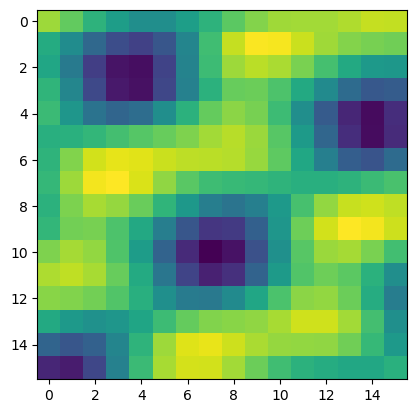



*************
 window number 309: 16 16




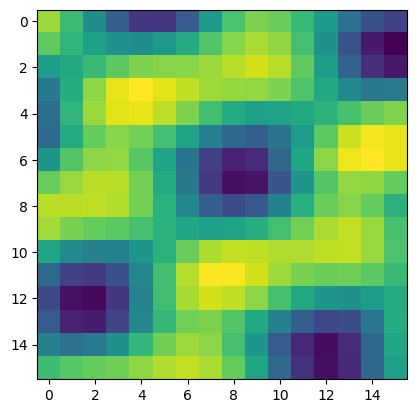



*************
 window number 310: 16 16




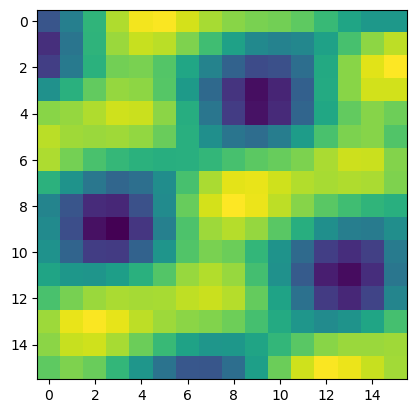



*************
 window number 311: 16 16




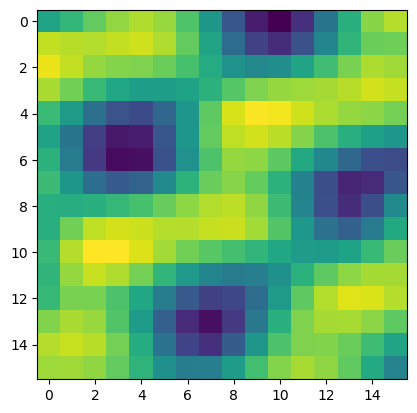



*************
 window number 312: 16 16




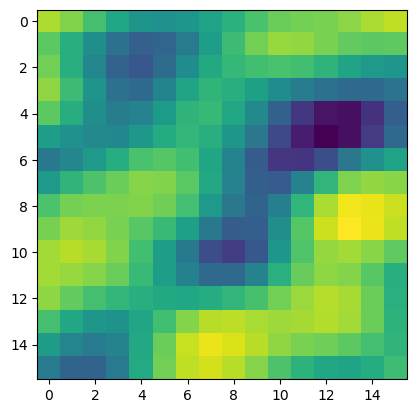



*************
 window number 313: 16 16




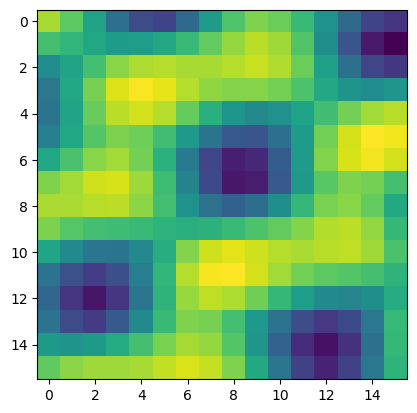



*************
 window number 314: 16 16




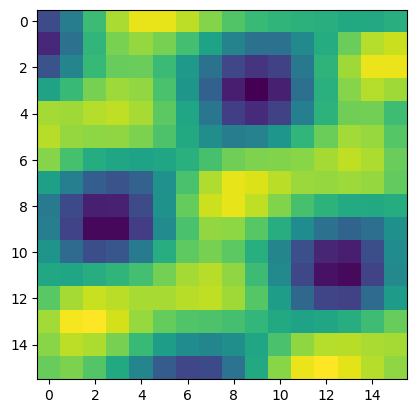



*************
 window number 315: 16 16




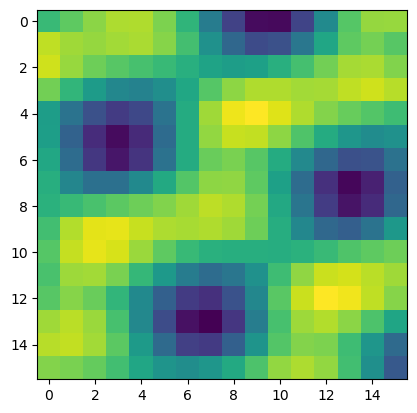



*************
 window number 316: 16 16




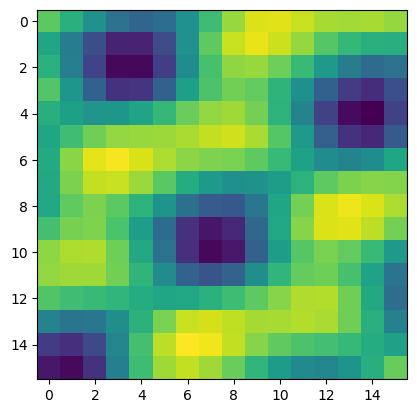



*************
 window number 317: 16 16




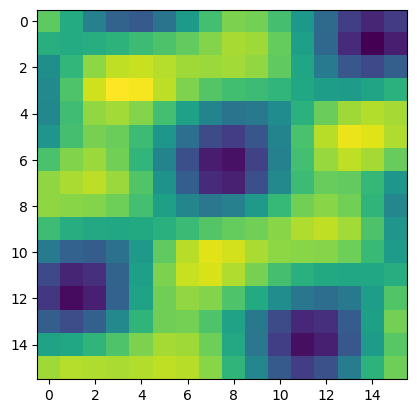



*************
 window number 318: 16 16




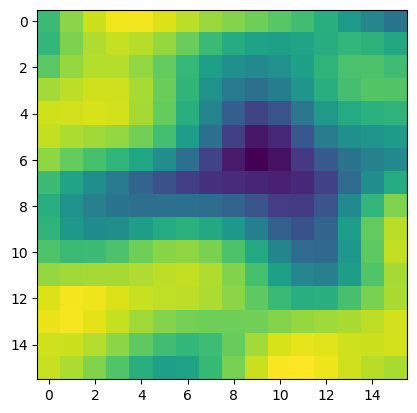



*************
 window number 319: 16 16




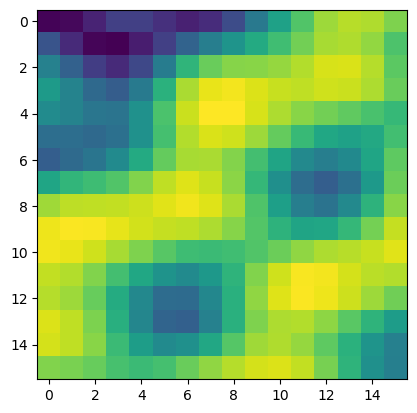



*************
 window number 320: 16 16




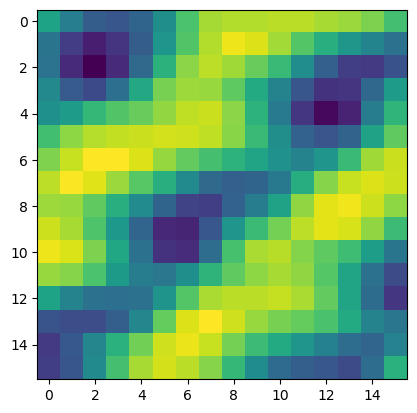



*************
 window number 321: 16 16




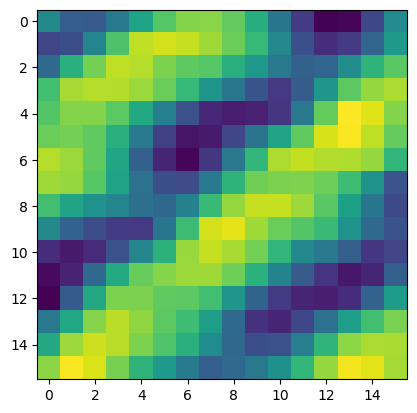



*************
 window number 322: 16 16




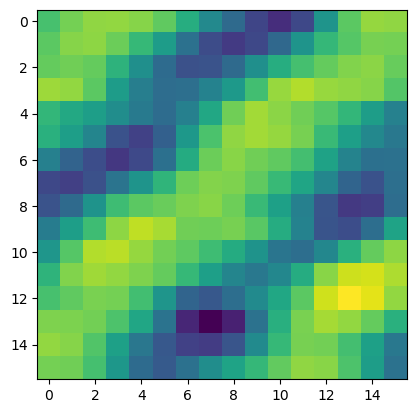



*************
 window number 323: 16 16




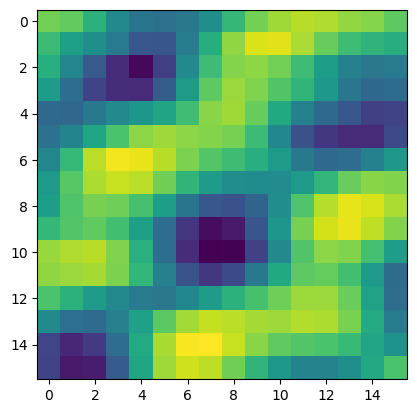



*************
 window number 324: 16 16




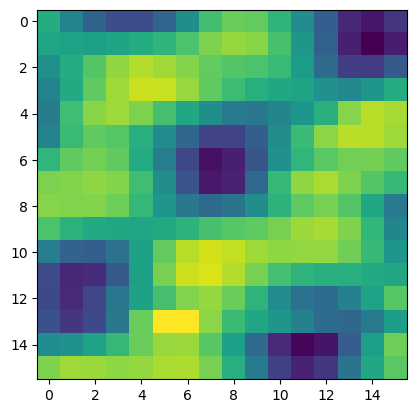

j

*************
 window number 1: 16 16




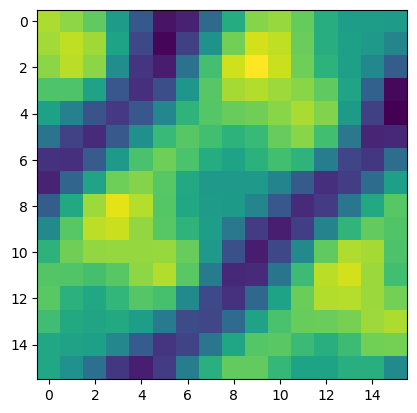



*************
 window number 2: 16 16




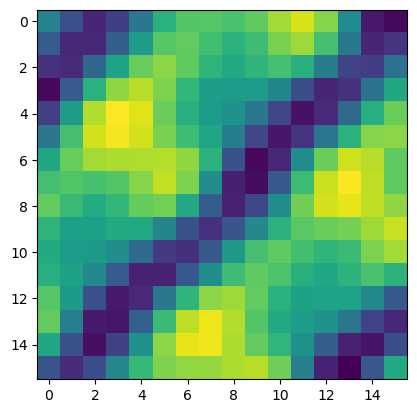



*************
 window number 3: 16 16




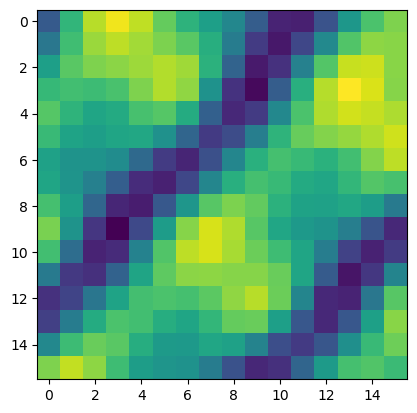



*************
 window number 4: 16 16




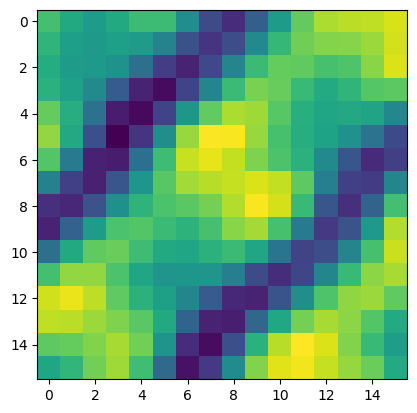



*************
 window number 5: 16 16




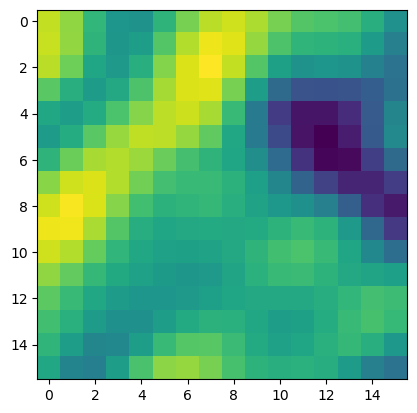



*************
 window number 6: 16 16




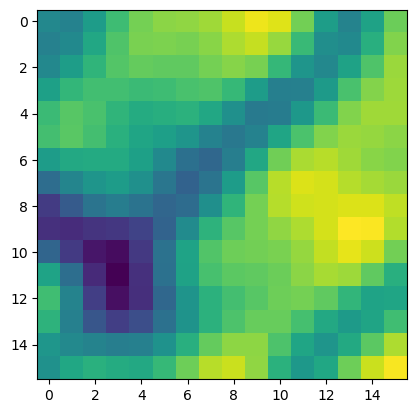



*************
 window number 7: 16 16




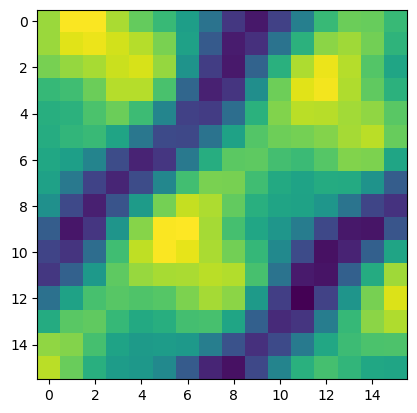



*************
 window number 8: 16 16




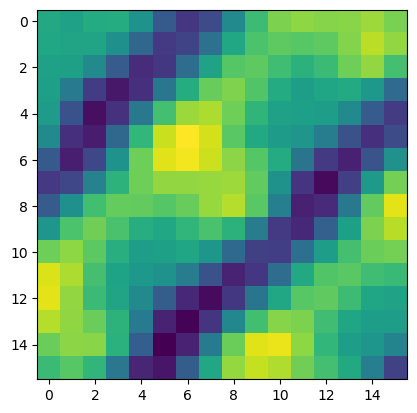



*************
 window number 9: 16 16




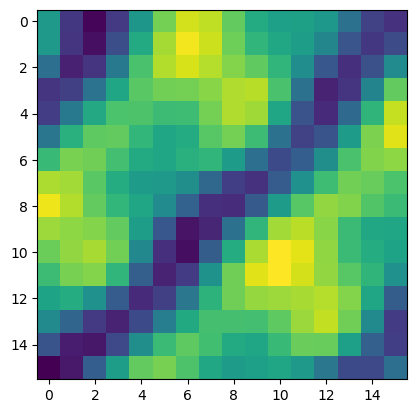



*************
 window number 10: 16 16




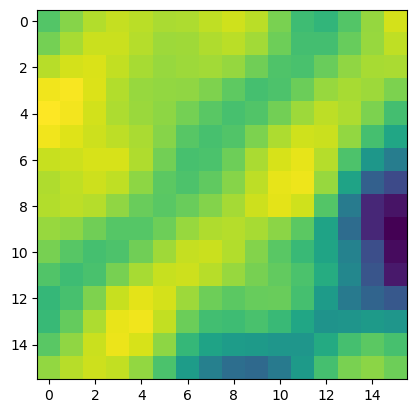



*************
 window number 11: 16 16




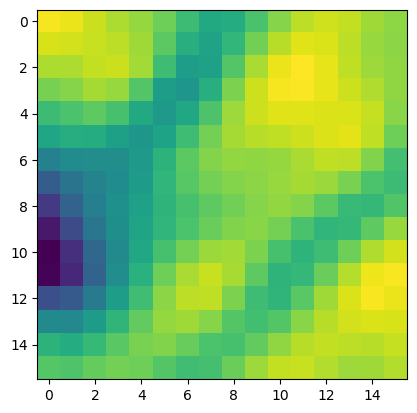



*************
 window number 12: 16 16




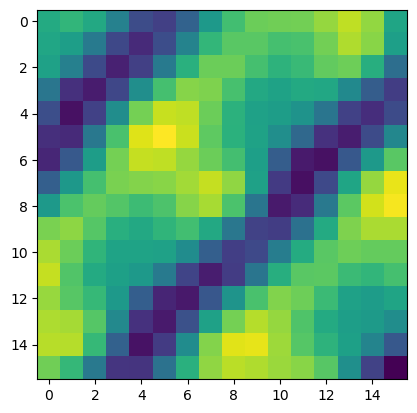



*************
 window number 13: 16 16




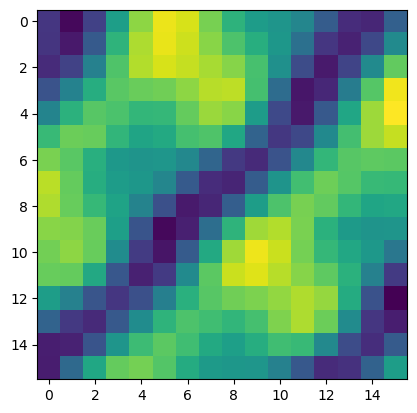



*************
 window number 14: 16 16




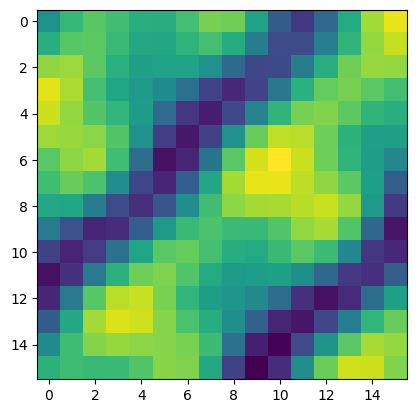



*************
 window number 15: 16 16




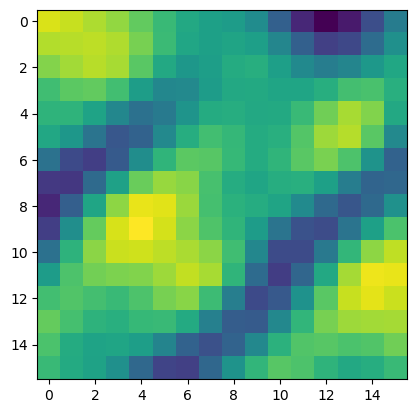



*************
 window number 16: 16 16




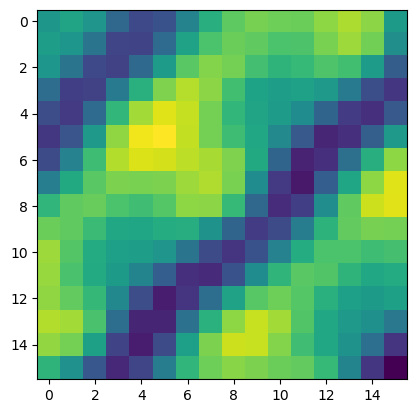



*************
 window number 17: 16 16




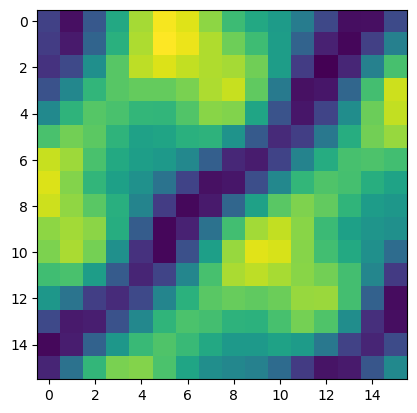



*************
 window number 18: 16 16




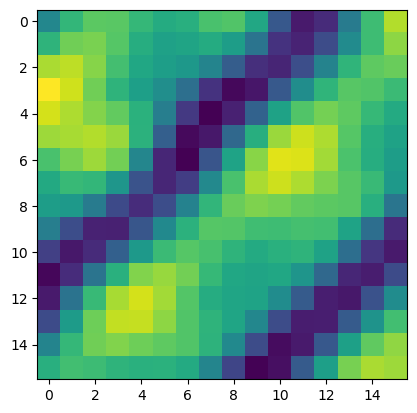



*************
 window number 19: 16 16




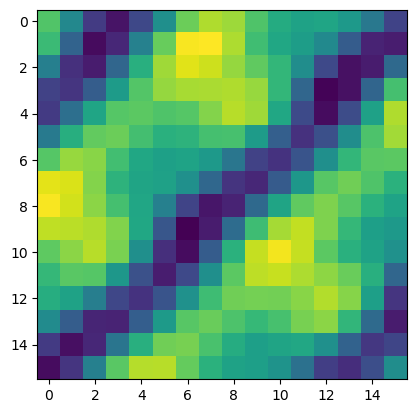



*************
 window number 20: 16 16




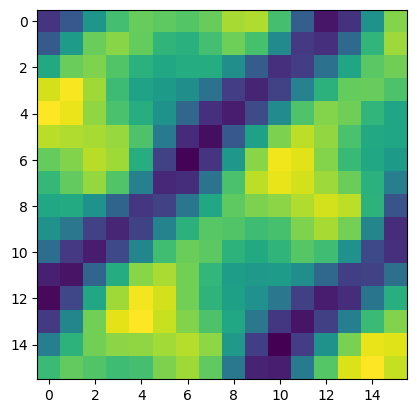



*************
 window number 21: 16 16




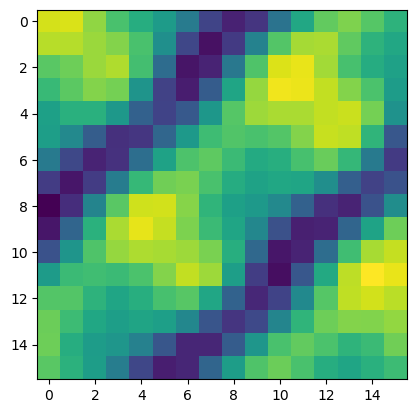



*************
 window number 22: 16 16




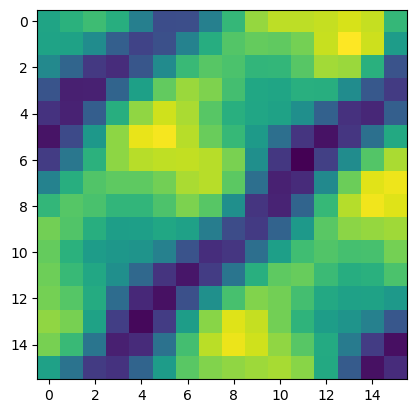



*************
 window number 23: 16 16




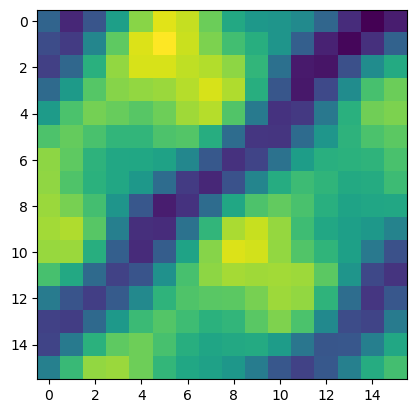



*************
 window number 24: 16 16




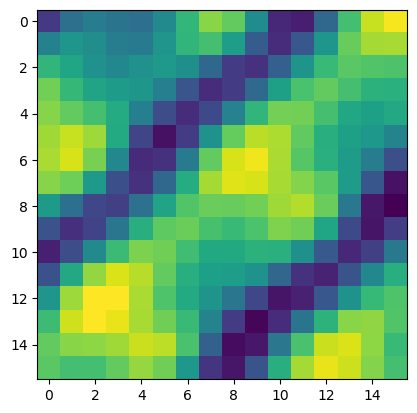



*************
 window number 25: 16 16




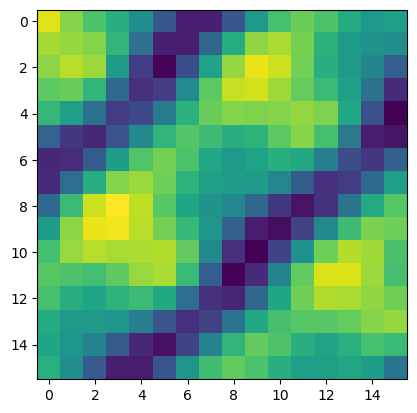



*************
 window number 26: 16 16




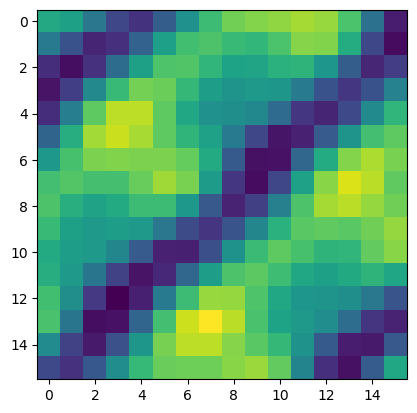



*************
 window number 27: 16 16




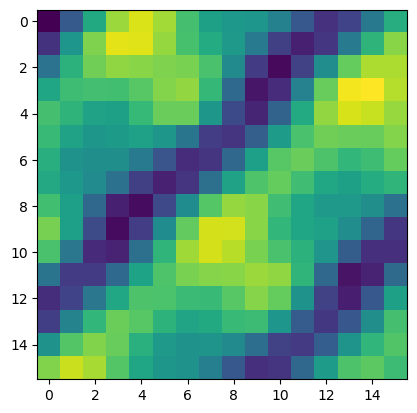



*************
 window number 28: 16 16




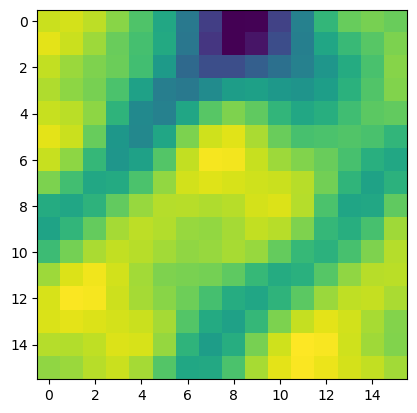



*************
 window number 29: 16 16




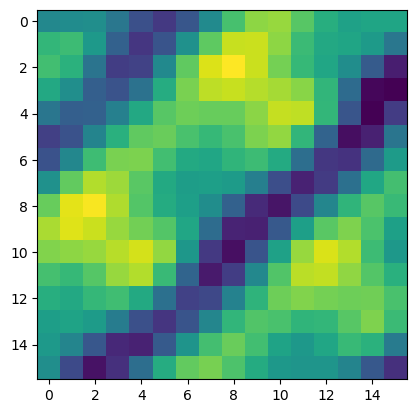



*************
 window number 30: 16 16




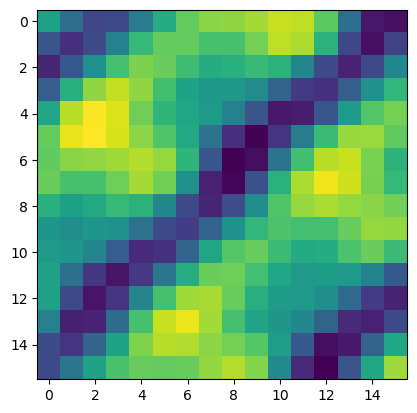



*************
 window number 31: 16 16




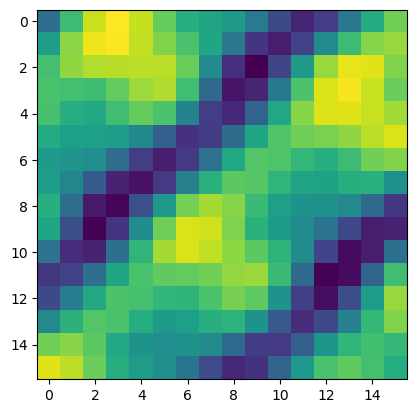



*************
 window number 32: 16 16




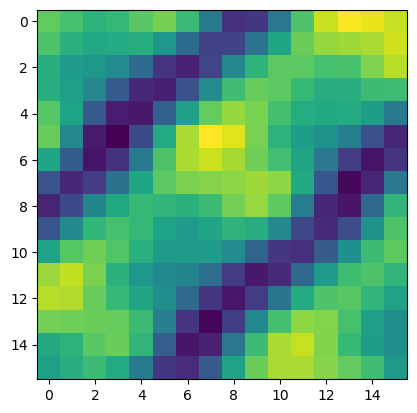



*************
 window number 33: 16 16




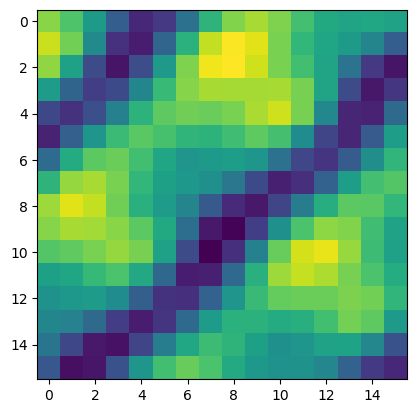



*************
 window number 34: 16 16




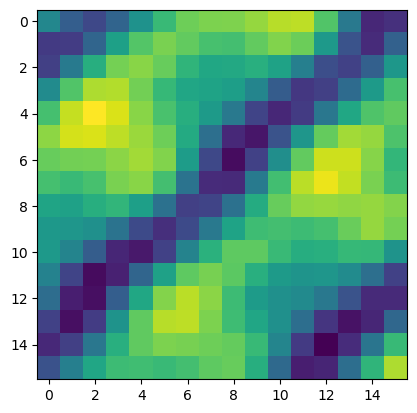



*************
 window number 35: 16 16




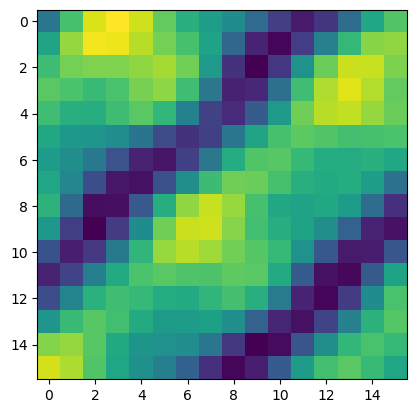



*************
 window number 36: 16 16




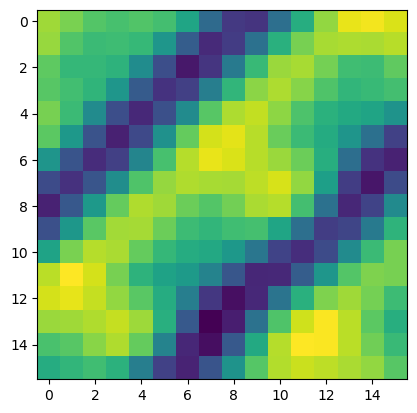



*************
 window number 37: 16 16




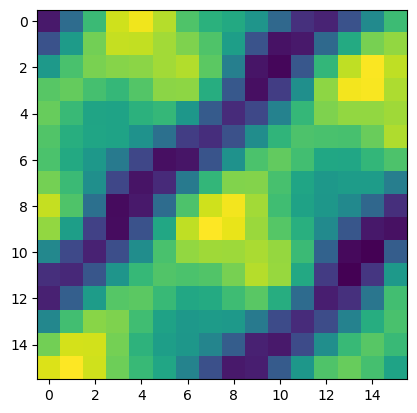



*************
 window number 38: 16 16




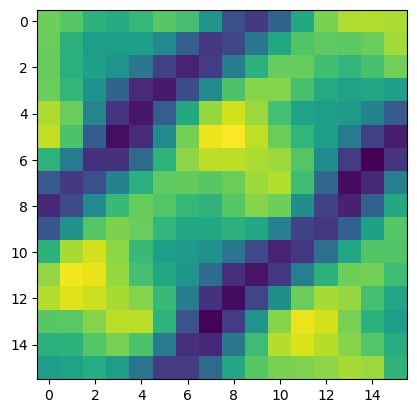



*************
 window number 39: 16 16




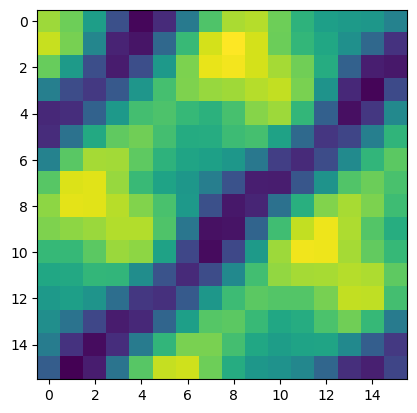



*************
 window number 40: 16 16




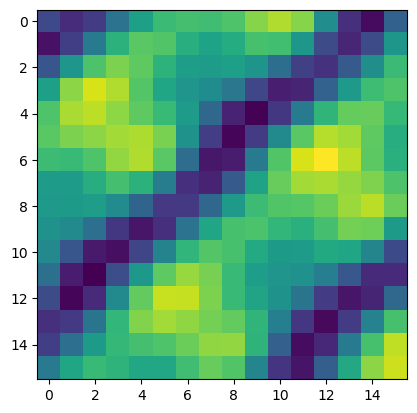



*************
 window number 41: 16 16




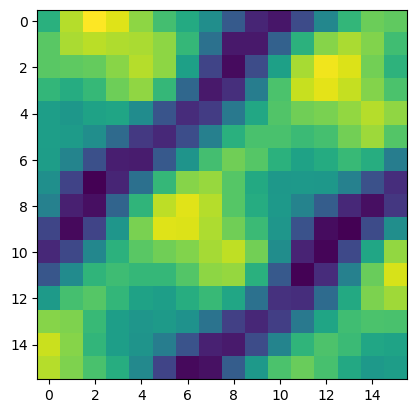



*************
 window number 42: 16 16




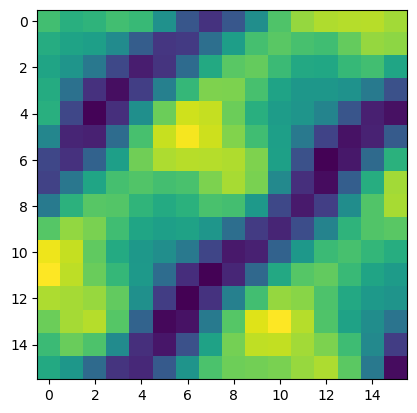



*************
 window number 43: 16 16




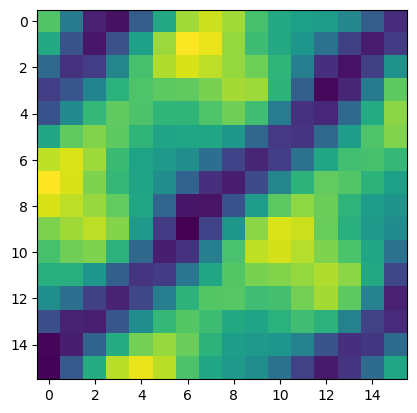



*************
 window number 44: 16 16




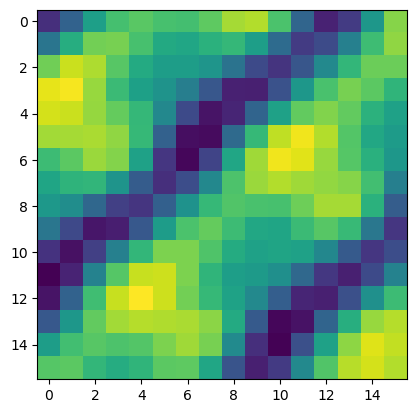



*************
 window number 45: 16 16




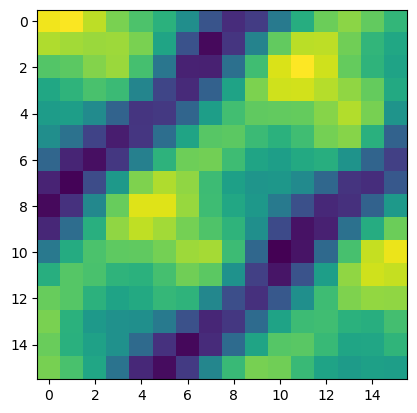



*************
 window number 46: 16 16




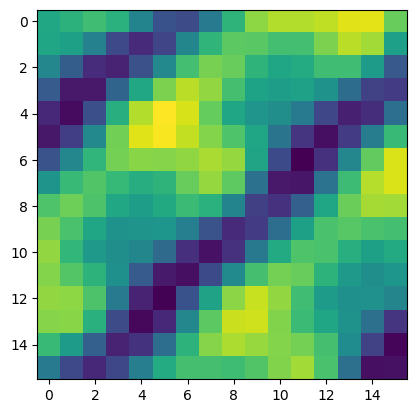



*************
 window number 47: 16 16




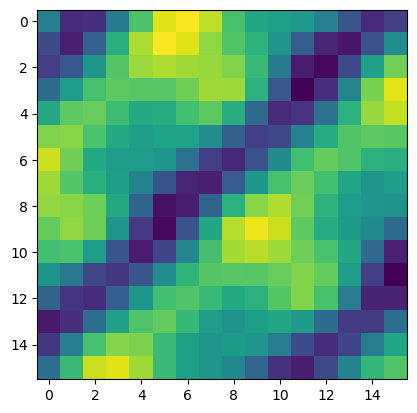



*************
 window number 48: 16 16




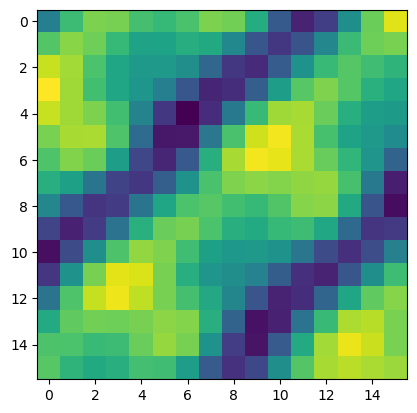



*************
 window number 49: 16 16




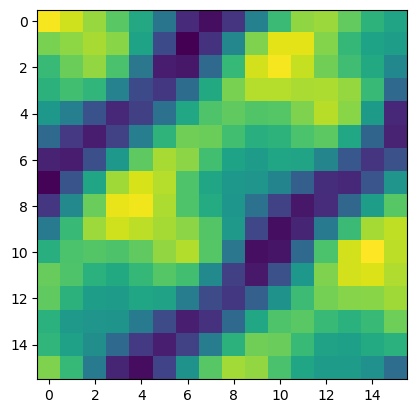



*************
 window number 50: 16 16




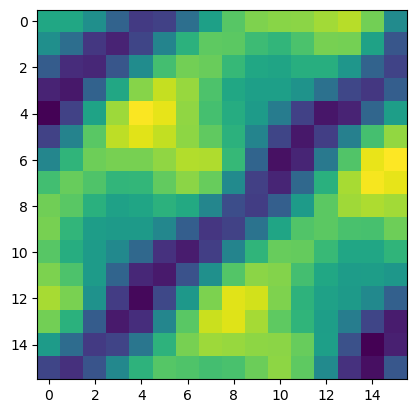



*************
 window number 51: 16 16




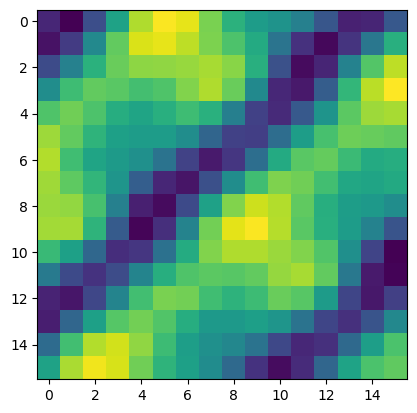



*************
 window number 52: 16 16




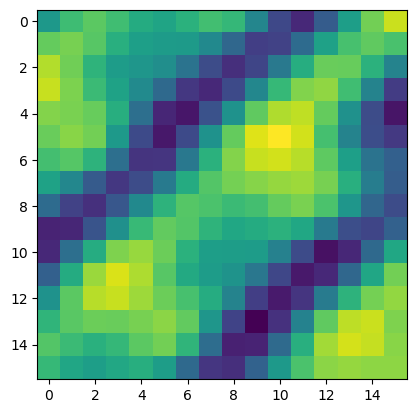



*************
 window number 53: 16 16




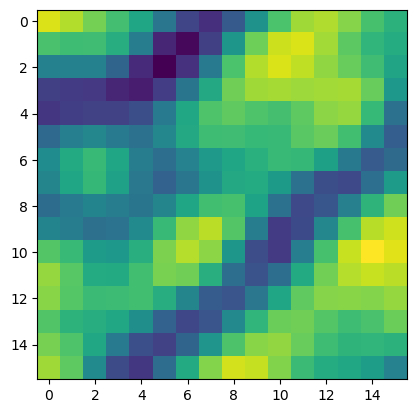



*************
 window number 54: 16 16




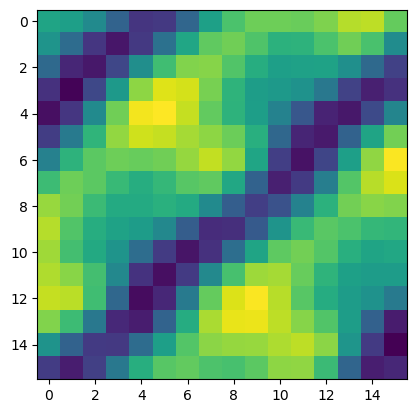



*************
 window number 55: 16 16




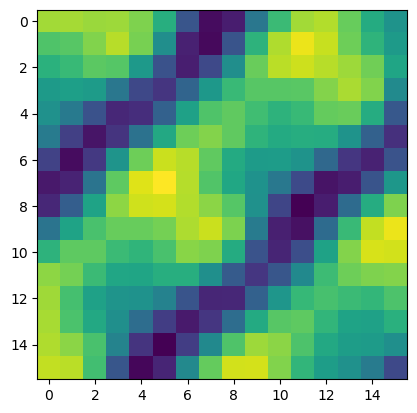



*************
 window number 56: 16 16




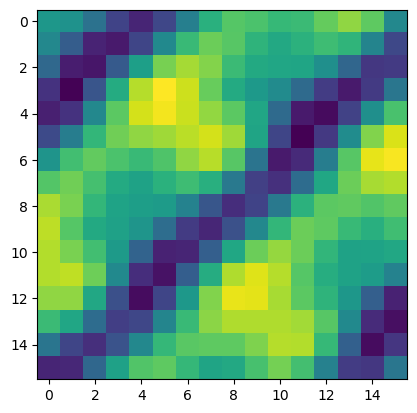



*************
 window number 57: 16 16




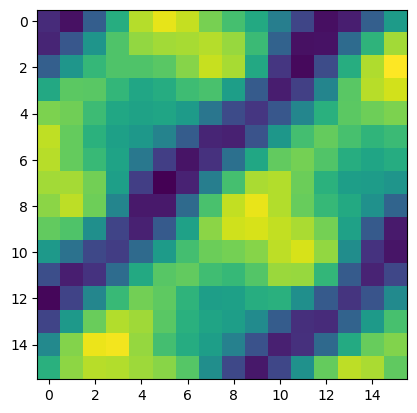



*************
 window number 58: 16 16




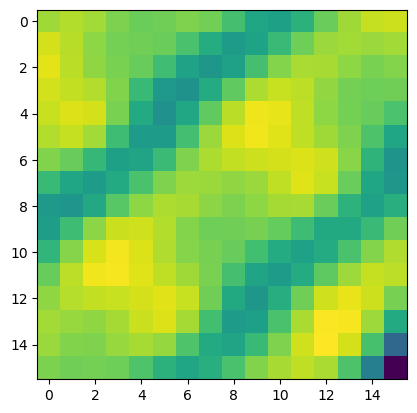



*************
 window number 59: 16 16




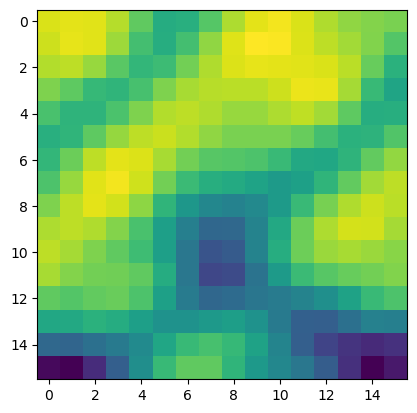



*************
 window number 60: 16 16




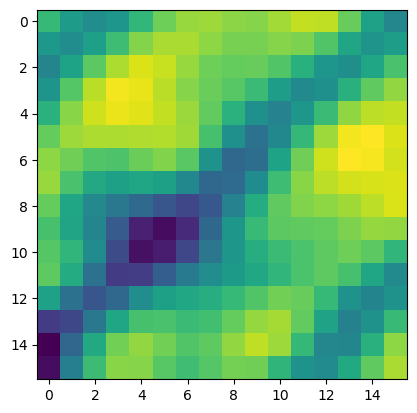



*************
 window number 61: 16 16




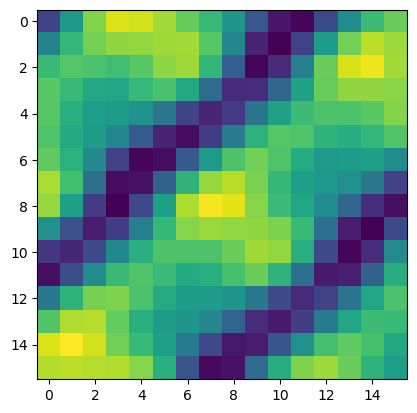



*************
 window number 62: 16 16




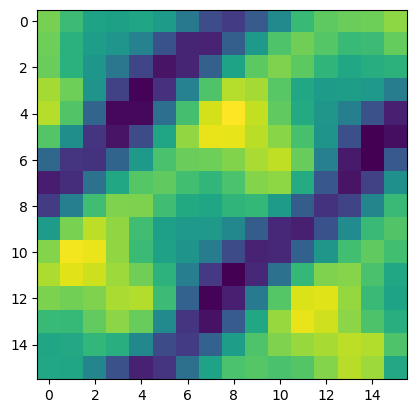



*************
 window number 63: 16 16




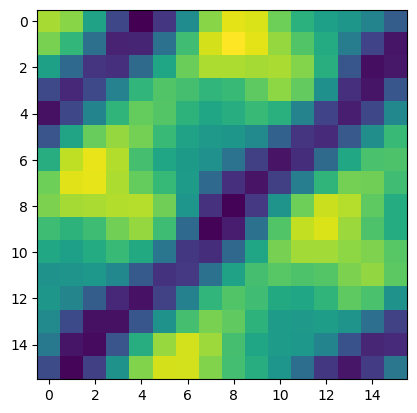



*************
 window number 64: 16 16




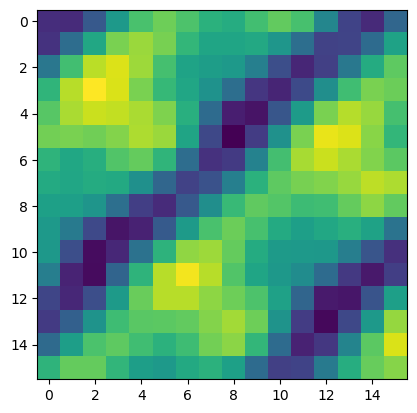



*************
 window number 65: 16 16




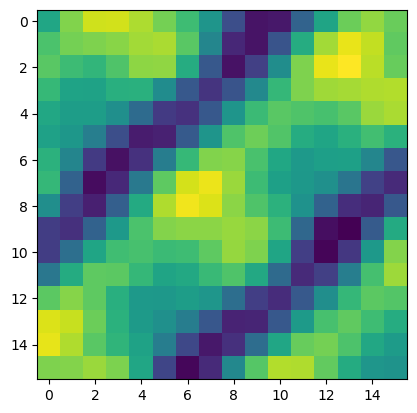



*************
 window number 66: 16 16




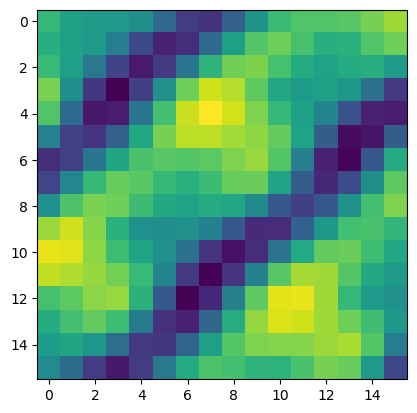



*************
 window number 67: 16 16




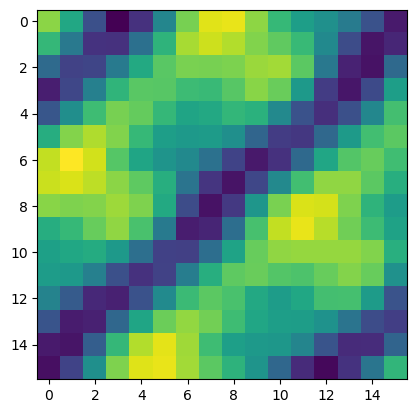



*************
 window number 68: 16 16




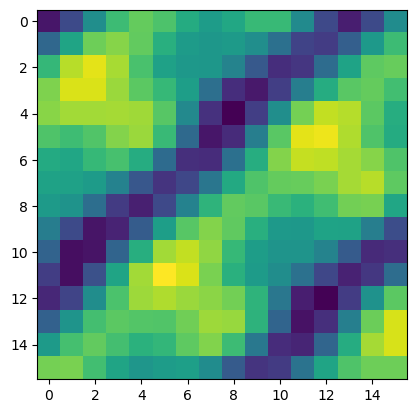



*************
 window number 69: 16 16




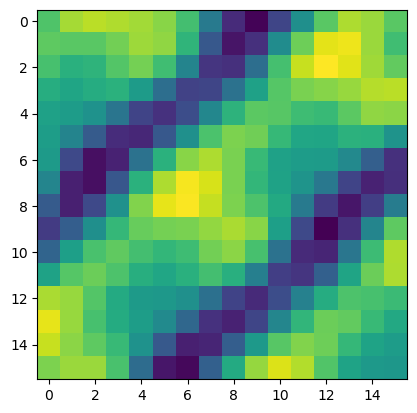



*************
 window number 70: 16 16




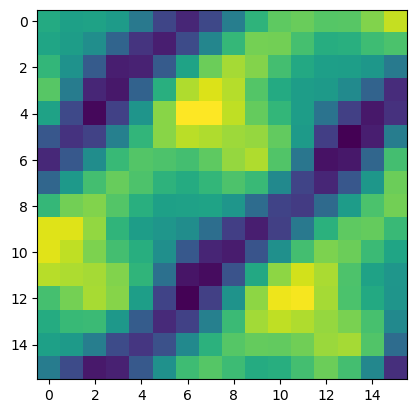



*************
 window number 71: 16 16




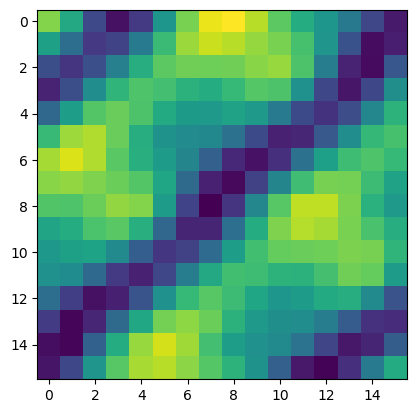



*************
 window number 72: 16 16




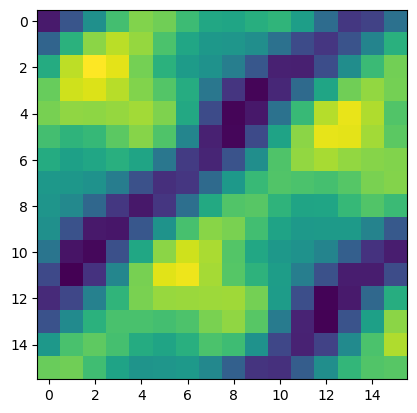



*************
 window number 73: 16 16




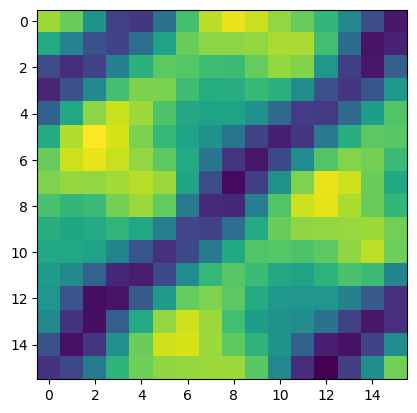



*************
 window number 74: 16 16




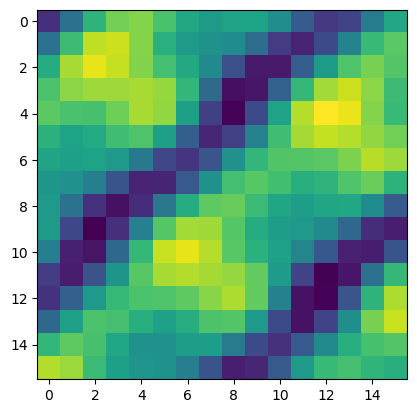



*************
 window number 75: 16 16




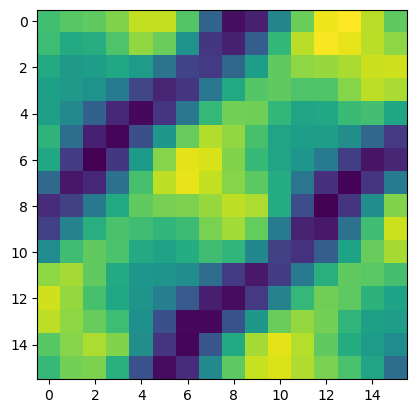



*************
 window number 76: 16 16




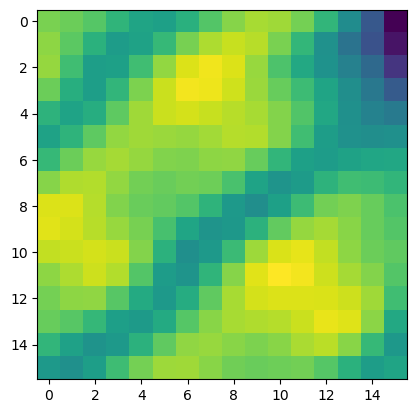



*************
 window number 77: 16 16




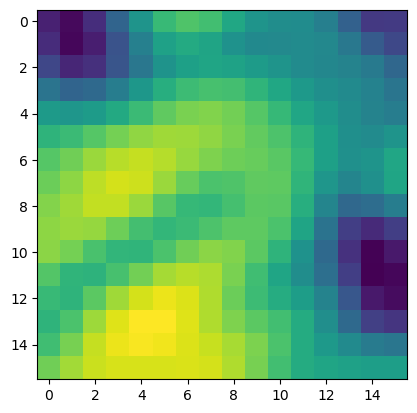



*************
 window number 78: 16 16




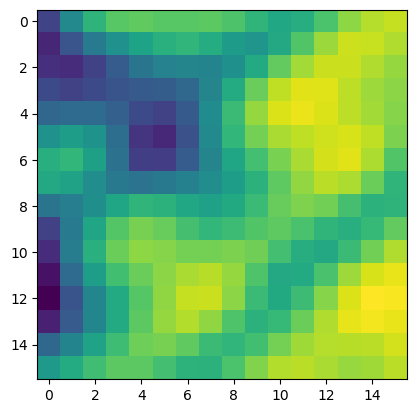



*************
 window number 79: 16 16




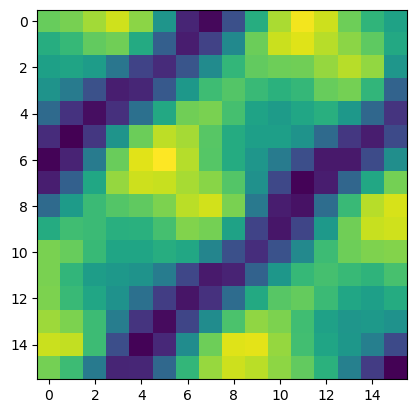



*************
 window number 80: 16 16




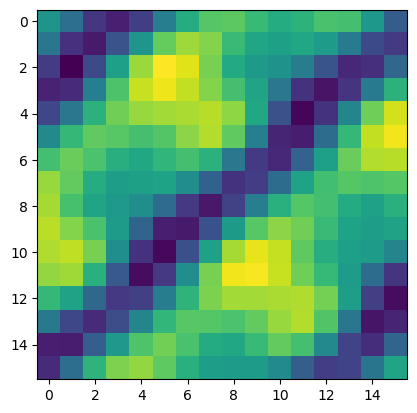



*************
 window number 81: 16 16




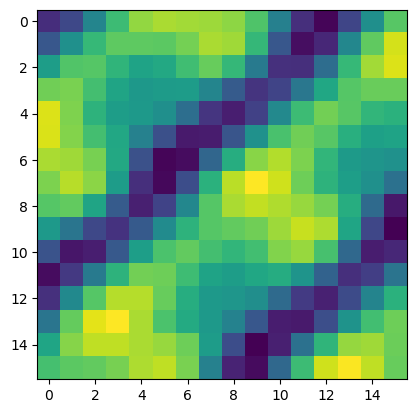



*************
 window number 82: 16 16




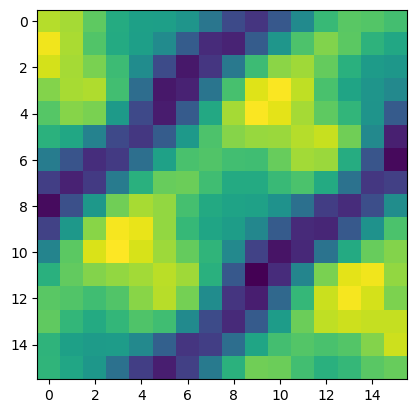



*************
 window number 83: 16 16




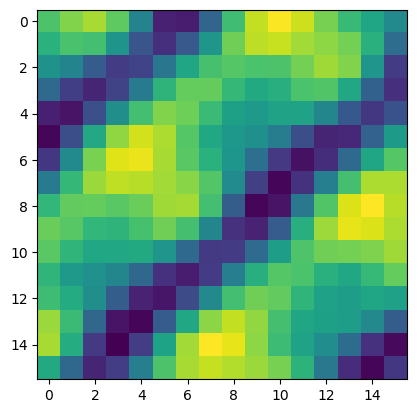



*************
 window number 84: 16 16




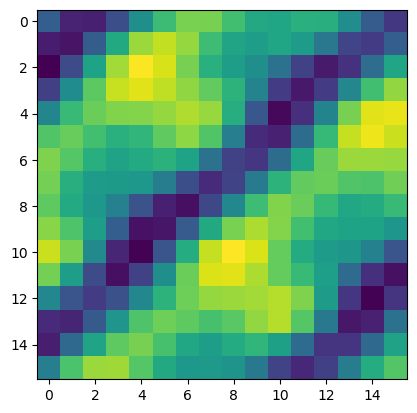



*************
 window number 85: 16 16




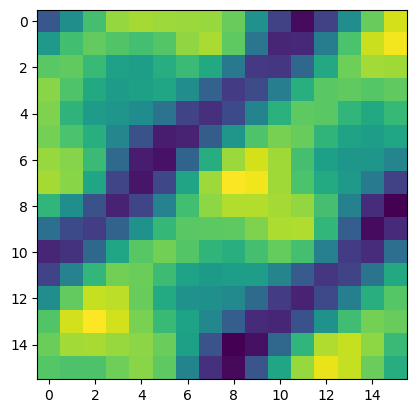



*************
 window number 86: 16 16




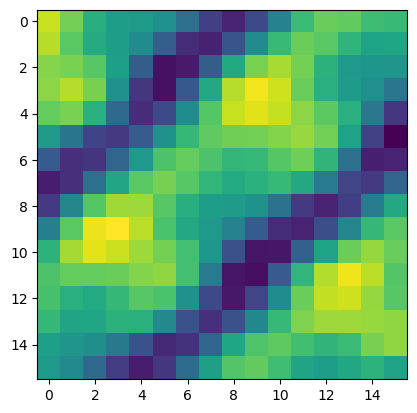



*************
 window number 87: 16 16




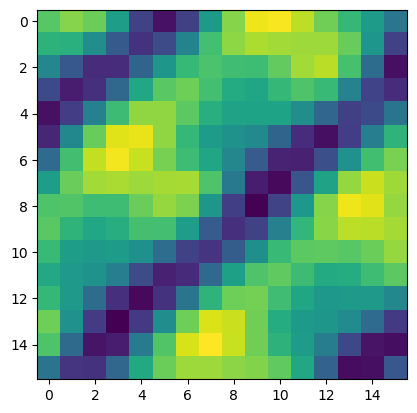



*************
 window number 88: 16 16




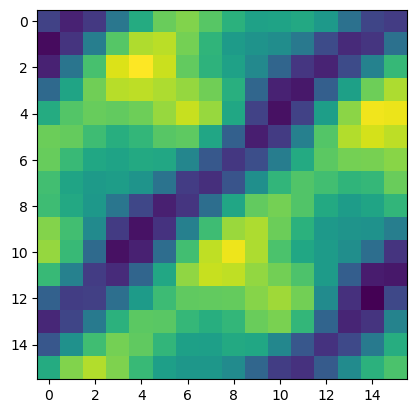



*************
 window number 89: 16 16




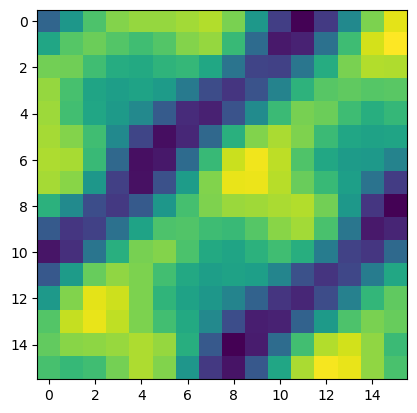



*************
 window number 90: 16 16




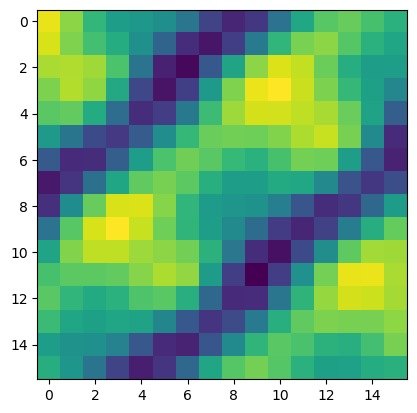



*************
 window number 91: 16 16




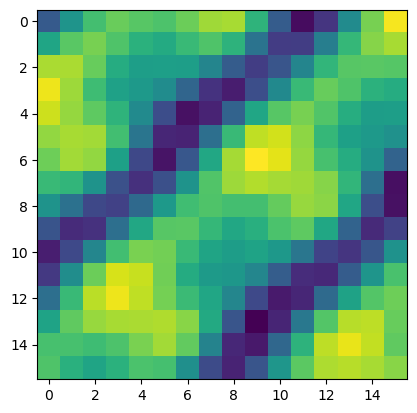



*************
 window number 92: 16 16




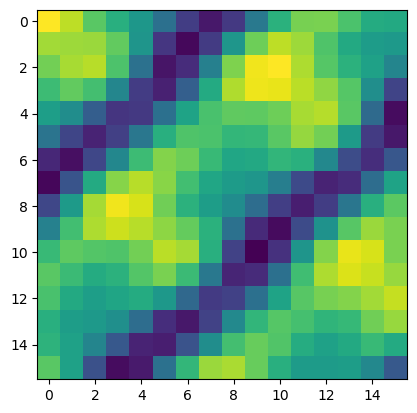



*************
 window number 93: 16 16




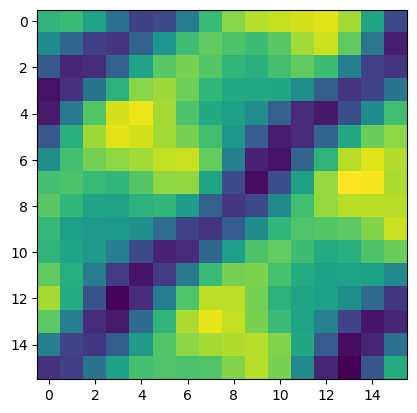



*************
 window number 94: 16 16




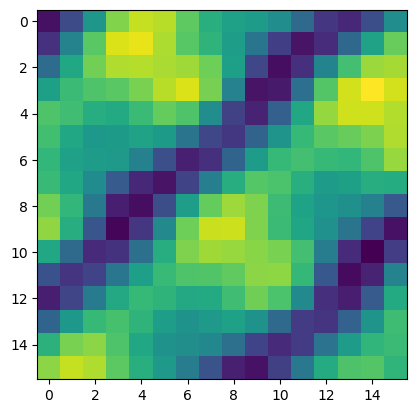



*************
 window number 95: 16 16




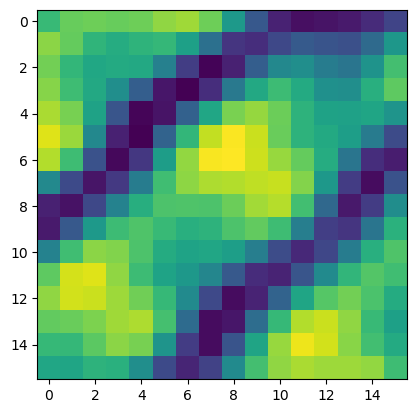



*************
 window number 96: 16 16




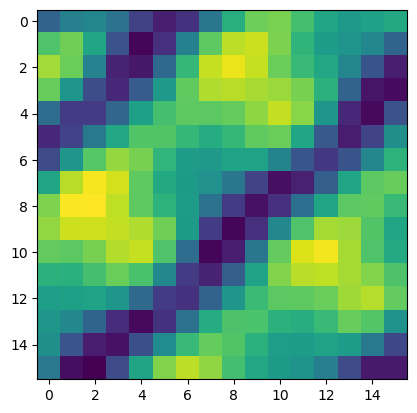



*************
 window number 97: 16 16




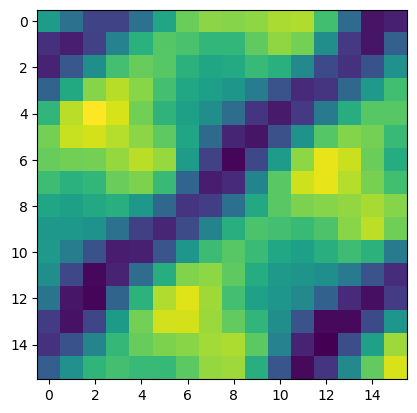



*************
 window number 98: 16 16




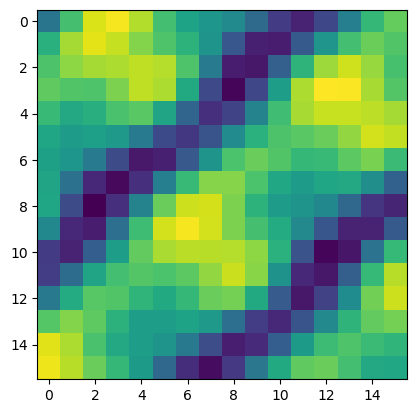



*************
 window number 99: 16 16




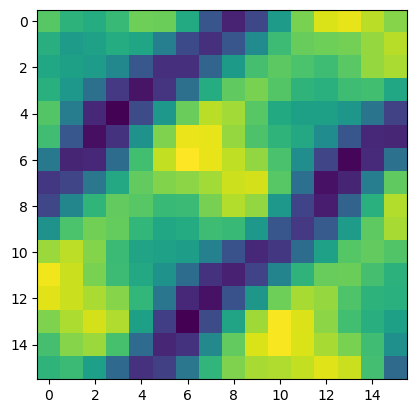



*************
 window number 100: 16 16




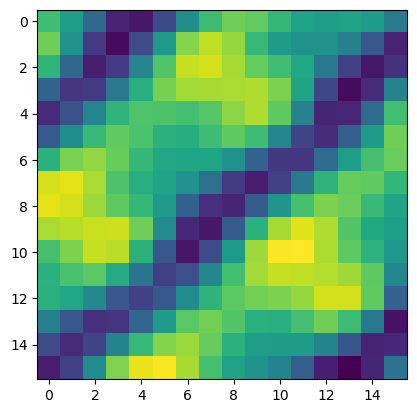



*************
 window number 101: 16 16




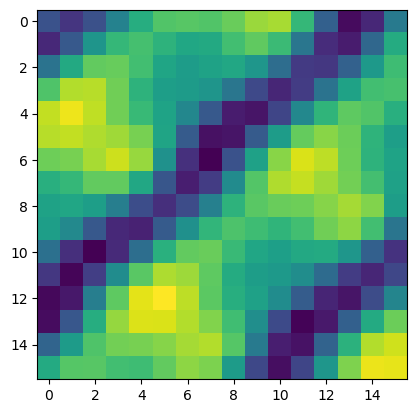



*************
 window number 102: 16 16




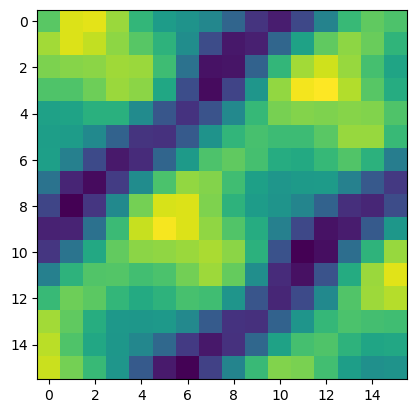



*************
 window number 103: 16 16




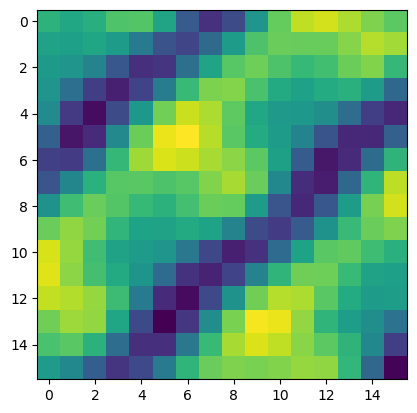



*************
 window number 104: 16 16




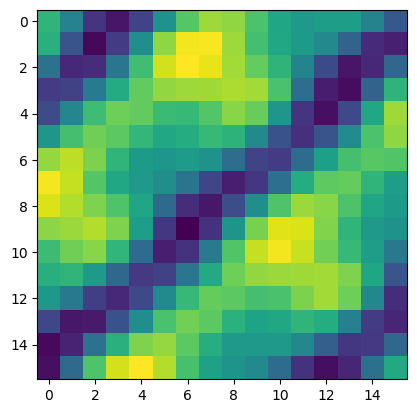



*************
 window number 105: 16 16




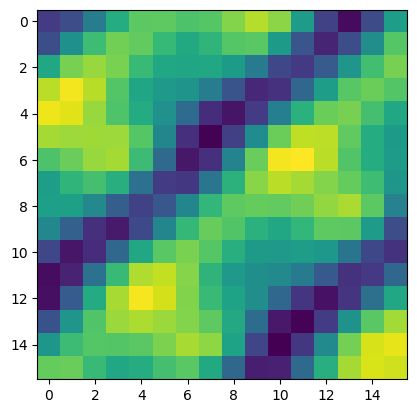



*************
 window number 106: 16 16




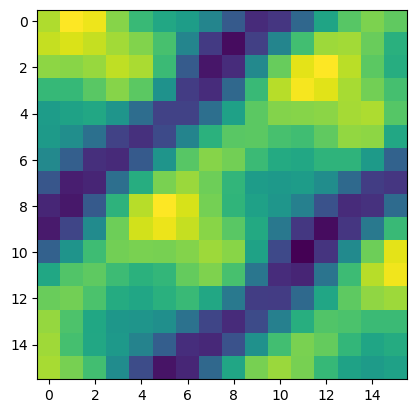



*************
 window number 107: 16 16




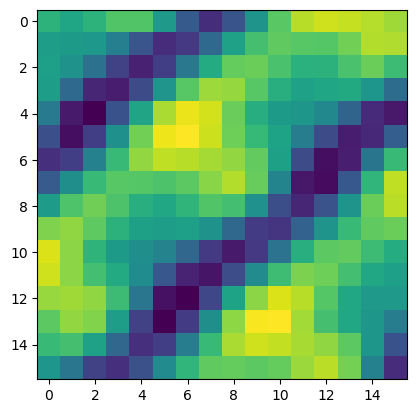



*************
 window number 108: 16 16




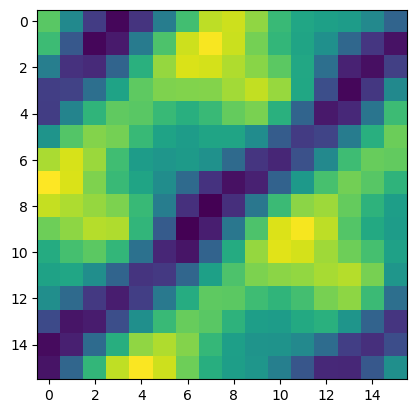



*************
 window number 109: 16 16




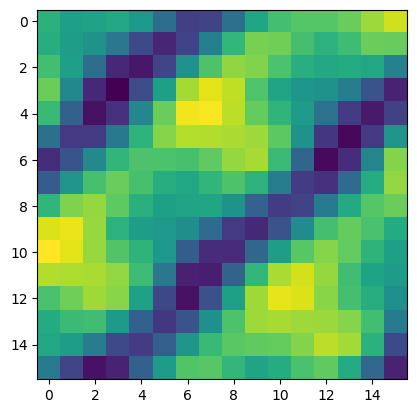



*************
 window number 110: 16 16




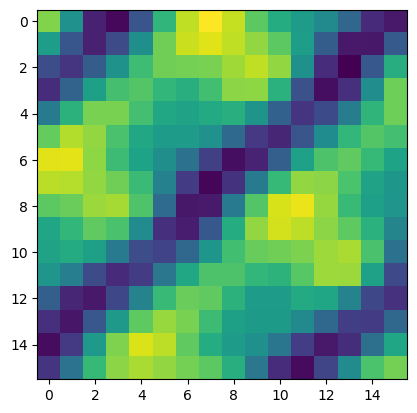



*************
 window number 111: 16 16




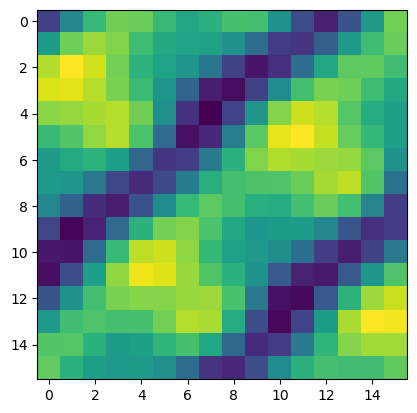



*************
 window number 112: 16 16




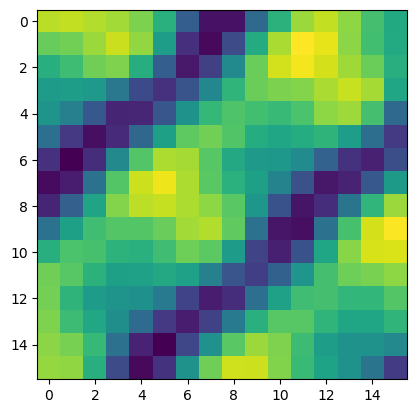



*************
 window number 113: 16 16




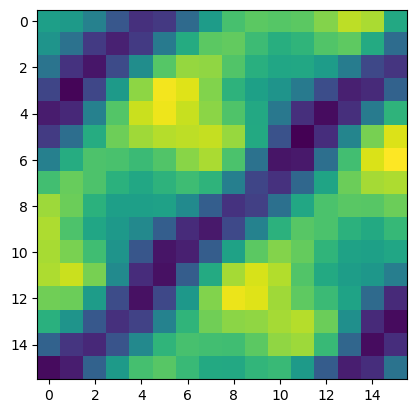



*************
 window number 114: 16 16




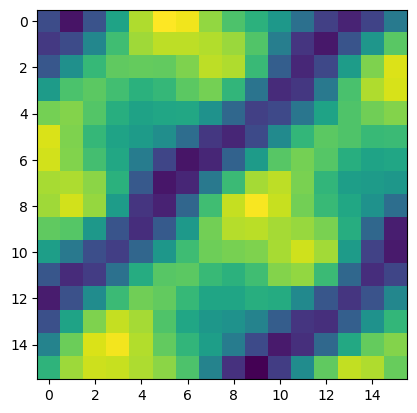



*************
 window number 115: 16 16




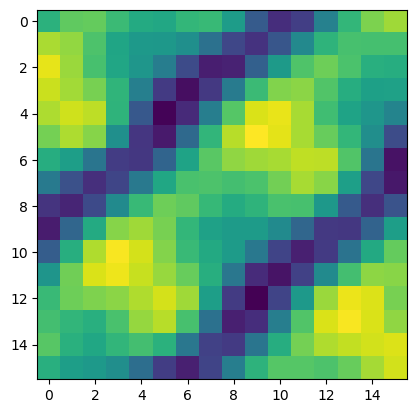



*************
 window number 116: 16 16




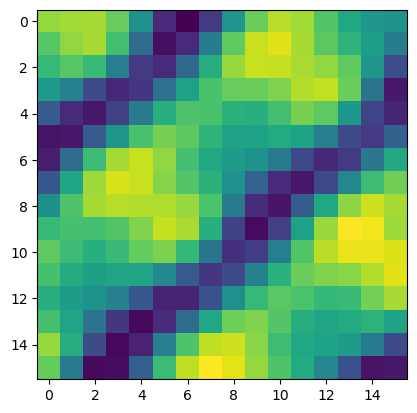



*************
 window number 117: 16 16




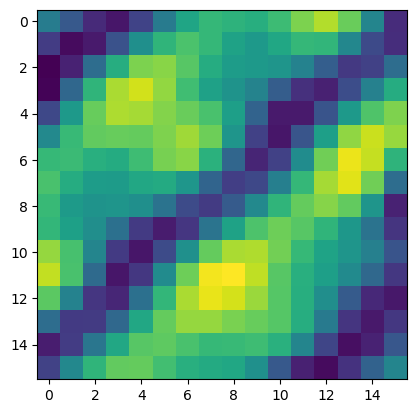



*************
 window number 118: 16 16




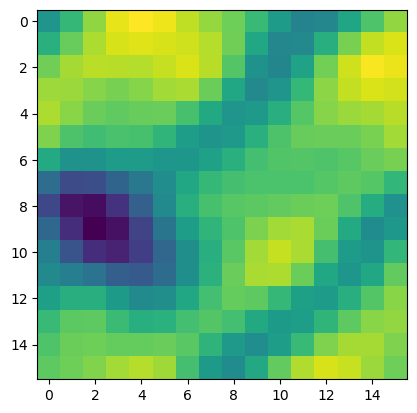



*************
 window number 119: 16 16




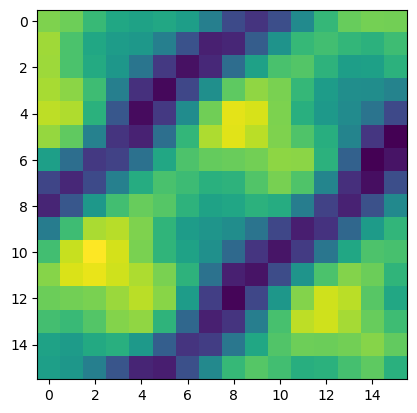



*************
 window number 120: 16 16




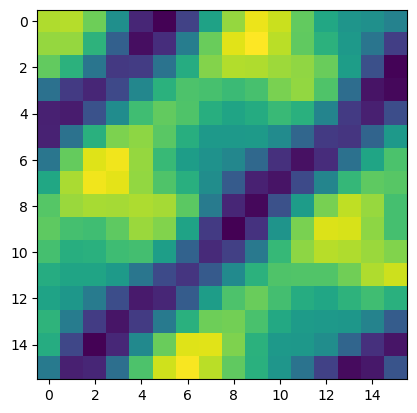



*************
 window number 121: 16 16




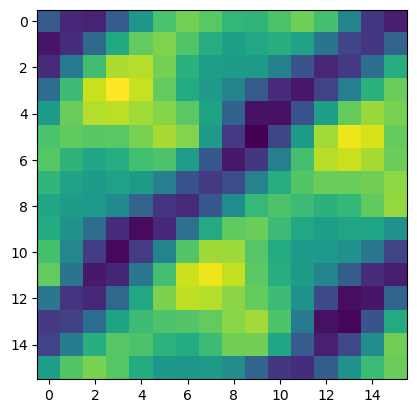



*************
 window number 122: 16 16




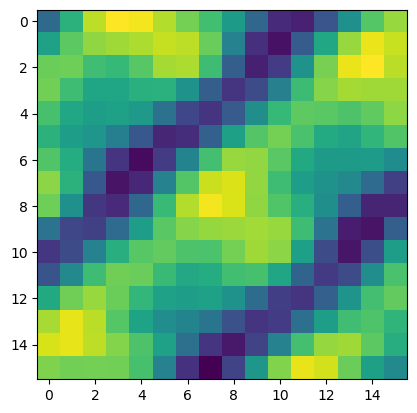



*************
 window number 123: 16 16




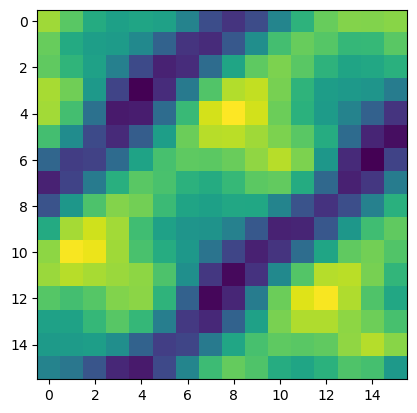



*************
 window number 124: 16 16




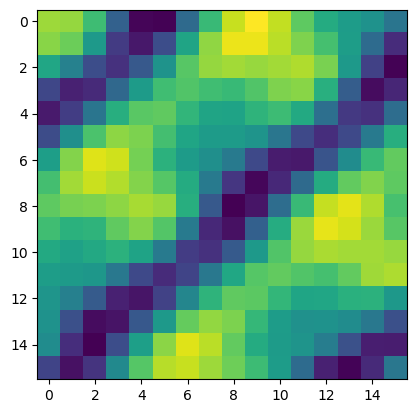



*************
 window number 125: 16 16




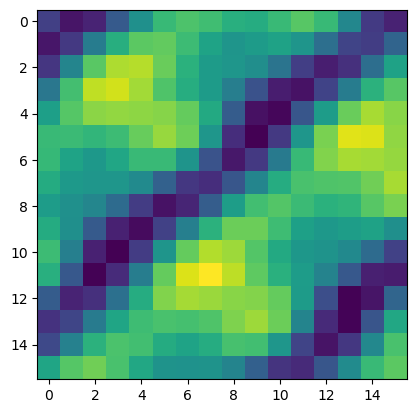



*************
 window number 126: 16 16




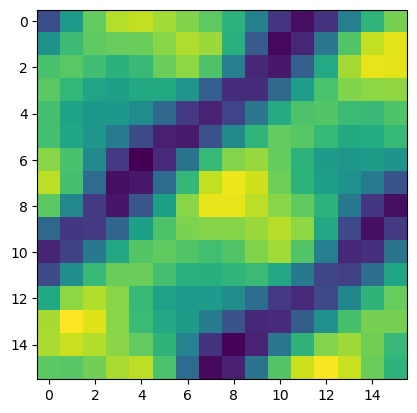



*************
 window number 127: 16 16




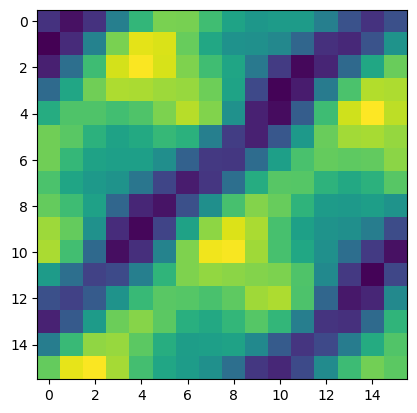



*************
 window number 128: 16 16




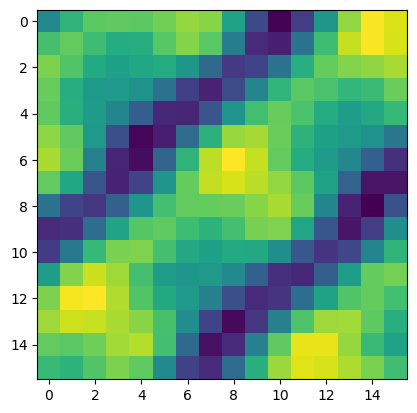



*************
 window number 129: 16 16




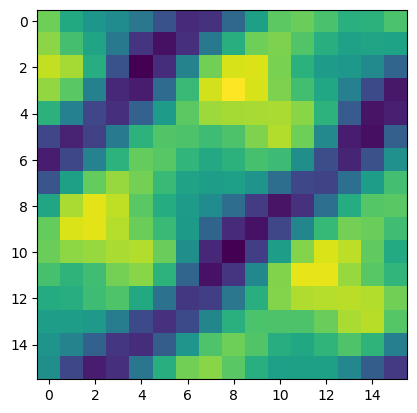



*************
 window number 130: 16 16




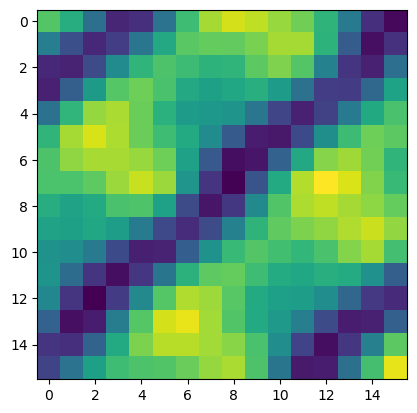



*************
 window number 131: 16 16




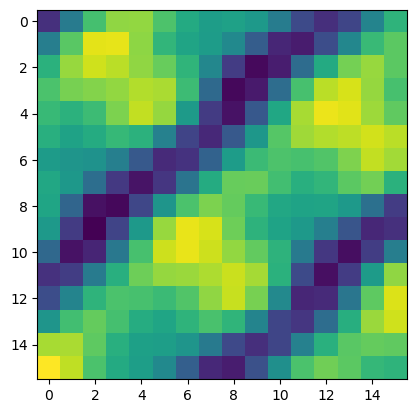



*************
 window number 132: 16 16




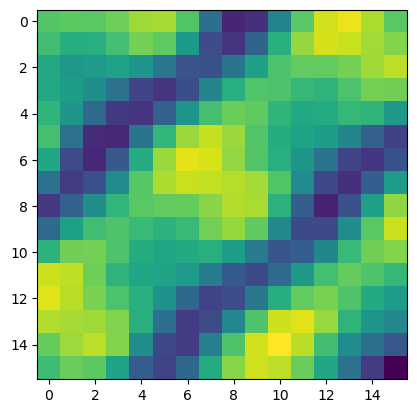



*************
 window number 133: 16 16




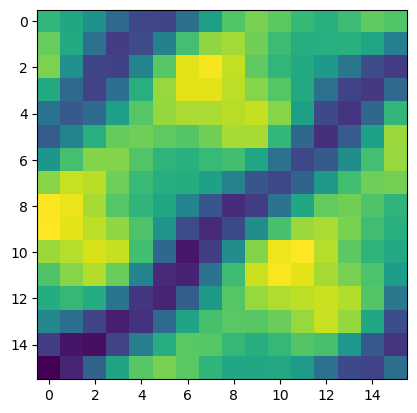



*************
 window number 134: 16 16




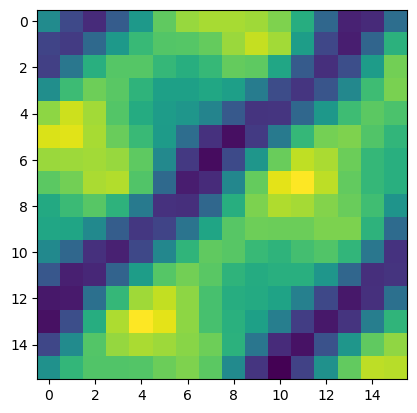



*************
 window number 135: 16 16




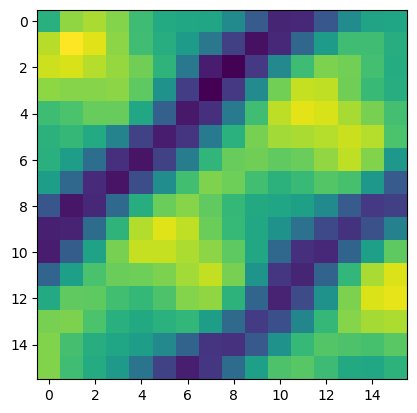



*************
 window number 136: 16 16




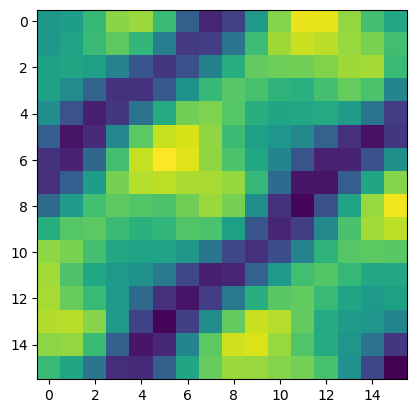



*************
 window number 137: 16 16




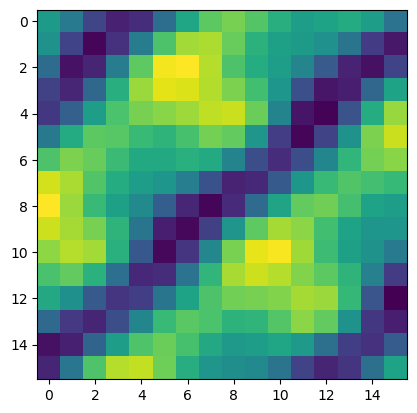



*************
 window number 138: 16 16




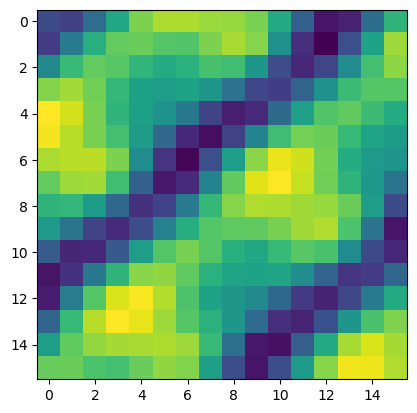



*************
 window number 139: 16 16




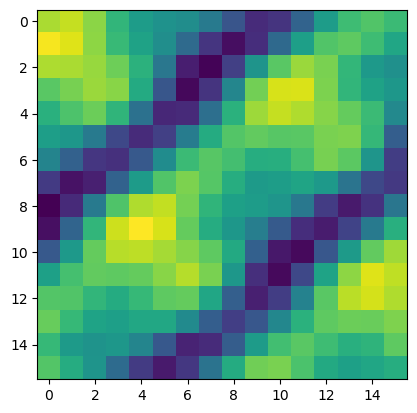



*************
 window number 140: 16 16




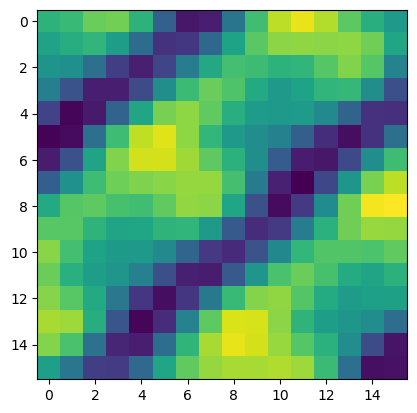



*************
 window number 141: 16 16




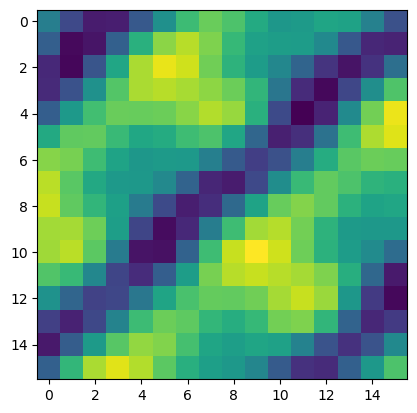



*************
 window number 142: 16 16




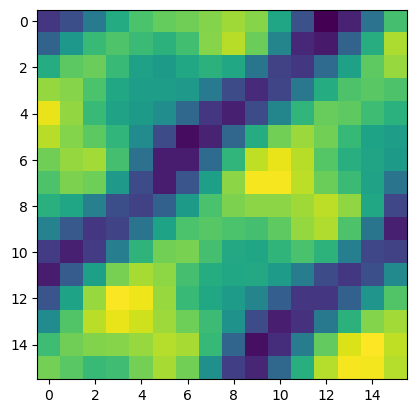



*************
 window number 143: 16 16




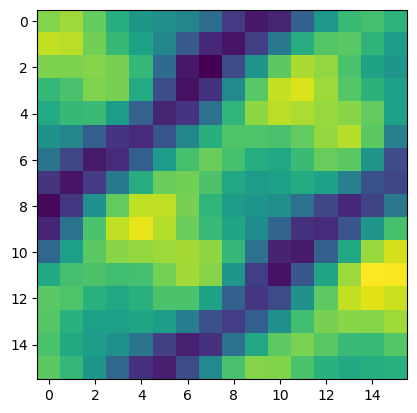



*************
 window number 144: 16 16




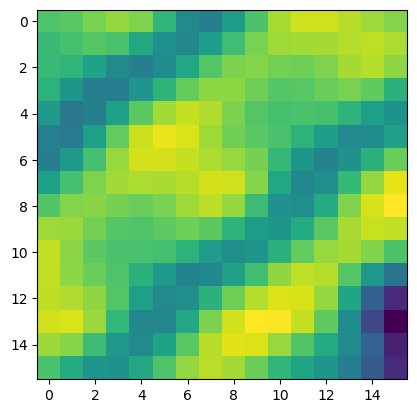



*************
 window number 145: 16 16




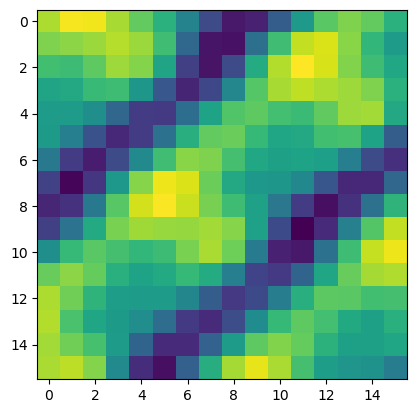



*************
 window number 146: 16 16




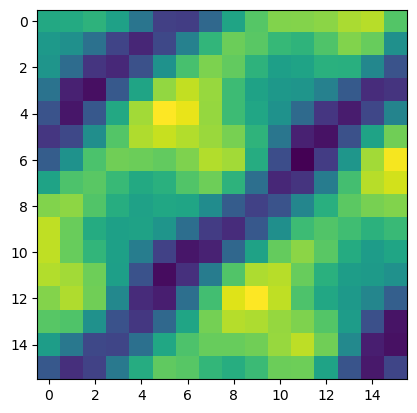



*************
 window number 147: 16 16




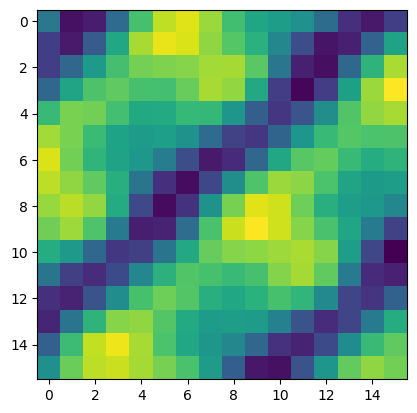



*************
 window number 148: 16 16




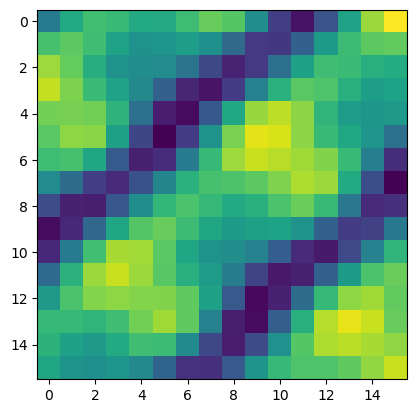



*************
 window number 149: 16 16




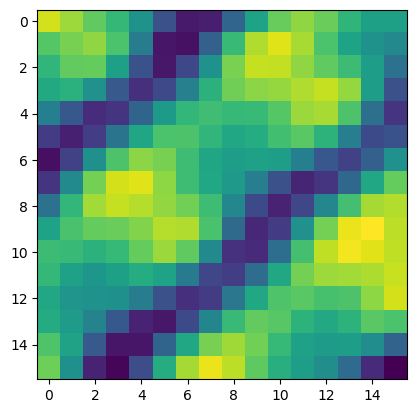



*************
 window number 150: 16 16




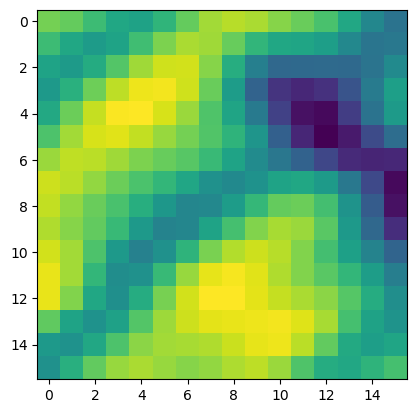



*************
 window number 151: 16 16




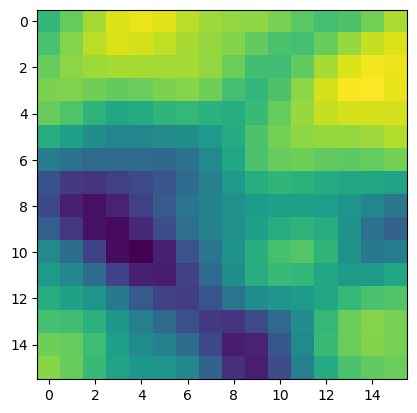



*************
 window number 152: 16 16




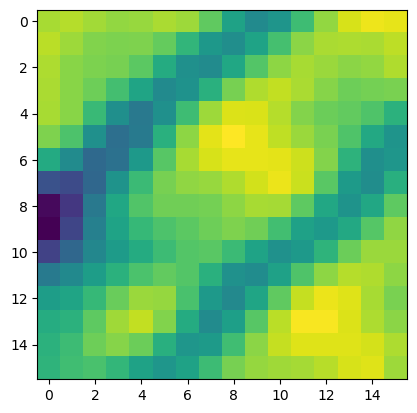



*************
 window number 153: 16 16




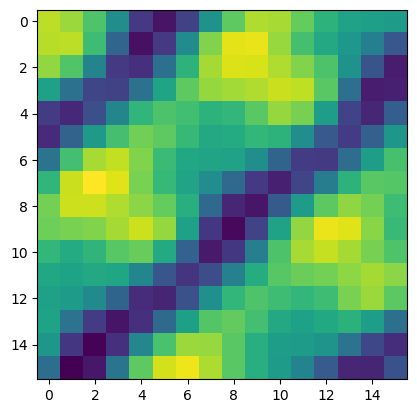



*************
 window number 154: 16 16




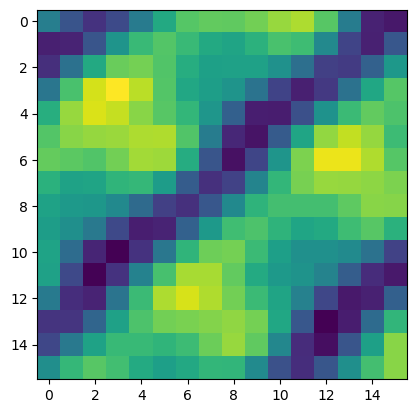



*************
 window number 155: 16 16




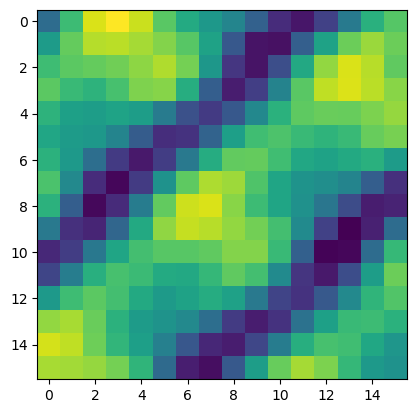



*************
 window number 156: 16 16




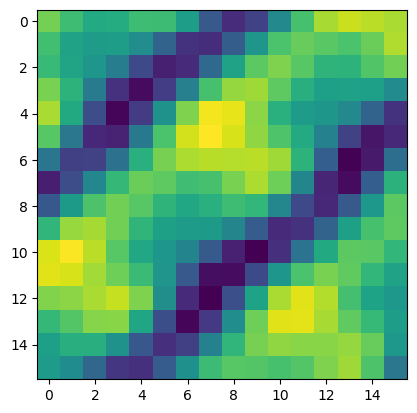



*************
 window number 157: 16 16




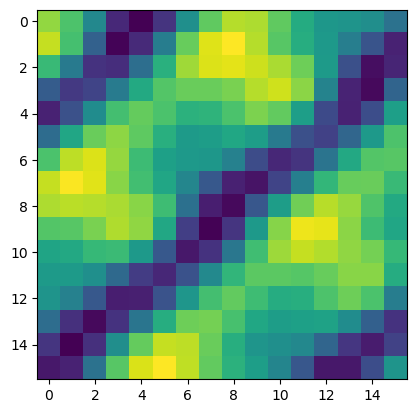



*************
 window number 158: 16 16




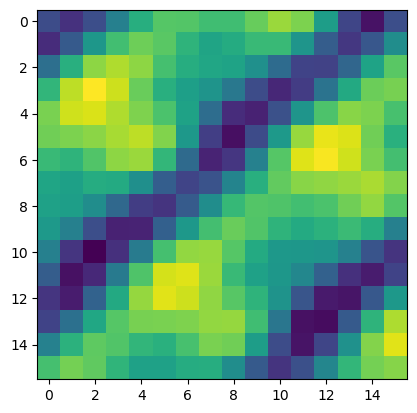



*************
 window number 159: 16 16




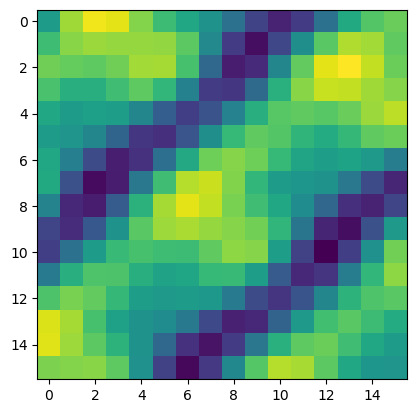



*************
 window number 160: 16 16




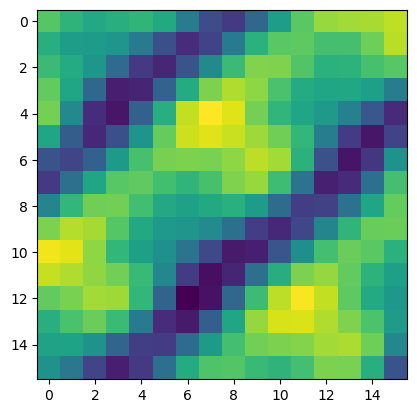



*************
 window number 161: 16 16




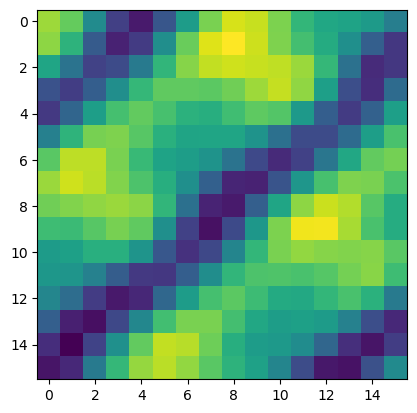



*************
 window number 162: 16 16




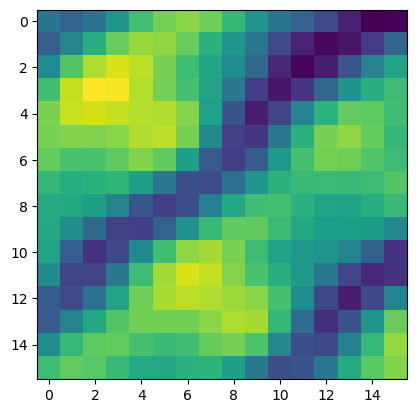



*************
 window number 163: 16 16




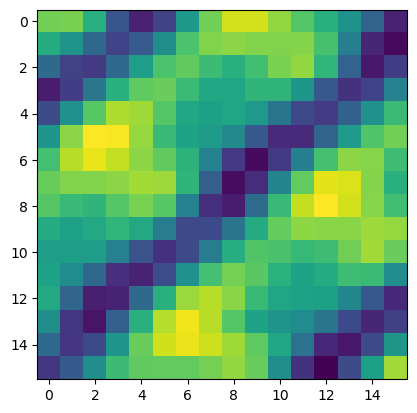



*************
 window number 164: 16 16




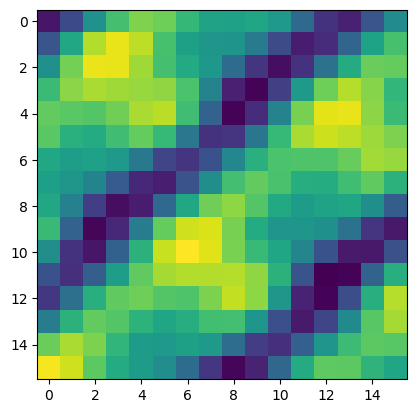



*************
 window number 165: 16 16




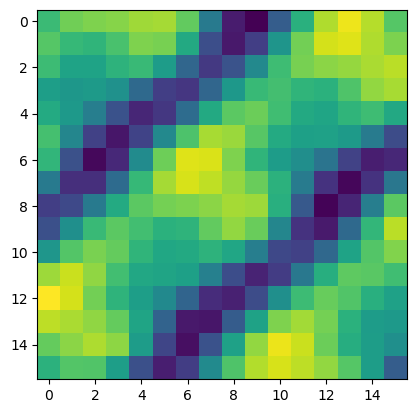



*************
 window number 166: 16 16




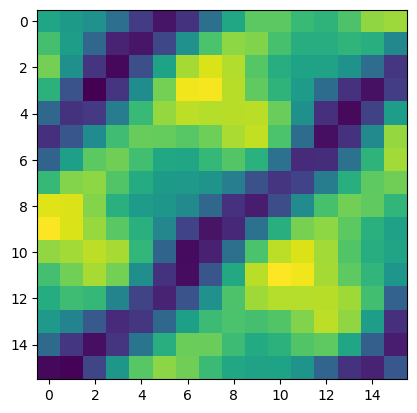



*************
 window number 167: 16 16




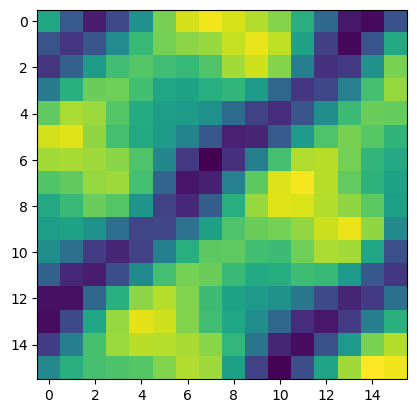



*************
 window number 168: 16 16




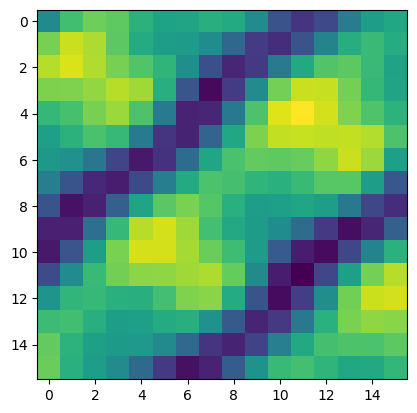



*************
 window number 169: 16 16




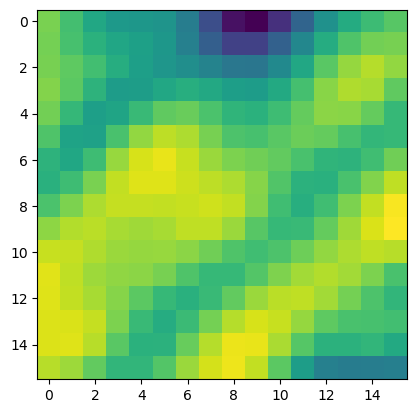



*************
 window number 170: 16 16




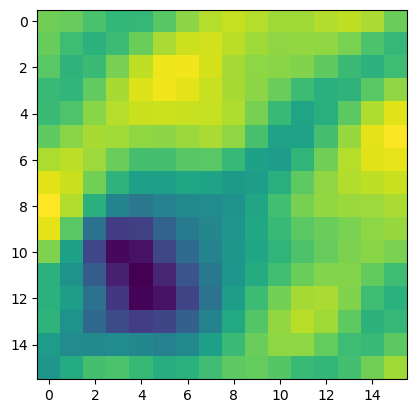



*************
 window number 171: 16 16




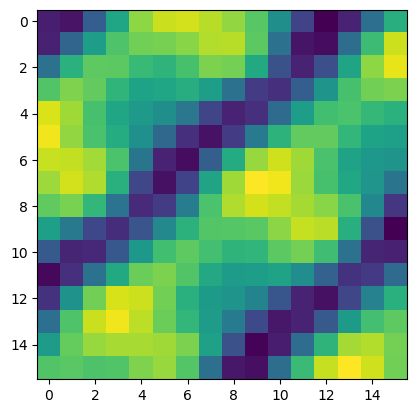



*************
 window number 172: 16 16




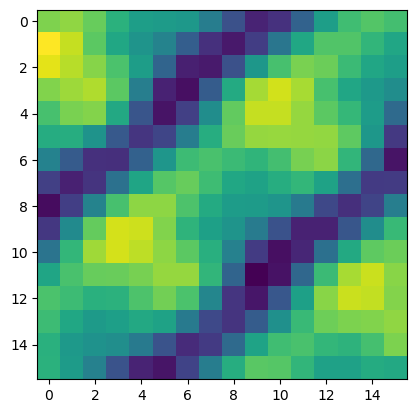



*************
 window number 173: 16 16




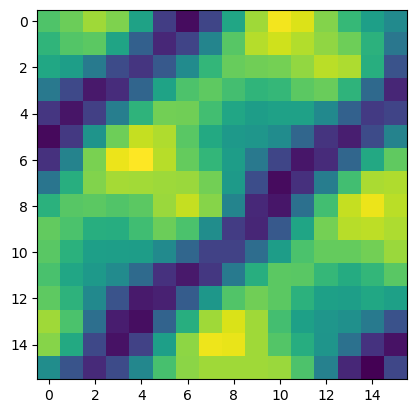



*************
 window number 174: 16 16




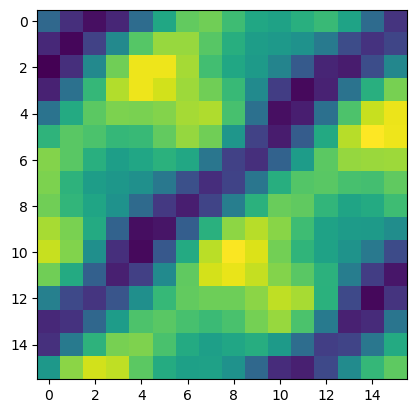



*************
 window number 175: 16 16




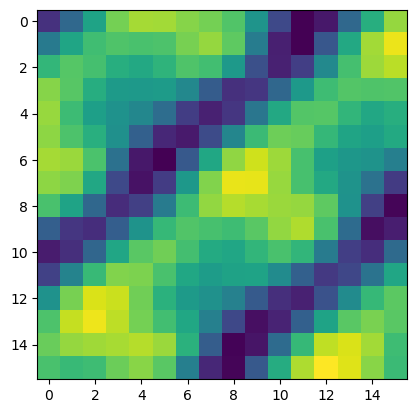



*************
 window number 176: 16 16




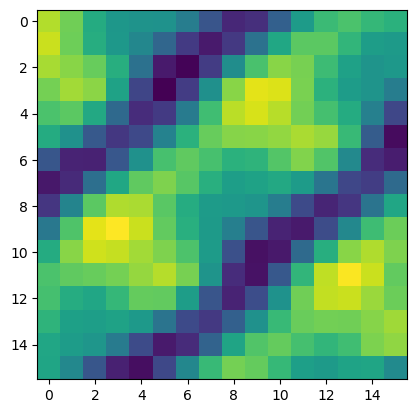



*************
 window number 177: 16 16




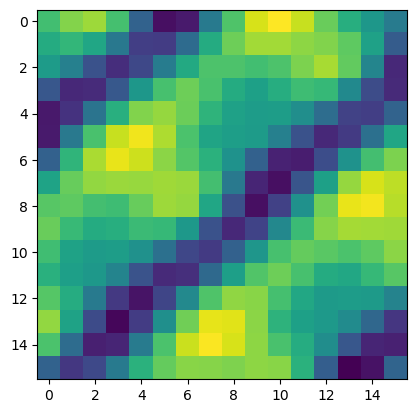



*************
 window number 178: 16 16




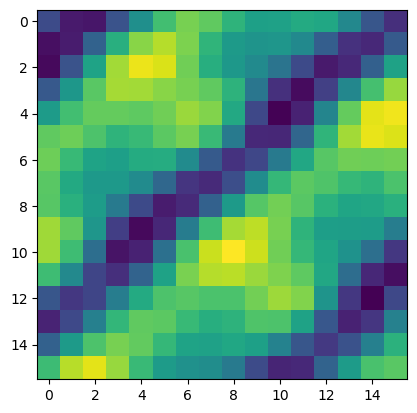



*************
 window number 179: 16 16




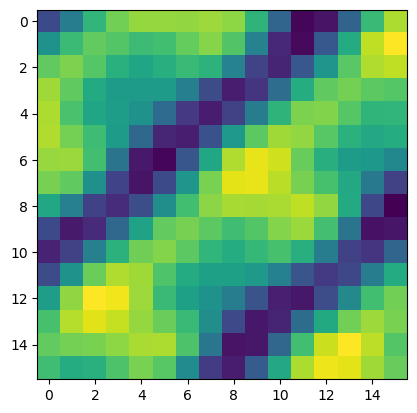



*************
 window number 180: 16 16




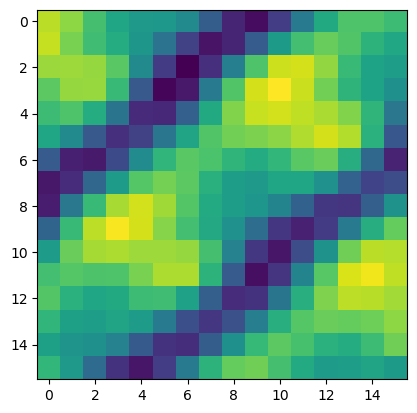



*************
 window number 181: 16 16




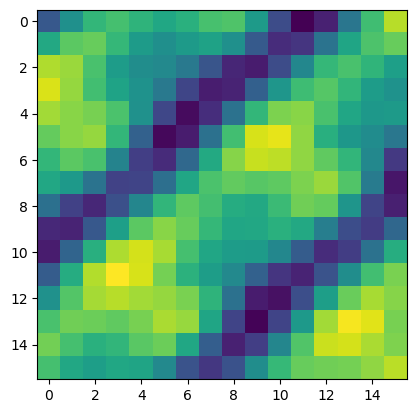



*************
 window number 182: 16 16




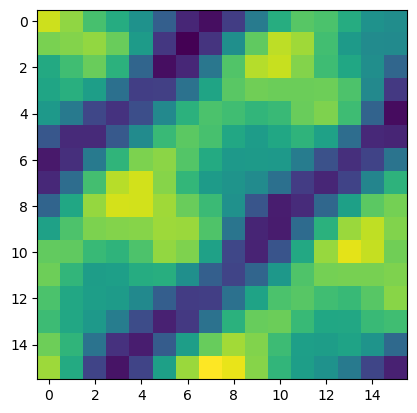



*************
 window number 183: 16 16




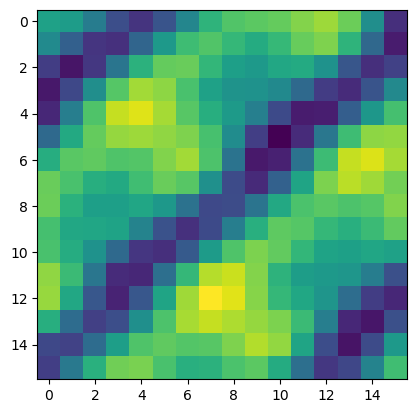



*************
 window number 184: 16 16




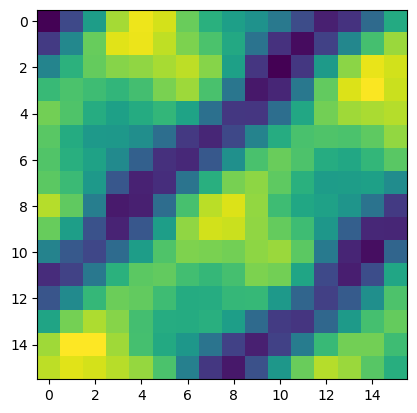



*************
 window number 185: 16 16




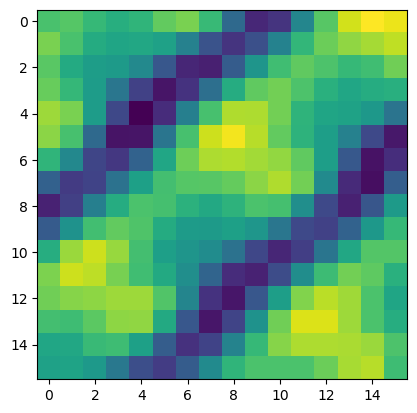



*************
 window number 186: 16 16




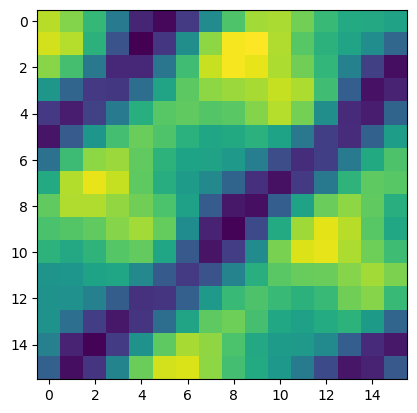



*************
 window number 187: 16 16




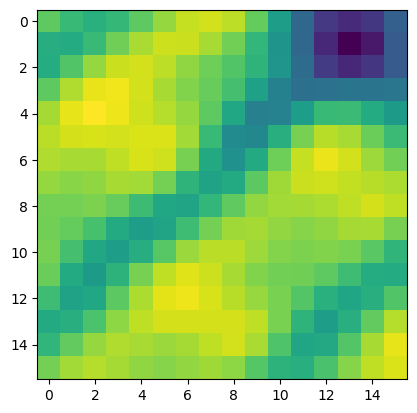



*************
 window number 188: 16 16




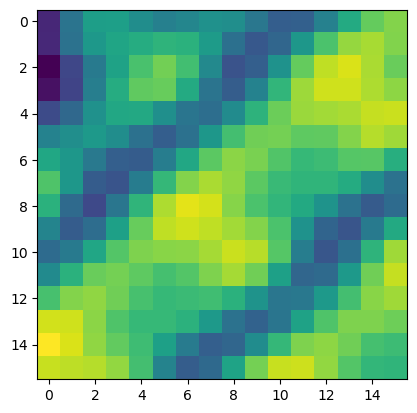



*************
 window number 189: 16 16




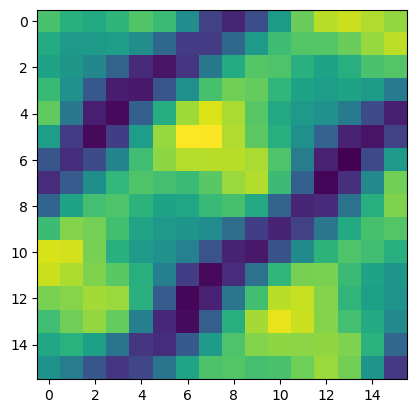



*************
 window number 190: 16 16




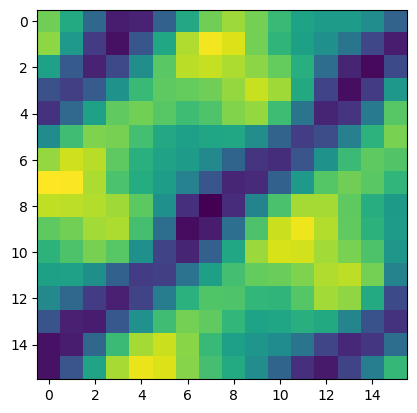



*************
 window number 191: 16 16




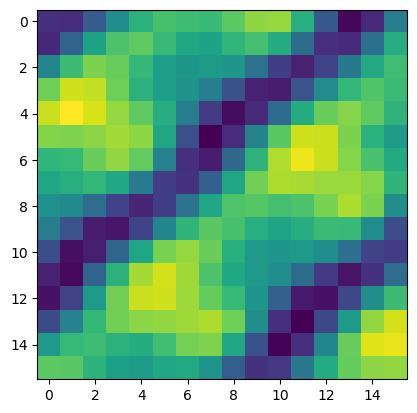



*************
 window number 192: 16 16




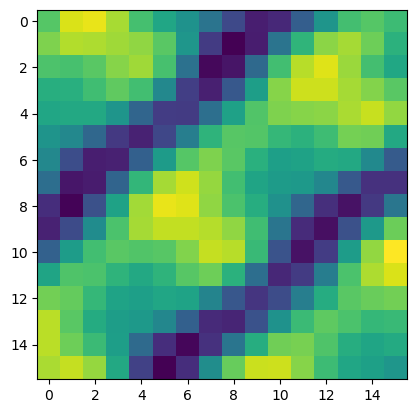



*************
 window number 193: 16 16




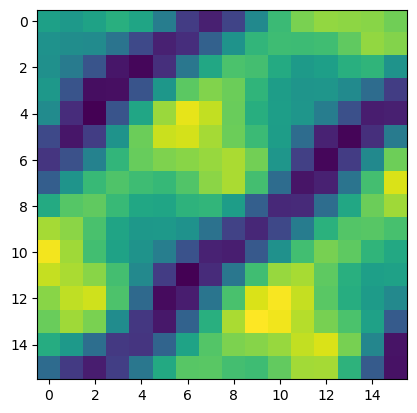



*************
 window number 194: 16 16




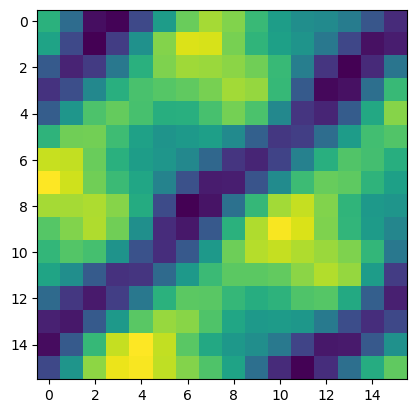



*************
 window number 195: 16 16




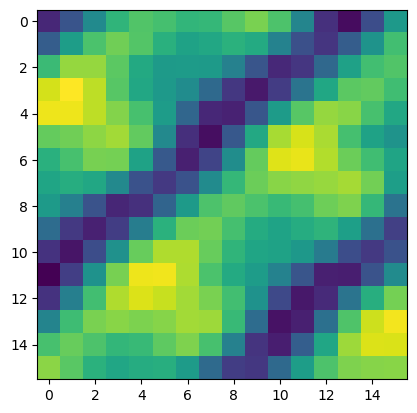



*************
 window number 196: 16 16




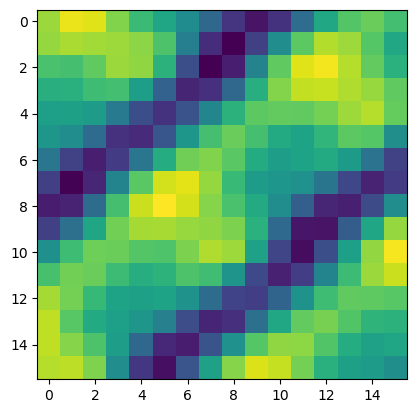



*************
 window number 197: 16 16




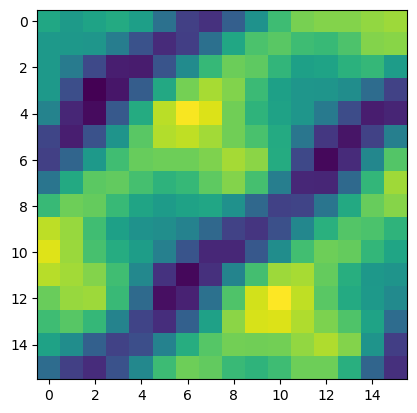



*************
 window number 198: 16 16




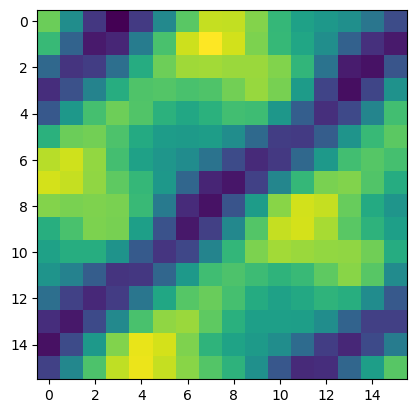



*************
 window number 199: 16 16




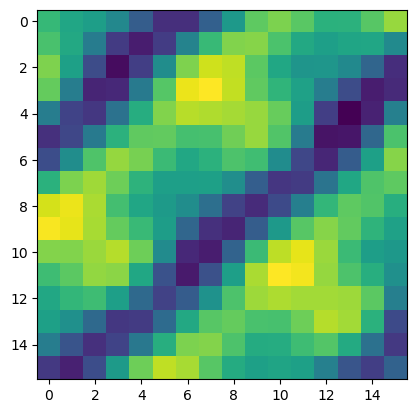



*************
 window number 200: 16 16




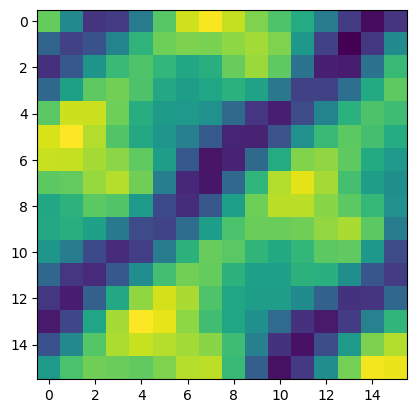



*************
 window number 201: 16 16




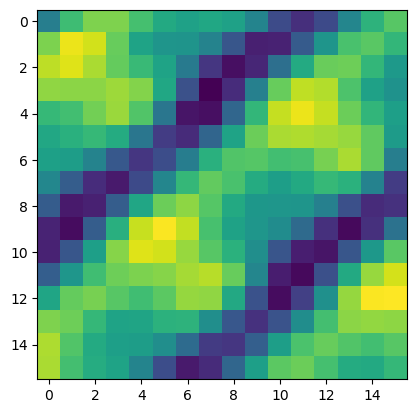



*************
 window number 202: 16 16




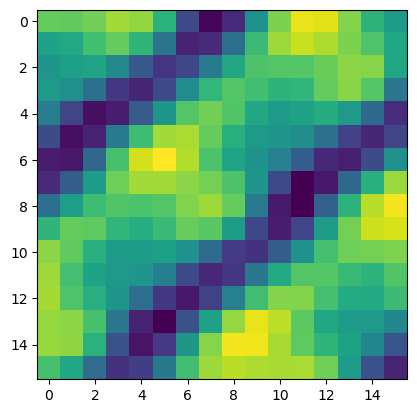



*************
 window number 203: 16 16




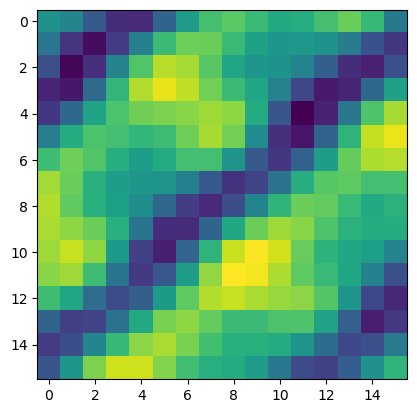



*************
 window number 204: 16 16




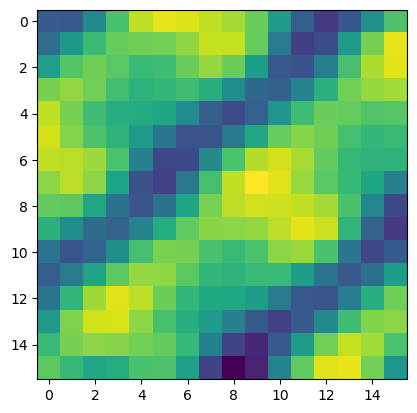



*************
 window number 205: 16 16




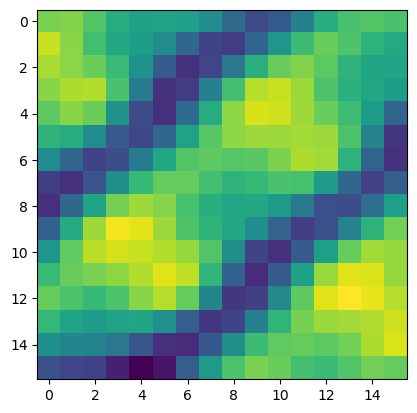



*************
 window number 206: 16 16




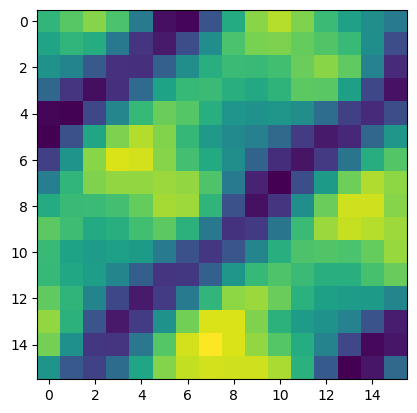



*************
 window number 207: 16 16




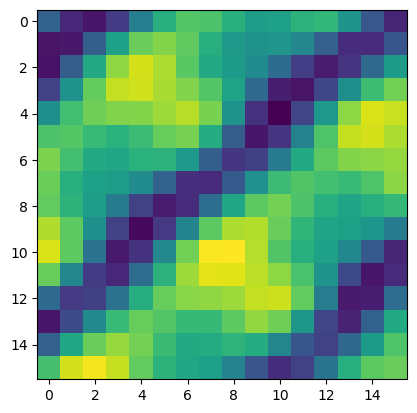



*************
 window number 208: 16 16




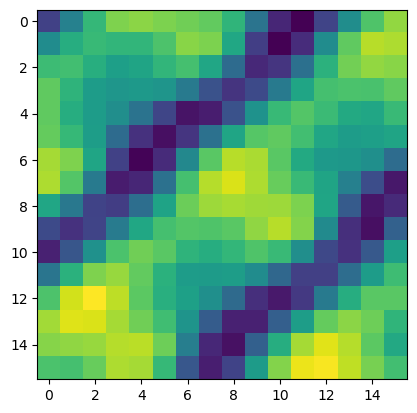



*************
 window number 209: 16 16




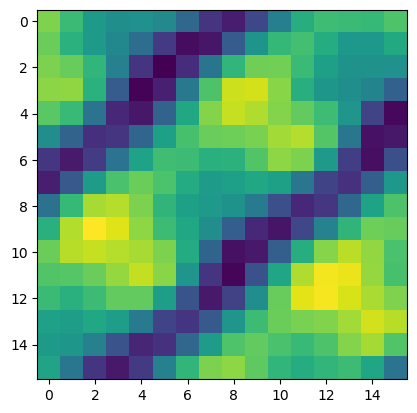



*************
 window number 210: 16 16




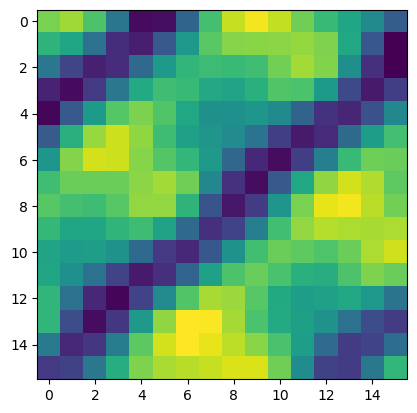



*************
 window number 211: 16 16




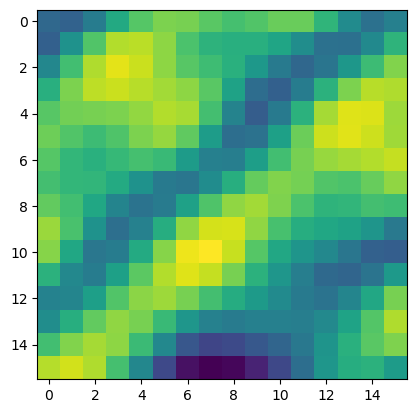



*************
 window number 212: 16 16




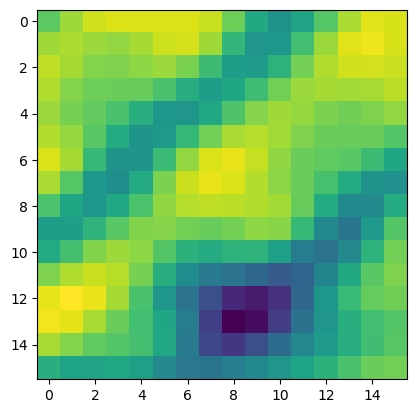



*************
 window number 213: 16 16




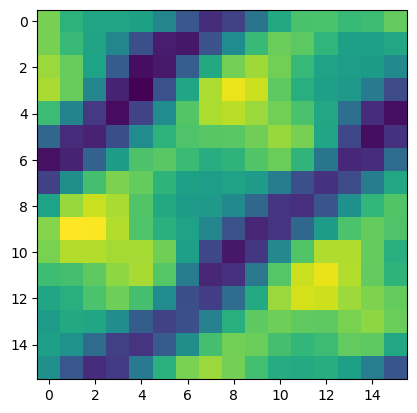



*************
 window number 214: 16 16




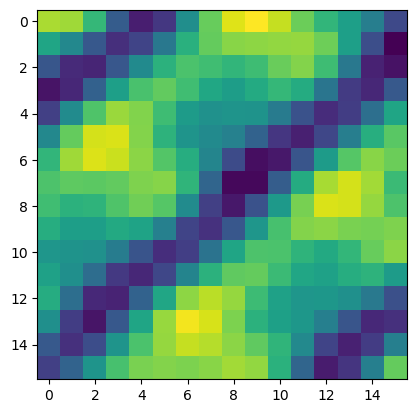



*************
 window number 215: 16 16




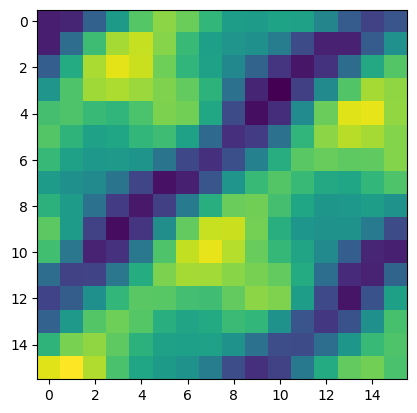



*************
 window number 216: 16 16




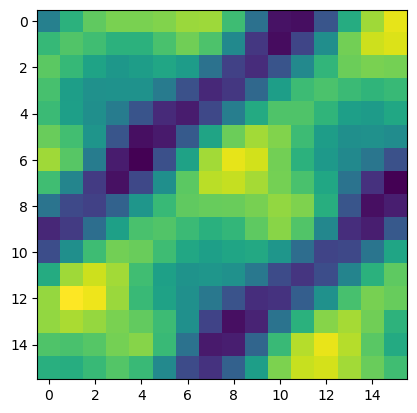



*************
 window number 217: 16 16




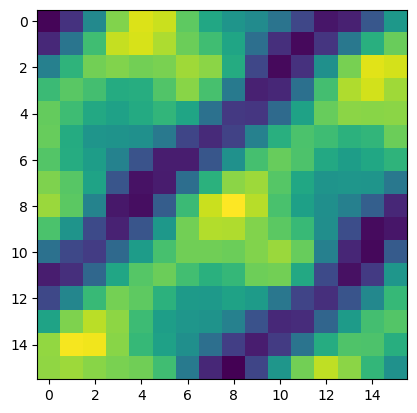



*************
 window number 218: 16 16




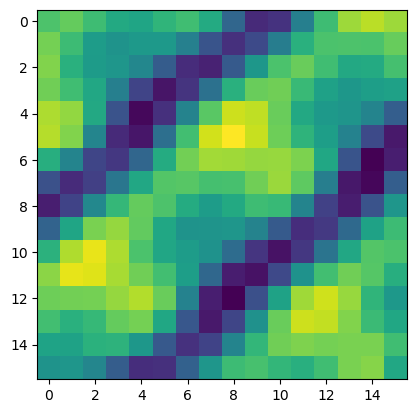



*************
 window number 219: 16 16




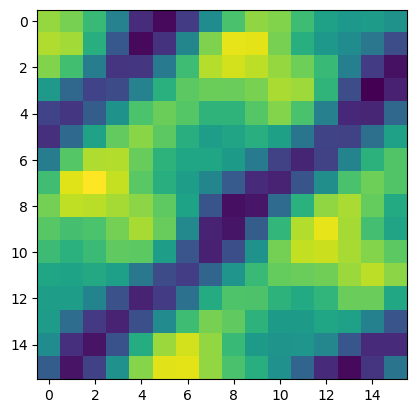



*************
 window number 220: 16 16




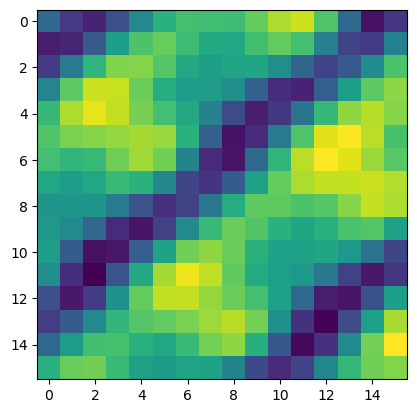



*************
 window number 221: 16 16




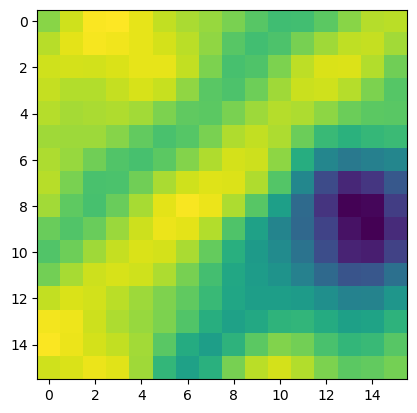



*************
 window number 222: 16 16




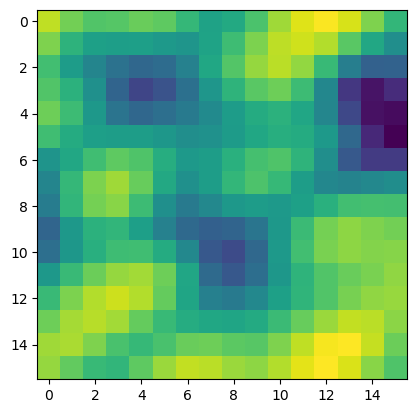



*************
 window number 223: 16 16




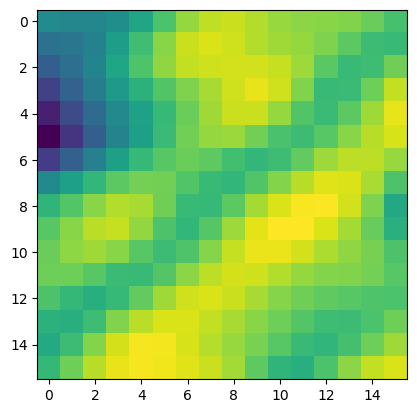



*************
 window number 224: 16 16




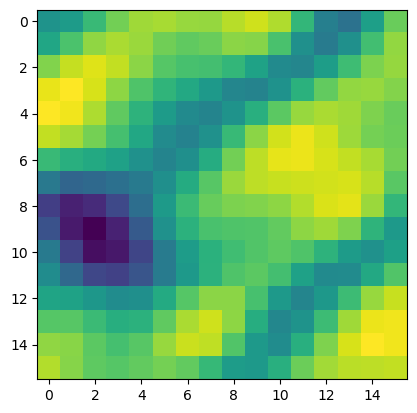



*************
 window number 225: 16 16




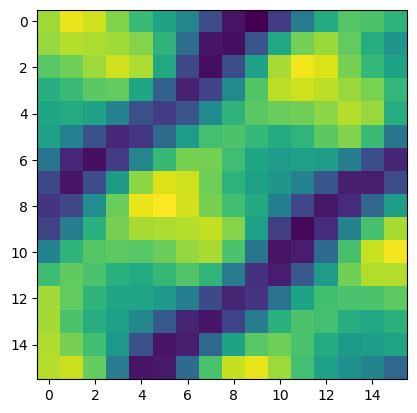



*************
 window number 226: 16 16




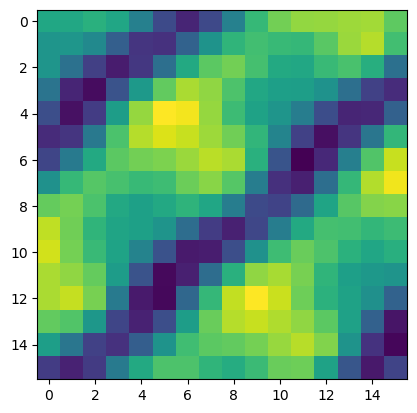



*************
 window number 227: 16 16




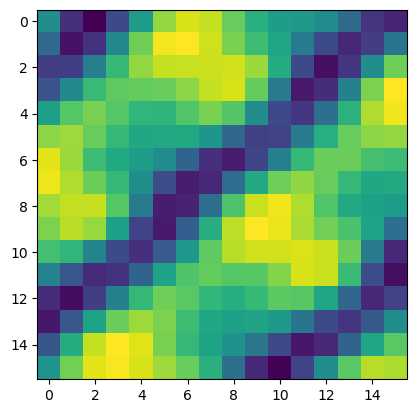



*************
 window number 228: 16 16




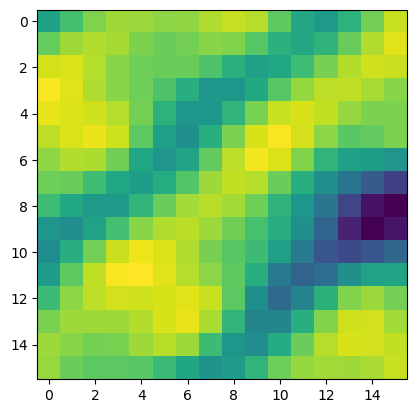



*************
 window number 229: 16 16




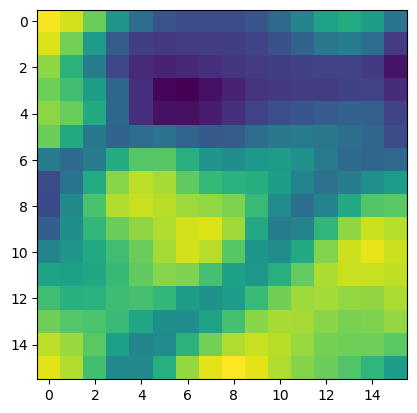



*************
 window number 230: 16 16




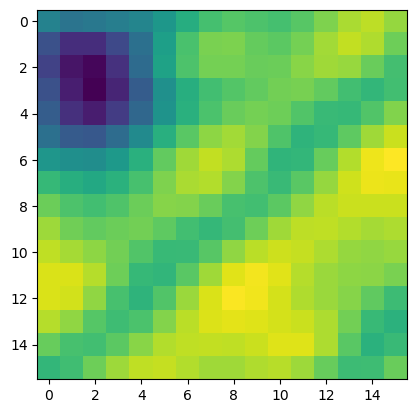



*************
 window number 231: 16 16




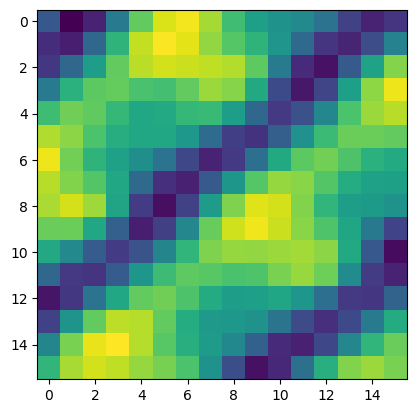



*************
 window number 232: 16 16




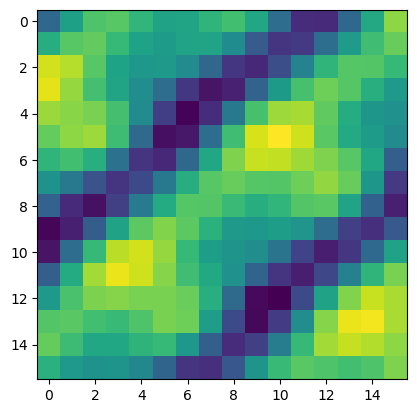



*************
 window number 233: 16 16




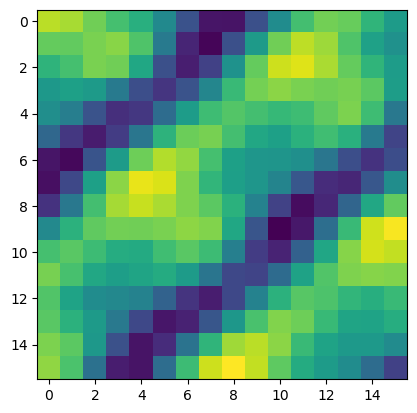



*************
 window number 234: 16 16




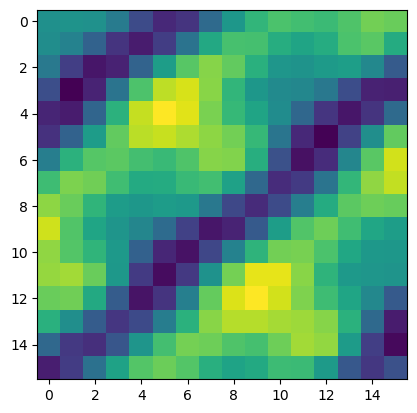



*************
 window number 235: 16 16




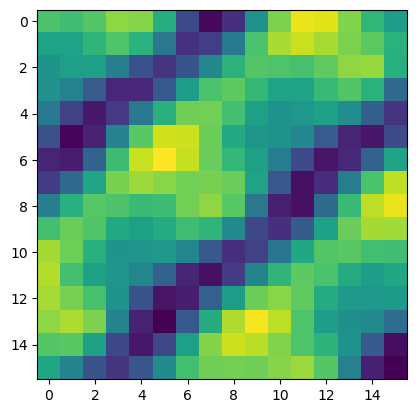



*************
 window number 236: 16 16




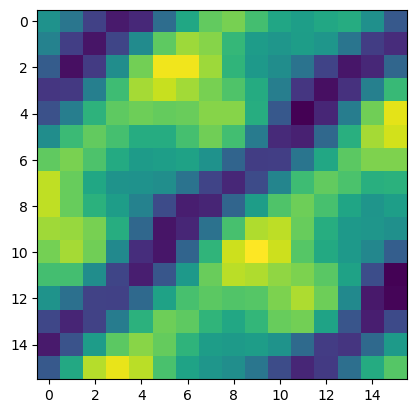



*************
 window number 237: 16 16




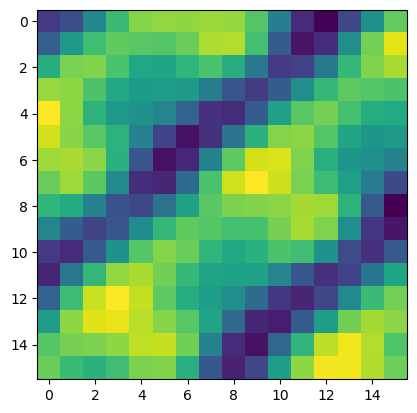



*************
 window number 238: 16 16




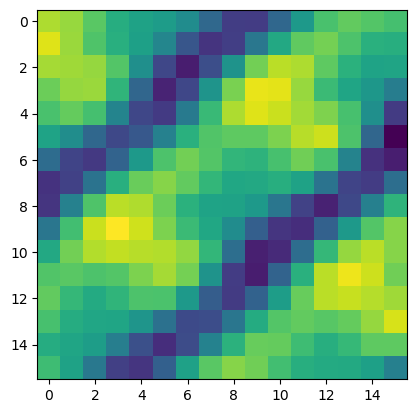



*************
 window number 239: 16 16




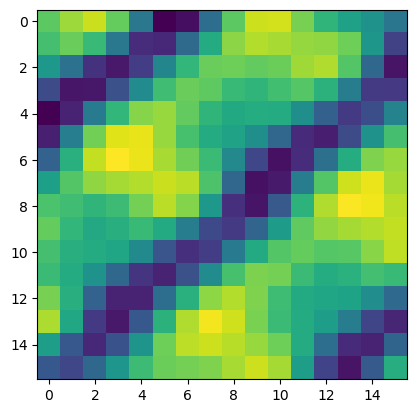



*************
 window number 240: 16 16




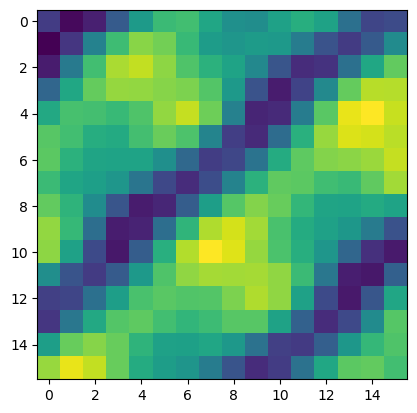



*************
 window number 241: 16 16




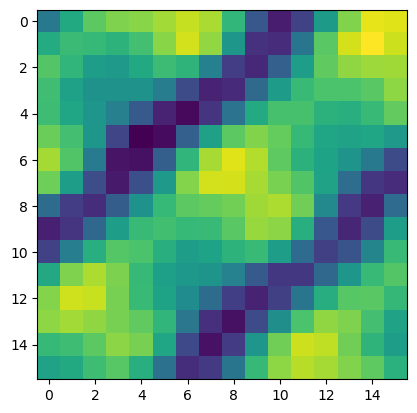



*************
 window number 242: 16 16




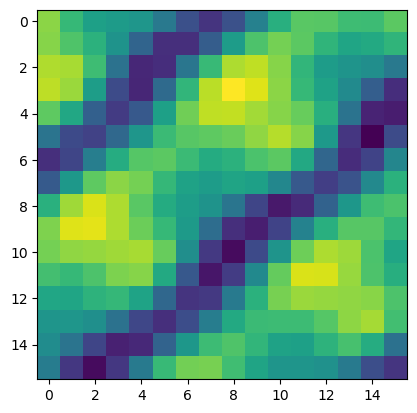



*************
 window number 243: 16 16




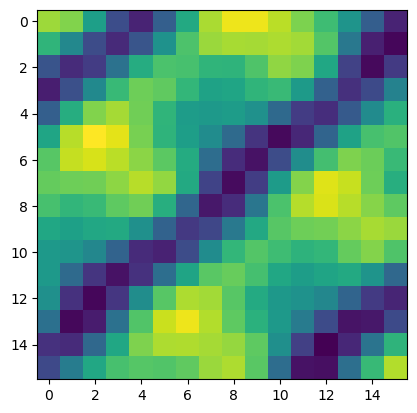



*************
 window number 244: 16 16




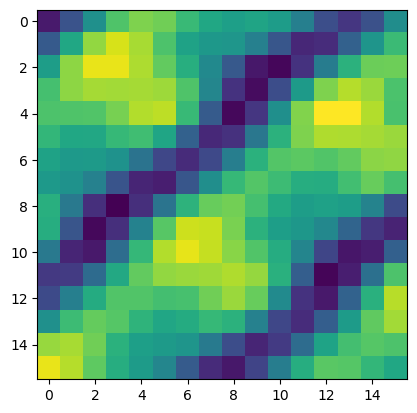



*************
 window number 245: 16 16




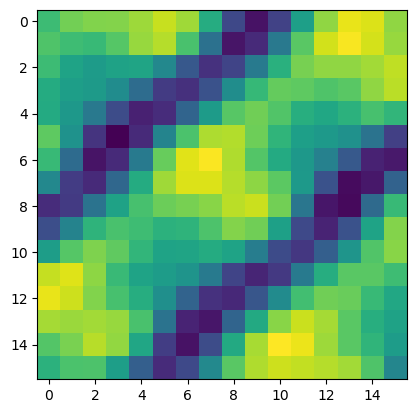



*************
 window number 246: 16 16




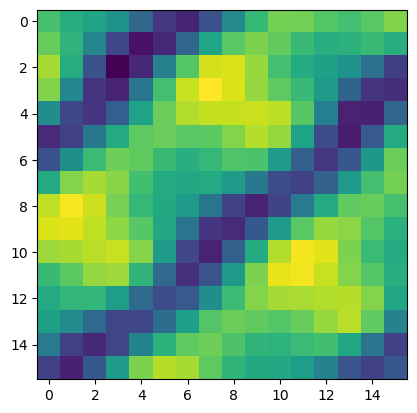



*************
 window number 247: 16 16




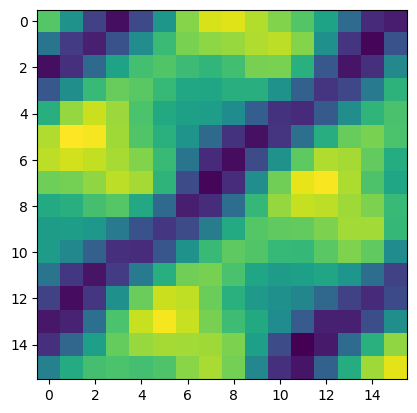



*************
 window number 248: 16 16




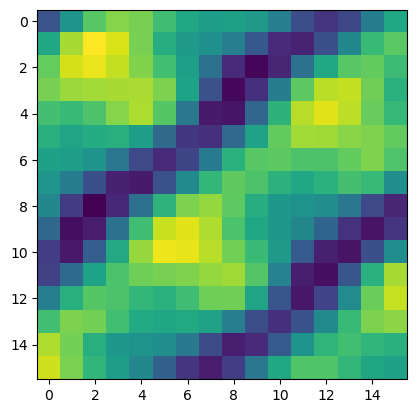



*************
 window number 249: 16 16




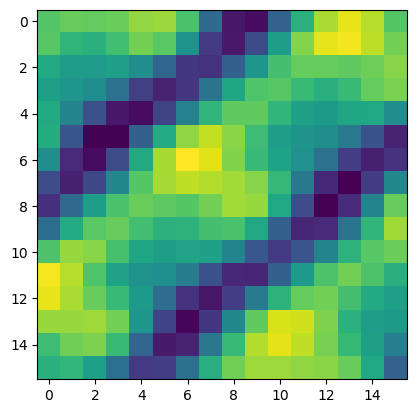



*************
 window number 250: 16 16




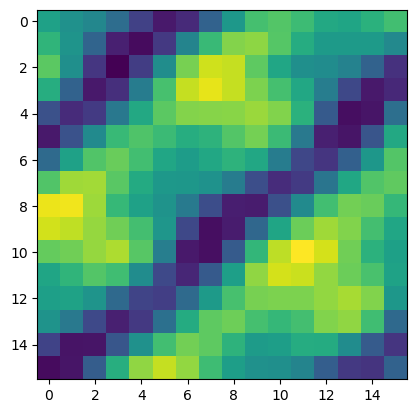



*************
 window number 251: 16 16




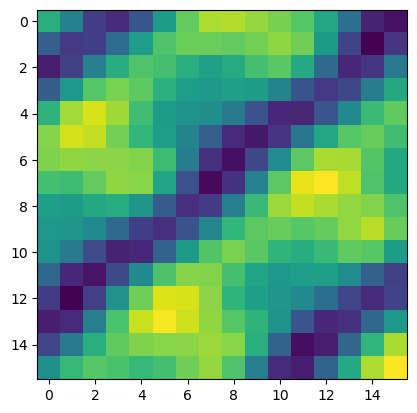



*************
 window number 252: 16 16




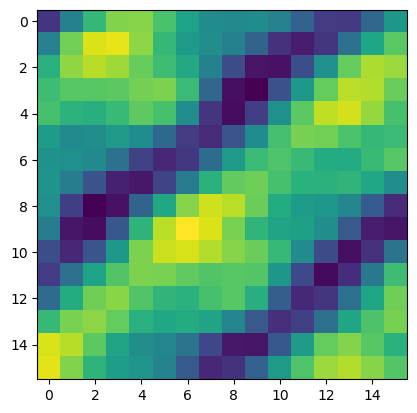



*************
 window number 253: 16 16




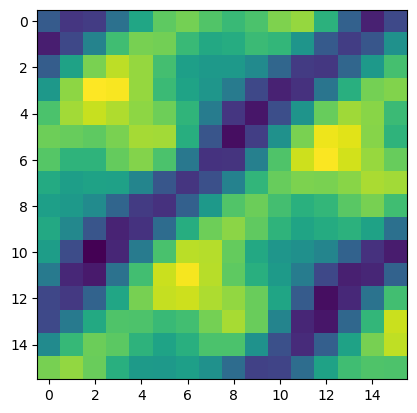



*************
 window number 254: 16 16




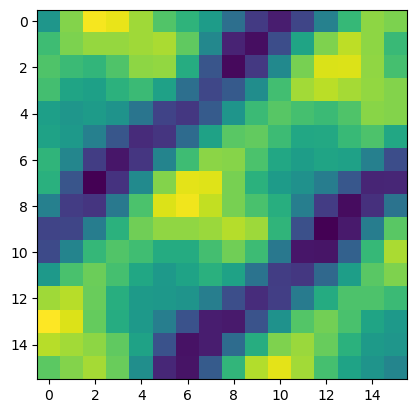



*************
 window number 255: 16 16




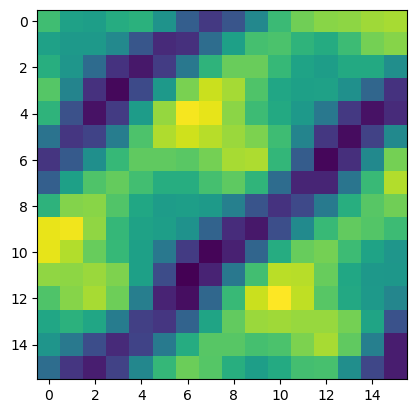



*************
 window number 256: 16 16




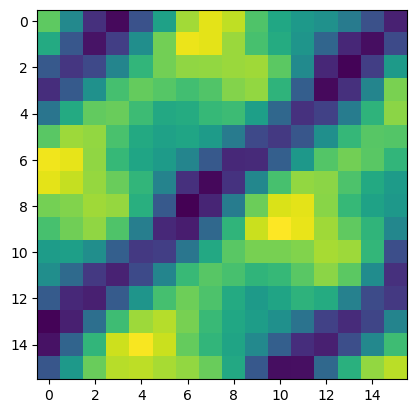



*************
 window number 257: 16 16




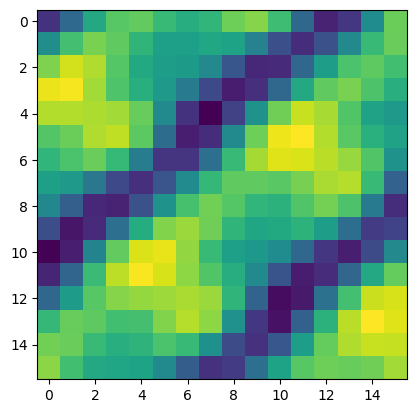



*************
 window number 258: 16 16




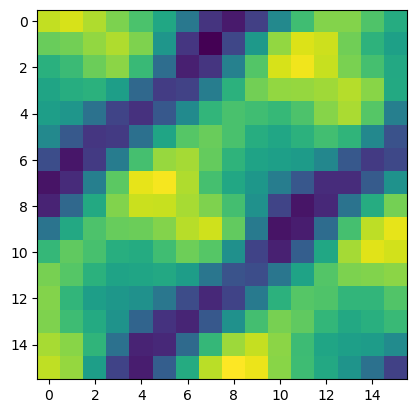



*************
 window number 259: 16 16




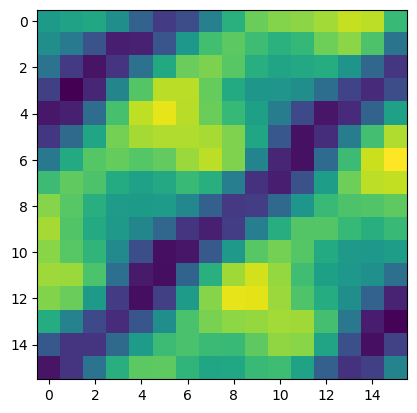



*************
 window number 260: 16 16




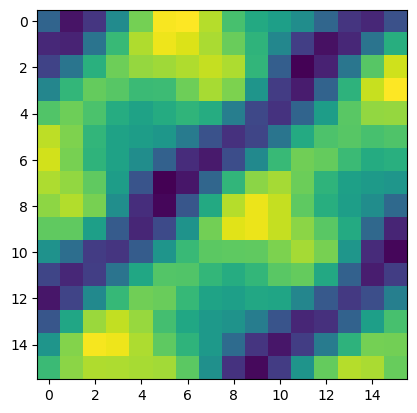



*************
 window number 261: 16 16




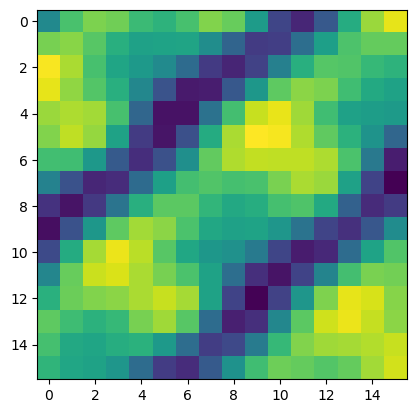



*************
 window number 262: 16 16




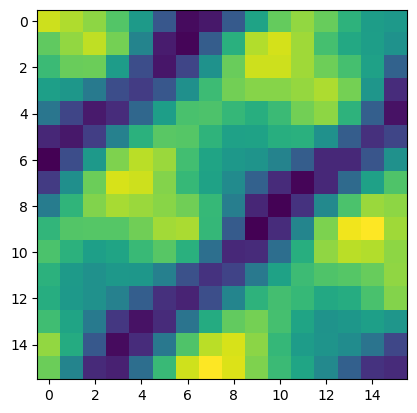



*************
 window number 263: 16 16




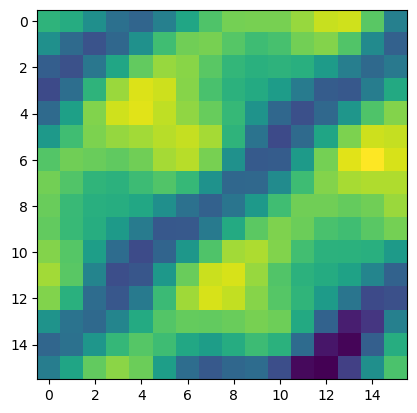



*************
 window number 264: 16 16




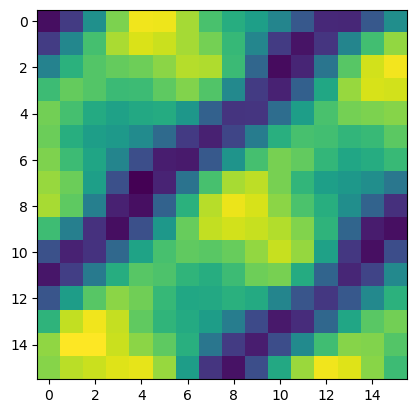



*************
 window number 265: 16 16




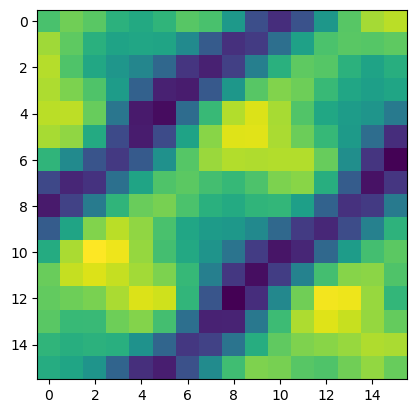



*************
 window number 266: 16 16




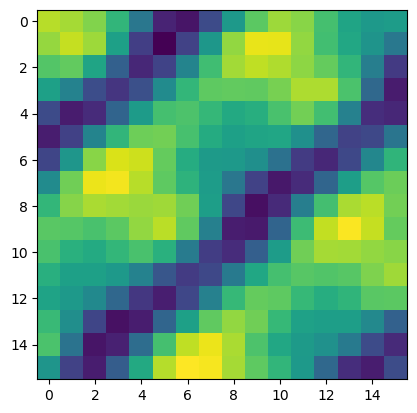



*************
 window number 267: 16 16




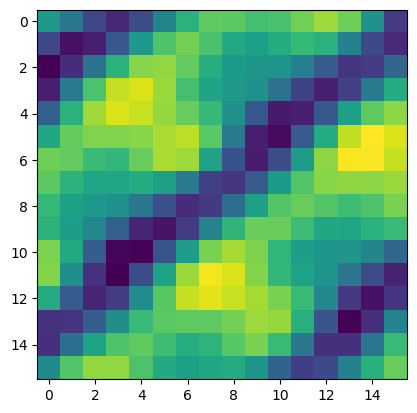



*************
 window number 268: 16 16




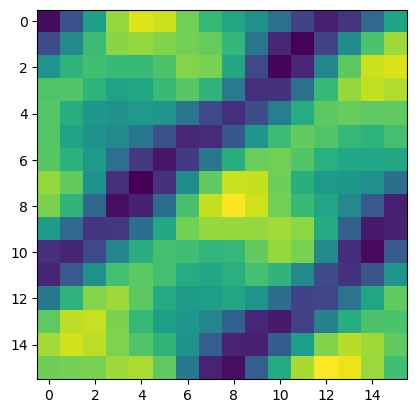



*************
 window number 269: 16 16




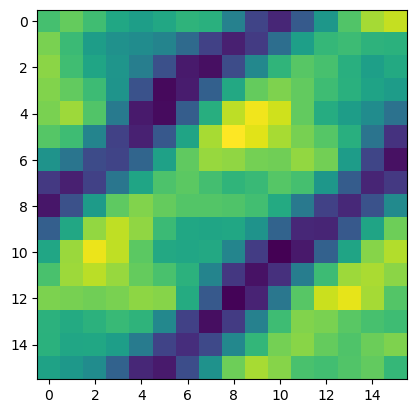



*************
 window number 270: 16 16




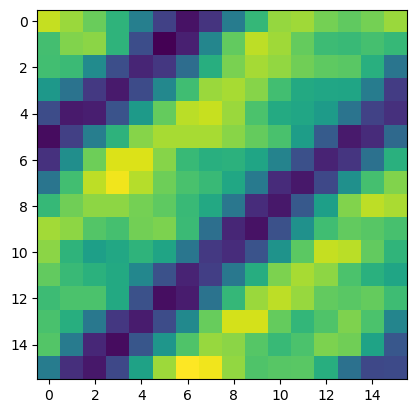



*************
 window number 271: 16 16




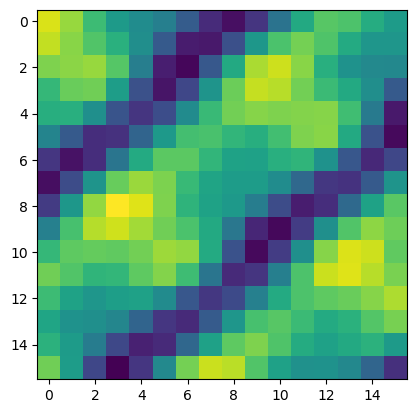



*************
 window number 272: 16 16




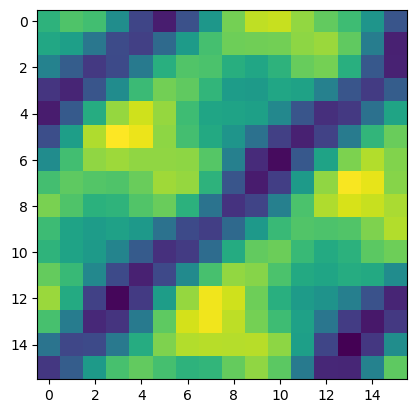



*************
 window number 273: 16 16




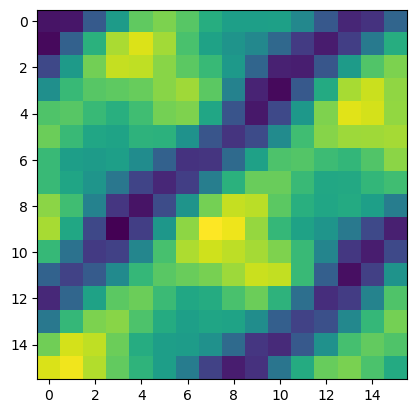



*************
 window number 274: 16 16




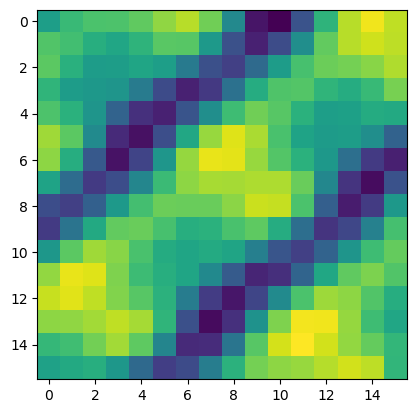



*************
 window number 275: 16 16




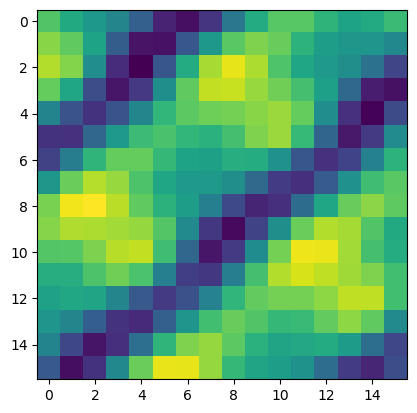



*************
 window number 276: 16 16




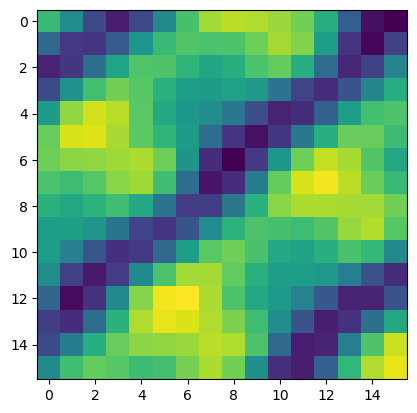



*************
 window number 277: 16 16




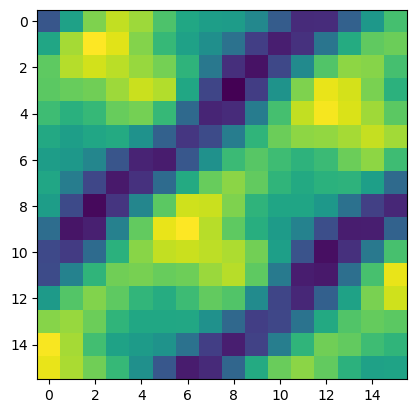



*************
 window number 278: 16 16




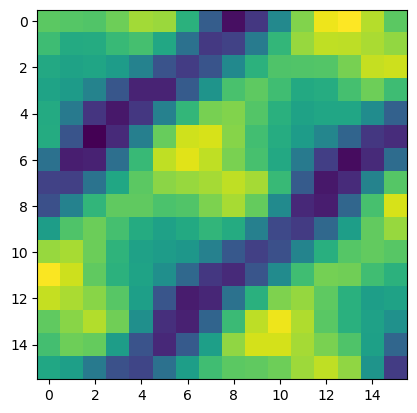



*************
 window number 279: 16 16




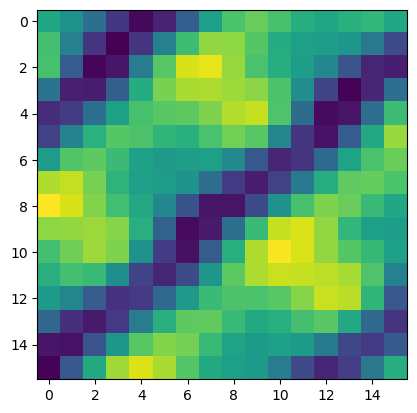



*************
 window number 280: 16 16




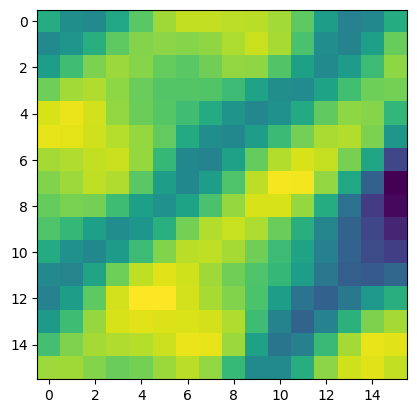



*************
 window number 281: 16 16




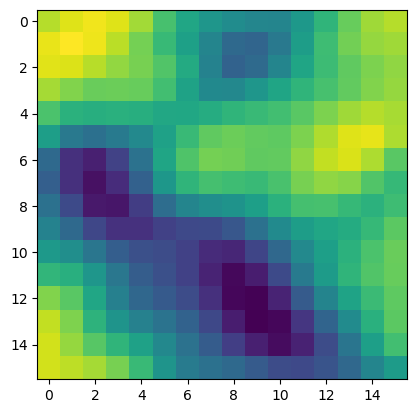



*************
 window number 282: 16 16




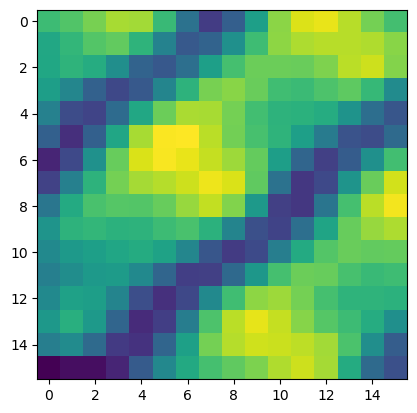



*************
 window number 283: 16 16




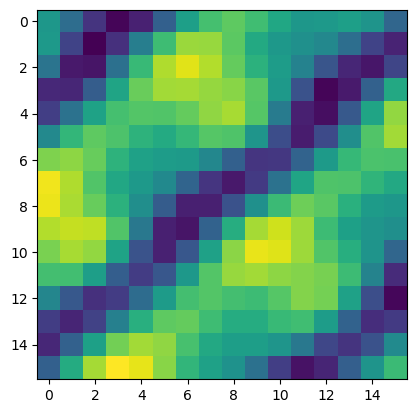



*************
 window number 284: 16 16




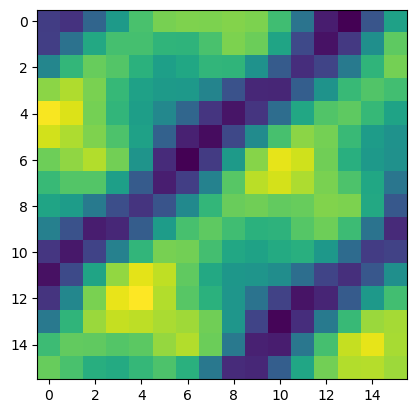



*************
 window number 285: 16 16




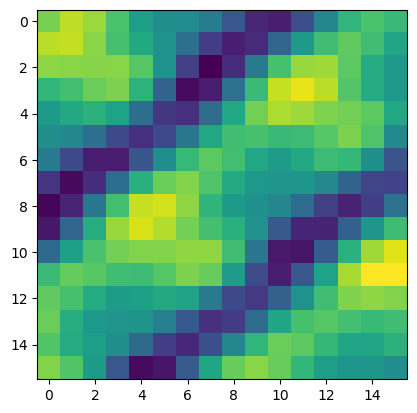



*************
 window number 286: 16 16




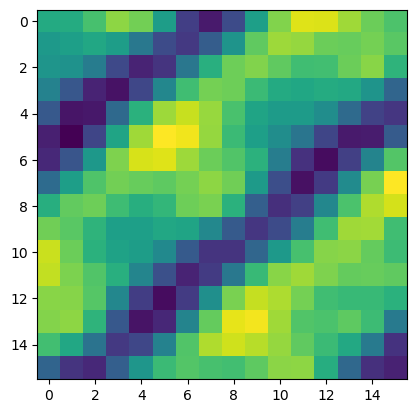



*************
 window number 287: 16 16




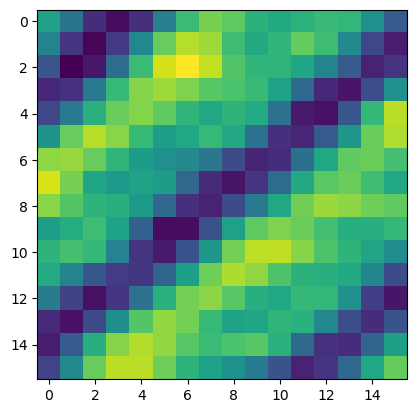



*************
 window number 288: 16 16




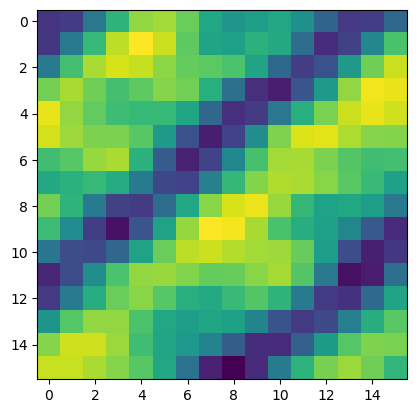



*************
 window number 289: 16 16




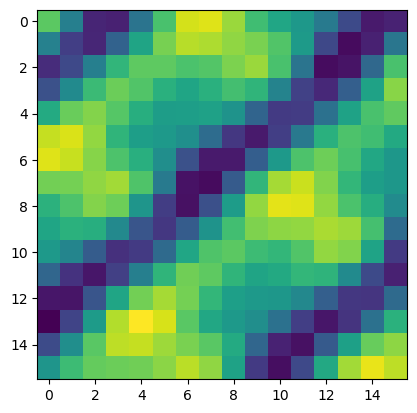



*************
 window number 290: 16 16




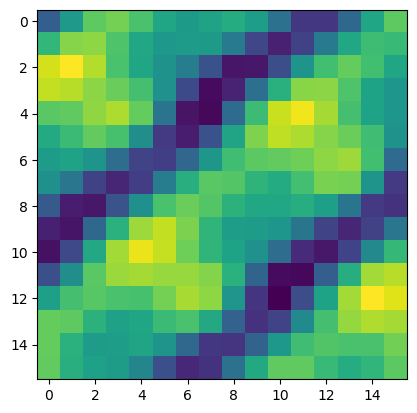



*************
 window number 291: 16 16




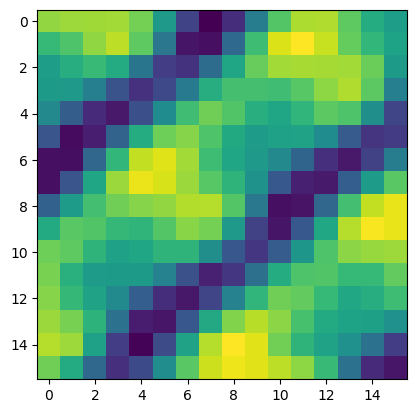



*************
 window number 292: 16 16




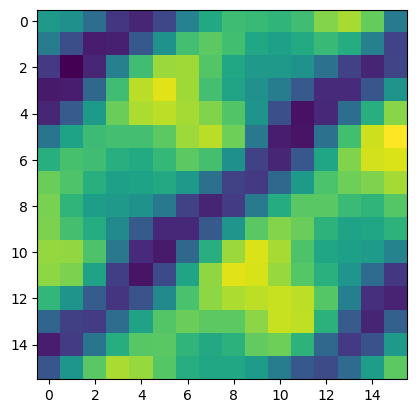



*************
 window number 293: 16 16




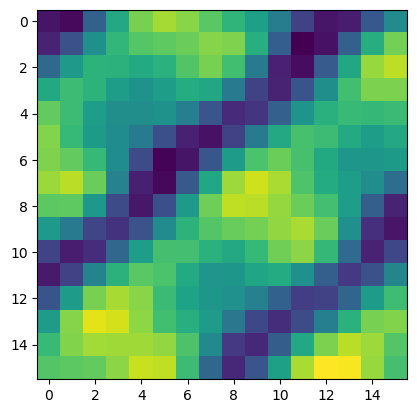



*************
 window number 294: 16 16




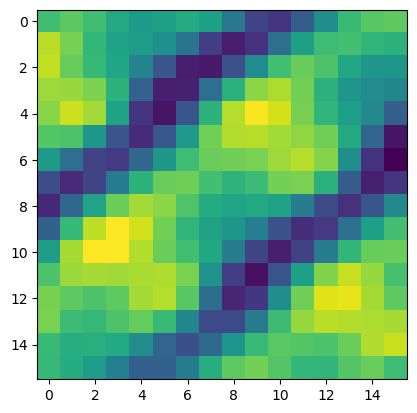



*************
 window number 295: 16 16




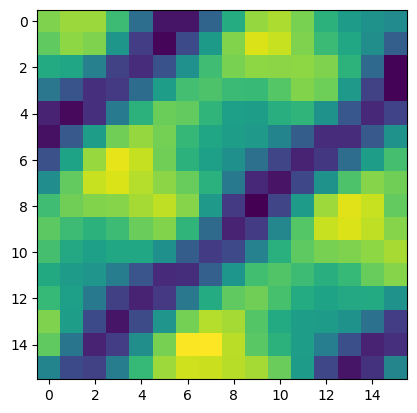



*************
 window number 296: 16 16




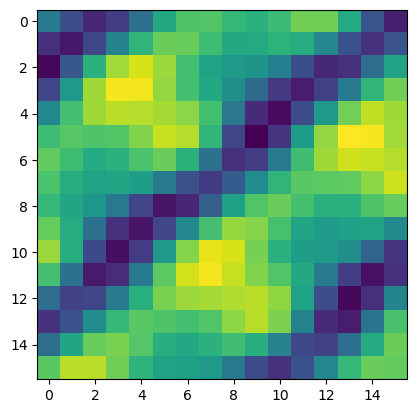



*************
 window number 297: 16 16




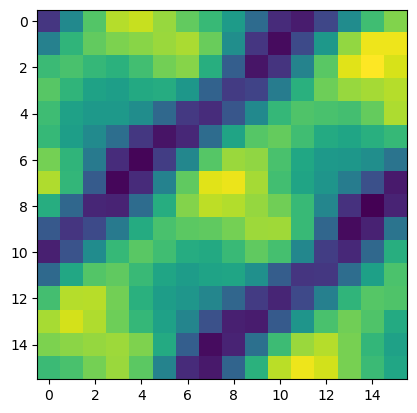



*************
 window number 298: 16 16




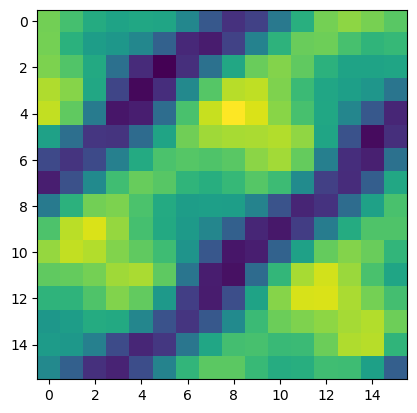



*************
 window number 299: 16 16




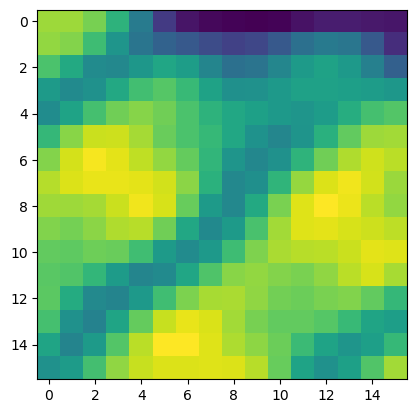



*************
 window number 300: 16 16




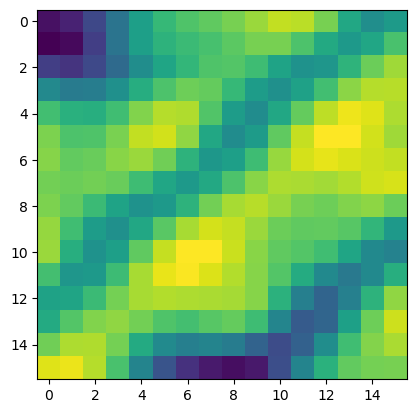



*************
 window number 301: 16 16




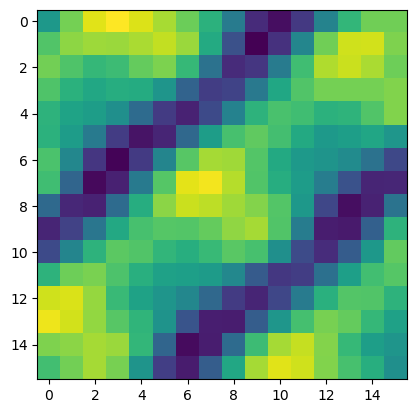



*************
 window number 302: 16 16




In [ ]:
# Training data
mtrx_train_file_list, _ = dp.list_files_by_extension(mtrx_train_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_train_file_list[0:mtrx_train_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = True,
    save_window_jpgs=True,
    save_jpg = True,
    together = together,
    collate = collate,
    verbose = False
    )

# Test data
mtrx_test_file_list, _ = dp.list_files_by_extension(mtrx_test_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_test_file_list[0:mtrx_test_data_limit],
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, window_pitch = window_pitch,
    save_windows = True,
    save_window_jpgs=True,
    save_jpg = True,
    together = together,
    collate = collate,
    verbose = False
    )

### Build tensorflow data pipeline for training and validation of autoencoder

In [ ]:
# Training data - tensorflow data pipeline for autoencoder
windows_train_path = os.path.join(job_data_path, 'windows/train')
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

# Create dataset with prefetching
train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

# Validation data - tensorflow data pipeline for autoencoder
windows_test_path = os.path.join(job_data_path, 'windows/test')
test_files, num_test = dp.list_files_by_extension(windows_test_path, 'npy')
test_files = test_files[:test_data_limit]

# Create dataset with prefetching
test_dataset = m.create_tf_dataset_batched(
    test_files, 
    batch_size=batch_size, 
    buffer_size=buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

In [ ]:
# Build and compile the UNET model
autoencoder_model = m.build_autoencoder(window_size=window_size,model_name=model_name)
autoencoder_model.summary()

# Check if running on Apple Silicon
is_mac_silicon = platform.system() == "Darwin" and platform.processor() == "arm"

if is_mac_silicon:
    print("Detected Mac with Apple Silicon. Compiling the model with the legacy RMSprop optimizer for compatibility with TensorFlow-metal.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )
else:
    print("Compiling the model with the RMSprop optimizer.")
    autoencoder_model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mse', 'mae']
    )

### Train autoencoder

In [ ]:
# Train the model using the tf.data datasets
history = autoencoder_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1
)
model_train_time = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save the model as soon as training completes
model_path = os.path.join(job_data_path,'model')
m.save_model(autoencoder_model, model_path, model_name=model_name, model_train_time=model_train_time)

end_time = dp.current_datetime()
dp.elapsed_time(start_time,end_time)

In [ ]:
# Plot training history
m.plot_training_history(history, 
                        loss_name='loss', 
                        val_loss_name='val_loss', 
                        metric_names=['mse', 'mae'], 
                        save_to_disk=True,
                        model_name=model_name, 
                        model_train_time=model_train_time,
                        val_metric_names=['val_mse', 'val_mae'],
                        output_path=model_path,
                        dpi=150)

### Extract Latent Features

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories='latent_features',
    override=True)

In [ ]:
# Load the trained autoencoder model
model_path = os.path.join(job_data_path,'model')
autoencoder_model = m.load_model(model_path, model_name=model_name)

In [ ]:
# Training data - tensorflow data pipeline 
windows_train_path = os.path.join(job_data_path, 'windows/train')
train_files, num_train = dp.list_files_by_extension(windows_train_path, 'npy')
train_files = train_files[:train_data_limit]

train_dataset = m.create_tf_dataset_batched(
    train_files, 
    batch_size=cluster_batch_size, 
    buffer_size=cluster_buffer_size, 
    window_size=window_size,
    is_autoencoder=True, 
    shuffle=True)

In [ ]:
# Path to save latent features to disk
latent_features_path = os.path.join(job_data_path, 'latent_features')

m.extract_latent_features_to_disk_from_prebatched_windows(
    autoencoder_model, 
    train_dataset, 
    latent_features_path, 
    features_name='latent_features_train',
    return_array=False,
    verbose=False)

### Train KMEANS using latent features saved to disk

In [ ]:
# List and sort latent feature files
latent_features_path = os.path.join(job_data_path, 'latent_features')
latent_features_files, num_latent_files = dp.list_files_by_extension(latent_features_path, 'npy')

In [ ]:
# Load the latent features from disk into a tensor dataset pipeline
latent_features_dataset = m.create_latent_features_tf_dataset(
    latent_features_files,
    batch_size=cluster_batch_size,
    shuffle=True, 
    shuffle_buffer_size=cluster_buffer_size)

In [ ]:
cluster_model, convergence_history = m.train_kmeans(
    latent_features_dataset,                # tf.data.Dataset containing batches of latent feature vectors.
    batch_size=cluster_batch_size,          # Size of each batch for the KMeans model (controls memory usage and stability).
    num_clusters=num_clusters,              # Desired number of clusters (centroids) to form in the data.
    n_init=n_init,                          # Number of times the algorithm will run with different centroid seeds.
    max_iter=max_iter,                      # Maximum iterations allowed for each mini-batch to refine centroids.
    reassignment_ratio=reassignment_ratio   # Fraction of clusters reassigned per step; lower values stabilize updates.
)

# Save cluster model
cluster_model_path = os.path.join(job_data_path,'cluster_model')
m.save_cluster_model(cluster_model, cluster_model_path, model_name=cluster_model_name)

### Process Matrix format data to windows for making predictions 

In [ ]:
dp.delete_data_folders(
    job_data_path, 
    subdirectories=['windows/predict','windows-jpg/predict','jpg/predict'],
    override=True)

In [ ]:
# Prediction data in MTRX format
mtrx_predict_file_list, _ = dp.list_files_by_extension(mtrx_predict_path,'Z_mtrx',verbose=False)

dp.process_mtrx_files(
    mtrx_predict_file_list,
    job_data_path, # save data path
    flatten_method = flatten_method, pixel_density = pixel_density, pixel_ratio = pixel_ratio,
    data_scaling = data_scaling, window_size = window_size, 
    window_pitch = predict_window_pitch,
    save_windows = True,
    save_window_jpgs=True,
    save_jpg = True,
    together = True,
    collate = collate,
    verbose = False
)

### Make predictions using the trained autoencoder and KMEANS models

In [ ]:
# Load the trained autoencoder
model_path = os.path.join(job_data_path,'model')
autoencoder_model = m.load_model(model_path, model_name=model_name)

# Load a previously saved cluster model from disk
cluster_model_path = os.path.join(job_data_path,'cluster_model')
cluster_model = m.load_cluster_model(cluster_model_path, model_name=cluster_model_name)

In [ ]:
# Folder where image prediction windows are stored. 
windows_predict_path = os.path.join(job_data_path, 'windows/predict')
# Get the list of image windows files to make predictions on
predict_data_files_list, predict_data_files_num = dp.list_files_by_extension(windows_predict_path,'.npy',verbose=False)
# Get the corresponding image coordimages list file
image_windows_coordinates_file_list , _ = dp.list_files_by_extension(windows_predict_path,'.txt',verbose=False)
image_windows_coordinates_file_list = [
    name for name in image_windows_coordinates_file_list 
    if "coordinates" in name
]

# Folder to save latent_feature_predictions
predict_latent_features_path = os.path.join(job_data_path, 'latent_features_predictions')

# Make predictions on the image windows and save the latent features to disk
for prediction_file, coords_file in zip(predict_data_files_list,image_windows_coordinates_file_list):
    # Load the windows for the image as a numpy file
    image_windows = np.load(prediction_file)
    # Load the image window coordinates
    image_windows_coordinates = dp.load_coordinates_file(coords_file)
    # Reconstruct the original image from the loaded image windows
    reconstructed_img = dp.reconstruct_image(image_windows,image_windows_coordinates,window_size)
    
    # Make a tensorflow data pipeline of just the image windows for this image.
    num_windows = image_windows.shape[0]
    print('\n---\nProcessing file {}'.format(os.path.basename(prediction_file)))
    predict_dataset = m.create_tf_dataset_batched(
        [prediction_file], 
        batch_size=num_windows, 
        buffer_size=num_windows, 
        window_size=window_size,
        is_autoencoder=False, 
        shuffle=False)
    # make the latent features for each window using the autoencoder model 
    latent_predict_features, num_latent_predictions = m.extract_latent_features_to_disk_from_prebatched_windows(
        autoencoder_model, 
        predict_dataset, 
        '',                 # we are not saving these predictions to disk so don't need a folder or name
        features_name='',
        return_array=True,
        verbose=False)
    # make preductions 
    cluster_predictions = cluster_model.predict(latent_predict_features)
    # Build the reconstruction of the predicted cluster label data
    cluster_img = dp.reconstruct_cluster_image(image_windows_coordinates,window_size, cluster_predictions)
    image_name = os.path.splitext(os.path.basename(prediction_file))[0]
    # Path to save latent features to disk
    predictions_path = os.path.join(job_data_path, 'predictions')
    m.display_reconstructed_and_cluster_images(reconstructed_img,cluster_img,show_overlay=True,
                                                save_to_disk=True,
                                                predictions_time_stamp=model_train_time,
                                                output_path=job_data_path,
                                                image_name=image_name,
                                                dpi=150)
    

In [ ]:
# Function to summarize programme parameters using pandas
import pandas as pd
def summarize_programme_parameters_pandas():
    # Create a dictionary for all parameters
    parameters = {
        "Parameter": [
            "Job Name", 
            "Flatten Method", "Pixel Density", "Pixel Ratio", "Data Scaling", "Window Size",
            "Window Pitch", "Save as Single File", "Collate in Root Directory", "Model Name",
            "Batch Size", "Buffer Size", "Learning Rate", "Epochs", "Cluster Model Name",
            "Cluster Batch Size", "Cluster Buffer Size", "Number of Clusters",
            "Initialization Attempts", "Max Iterations", "Reassignment Ratio",
            "Prediction Window Pitch", "Training Data Limit", "Testing Data Limit",
            "Matrix Training Data Limit", "Matrix Testing Data Limit"
        ],
        "Value": [
            job_name, 
            flatten_method, pixel_density, pixel_ratio, data_scaling, window_size,
            window_pitch, together, collate, model_name+'_'+model_train_time, batch_size, buffer_size,
            learning_rate, epochs, cluster_model_name, cluster_batch_size, cluster_buffer_size,
            num_clusters, n_init, max_iter, reassignment_ratio, predict_window_pitch,
            train_data_limit, test_data_limit, mtrx_train_data_limit, mtrx_test_data_limit
        ]
    }

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(parameters)

    # Add a title above the DataFrame
    from IPython.display import display, Markdown
    display(Markdown("## Parameters Summary - {}".format(model_train_time)))
    display(df)

# Call the function to display the summary
summarize_programme_parameters_pandas()
